In [2]:
library(limma)
library(edgeR)
library(tidyverse)
library(biomaRt)
library(plotly)
library(RColorBrewer)
library(GSVA)
library(reactome.db)
library(ComplexHeatmap)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘plotly’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Loadi

In [344]:
packageVersion('fgsea')

[1] ‘1.24.0’

In [3]:
projdir <- '/mnt/c/Users/benjy/Dropbox (University of Michigan)/ENGIN-Lab Notes/Lab Notes/Lab Notes Benjamin/GraceCaiSamples/8680-PD'

In [4]:
rsem <- read_tsv(file.path(projdir, 'RNAseq_analysis_8680-PD', 'counts', 'gene_expected_count.annot.txt'))

Rows: 62714 Columns: 10
── Column specification ──────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): gene_id, entrezgene_id, external_gene_name, description
dbl (6): 8680-PD-1, 8680-PD-2, 8680-PD-3, 8680-PD-4, 8680-PD-5, 8680-PD-6

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(rsem)

gene_id         entrezgene_id external_gene_name
1 ENSG00000000003 7105          TSPAN6            
2 ENSG00000000005 64102         TNMD              
3 ENSG00000000419 8813          DPM1              
4 ENSG00000000457 57147         SCYL3             
5 ENSG00000000460 55732         C1orf112          
6 ENSG00000000938 2268          FGR               
  description                                                                                   
1 tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858]                                             
2 tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757]                                               
3 dolichyl-phosphate mannosyltransferase subunit 1, catalytic [Source:HGNC Symbol;Acc:HGNC:3005]
4 SCY1 like pseudokinase 3 [Source:HGNC Symbol;Acc:HGNC:19285]                                  
5 chromosome 1 open reading frame 112 [Source:HGNC Symbol;Acc:HGNC:25565]                       
6 FGR proto-oncogene, Src family tyrosine kinase [Source:HGNC Symbol;Acc:HGNC:3697]             
  8680-PD-1 8680-PD-2 8680-PD-3 8680-PD-4 8680-PD-5 8680-PD-6
1 1332      1675      1309      1684      1248      1900     
2    0         0         0         0         0         0     
3 1280      1504      1530      1850      1678      2067     
4  321       351       306       330       286       393     
5  767       885       903       815       692      1074     
6    8         8        11         9        10        18

# Prepare metadata

In [328]:
md <- read_csv(file.path(projdir, 'DemuxStats_8680-PD.csv'))

Rows: 6 Columns: 8
── Column specification ──────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Project, Sample_ID, Description, Barcode
dbl (4): # Reads, % Reads, % Perfect Index Reads, % One Mismatch Index Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [329]:
md <- md %>%
    mutate(samplename = str_split_i(Sample_ID, '_', i=1)) %>%
    as.data.frame() %>%
    column_to_rownames('samplename')
md$psi <- factor(paste('psi', rep(c(0,2,4), each=2), sep='.'))
md$treatment <- factor(rep(c('BMP2-','BMP2+'), times=3))
md$group <- factor(paste(md$psi, md$treatment, sep='.'))
md

Project Sample_ID                   Description Barcode          
8680-PD-1 8680-PD 8680-PD-1_TTCCAAGC-TCAACGGT 0 psi-      TTCCAAGC-TCAACGGT
8680-PD-2 8680-PD 8680-PD-2_CTATTCAT-GACTAGTT 0 psi+      CTATTCAT-GACTAGTT
8680-PD-3 8680-PD 8680-PD-3_AAGCAATA-CGTTACTC 2 psi-      AAGCAATA-CGTTACTC
8680-PD-4 8680-PD 8680-PD-4_GTTCTACG-GCAACTAG 2 psi+      GTTCTACG-GCAACTAG
8680-PD-5 8680-PD 8680-PD-5_AGAATCTC-ATCTGACC 4 psi-      AGAATCTC-ATCTGACC
8680-PD-6 8680-PD 8680-PD-6_CGGTCCGT-CGTCTATT 4 psi+      CGGTCCGT-CGTCTATT
          # Reads  % Reads % Perfect Index Reads % One Mismatch Index Reads
8680-PD-1 28884512 0.225   100                   0                         
8680-PD-2 37384606 0.292   100                   0                         
8680-PD-3 32594369 0.255   100                   0                         
8680-PD-4 33851556 0.262   100                   0                         
8680-PD-5 34730815 0.272   100                   0                         
8680-PD-6 41371896 0.322   100                   0                         
          psi   treatment group      
8680-PD-1 psi.0 BMP2-     psi.0.BMP2-
8680-PD-2 psi.0 BMP2+     psi.0.BMP2+
8680-PD-3 psi.2 BMP2-     psi.2.BMP2-
8680-PD-4 psi.2 BMP2+     psi.2.BMP2+
8680-PD-5 psi.4 BMP2-     psi.4.BMP2-
8680-PD-6 psi.4 BMP2+     psi.4.BMP2+

In [14]:
levels(md$group)

[1] "psi.0.BMP2-" "psi.0.BMP2+" "psi.2.BMP2-" "psi.2.BMP2+" "psi.4.BMP2-"
[6] "psi.4.BMP2+"

# Prepare limma object

In [325]:
gene_data <- as.data.frame(rsem[,1:4])
rownames(gene_data) <- gene_data$gene_id

In [326]:
count_data <- as.data.frame(rsem[,5:10])
rownames(count_data) <- gene_data$gene_id

In [330]:
y <- DGEList(
    counts = count_data,
    genes = gene_data,
    samples = md
)

In [331]:
design <- model.matrix(~0+group, data=md)

In [332]:
y <- calcNormFactors(y)
lcpm <- cpm(y, log=TRUE, prior.count=3)

keep <- filterByExpr(y, design)
y <- y[keep,,keep.lib.sizes=FALSE]
y <- calcNormFactors(y)
lcpm_filt <- cpm(y, log=TRUE, prior.count=3)

In [5]:
#saveRDS(y, file.path(projdir, 'analyses', 'DGEList.RDS'))
y <- readRDS(file.path(projdir, 'analyses', 'DGEList.RDS'))

In [152]:
#write.csv(lcpm_filt, file.path(projdir, 'analyses', 'lcpm_filt.csv'), quote=FALSE, row.names=TRUE)
lcpm_filt <- read_csv(file.path(projdir, 'analyses', 'lcpm_filt.csv'))

New names:
• `` -> `...1`
Rows: 16610 Columns: 7
── Column specification ──────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (6): 8680-PD-1, 8680-PD-2, 8680-PD-3, 8680-PD-4, 8680-PD-5, 8680-PD-6

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# QC

## Library sizes

In [411]:
png(file.path(projdir, 'analyses', 'Plots', 'RNAseqlibsize.png'))
barplot(y$samples$lib.size * 1e-6, names.arg = rownames(y$samples), las=2)
dev.off()

png 
  2

## Plot count distributions

In [413]:
cols.sample <- brewer.pal(nlevels(y$samples$group), 'Paired')
names(cols.sample) <- levels(y$samples$group)

In [414]:
L <- mean(y$samples$lib.size) * 1e-6
M <- median(y$samples$lib.size) * 1e-6

In [415]:
lcpm_cutoff <- log(10/M + 3/L)

In [416]:
png(file.path(projdir, 'analyses', 'Plots', 'count_distributions.png'), width=8, height=5, units='in', res=300)
par(mfrow=c(1,2))

plot(density(lcpm[,1]), col = cols.sample[1], main = 'Before filtering', ylim=c(0,2.5), xlab='log(cpm)')
for(i in 2:ncol(lcpm)) {
    lines(density(lcpm[,i]), col = cols.sample[y$samples$group[i]])
}
abline(v=lcpm_cutoff, lty=2)
legend('topright', legend=levels(y$samples$group), lty=1, col=cols.sample)

plot(density(lcpm_filt[,1]), col = cols.sample[1], main = 'After filtering', ylim=c(0,0.2), xlab='log(cpm)')
for(i in 2:ncol(lcpm_filt)) {
    lines(density(lcpm_filt[,i]), col = cols.sample[y$samples$group[i]])
}
abline(v=lcpm_cutoff, lty=2)
dev.off()

png 
  2

## Correlation

In [154]:
ggsci::pal_aaas()(3)

[1] "#3B4992FF" "#EE0000FF" "#008B45FF"

In [431]:
anno_col <- y$samples[,c('psi','treatment')] %>% setNames(c('Pressure','Treatment')) %>% as.data.frame()
anno_col$Pressure <- paste(gsub('psi.','',anno_col$Pressure), 'psi')
anno_col$Treatment <- sapply(anno_col$Treatment, function(i) ifelse(i=='BMP2+', '+BMP2', '-BMP2'))
anno_colors <- list(Pressure = setNames(ggsci::pal_aaas()(3), paste(c(0,2,4), 'psi')), 
                    Treatment = c(`+BMP2` = 'black', `-BMP2` = 'white'))

In [428]:
anno_colors

$PSI
      0 psi       2 psi       4 psi 
"#3B4992FF" "#EE0000FF" "#008B45FF" 

$Treatment
  +BMP2   -BMP2 
"black" "white"

In [253]:
pheatmap::pheatmap(
    cor(lcpm_filt, method='spearman'),
    annotation_col = anno_col, 
    annotation_colors = anno_colors,
    scale='none',
    show_colnames = FALSE,
    color = colorRampPalette(rev(brewer.pal(11, 'RdBu')))(200),
    filename = file.path(projdir, 'analyses', 'Plots', 'spearman_hmp.png')
)

In [254]:
pheatmap::pheatmap(
    cor(lcpm_filt, method='pearson'),
    annotation_col = anno_col, 
    annotation_colors = anno_colors,
    scale='none',
    show_colnames = FALSE,
    color = colorRampPalette(rev(brewer.pal(11, 'RdBu')))(200),
    filename = file.path(projdir, 'analyses', 'Plots', 'pearson_hmp.png')
)

## Top 500 Var heatmap

In [299]:
head(lcpm_filt)

...1            8680-PD-1 8680-PD-2  8680-PD-3 8680-PD-4  8680-PD-5 
1 ENSG00000000003  6.500653  6.4565075  6.332237  6.5313661  6.1973985
2 ENSG00000000419  6.443312  6.3014668  6.556866  6.6667626  6.6236712
3 ENSG00000000457  4.456164  4.2123298  4.245266  4.1907929  4.0830065
4 ENSG00000000460  5.706341  5.5385733  5.797931  5.4871554  5.3492931
5 ENSG00000000938 -0.490193 -0.7667558 -0.243375 -0.5939043 -0.4040044
6 ENSG00000000971  4.720319  4.9635101  5.561333  5.3829621  5.0324853
  8680-PD-6
1 6.4997272
2 6.6210484
3 4.2366298
4 5.6787937
5 0.0353335
6 4.9662174

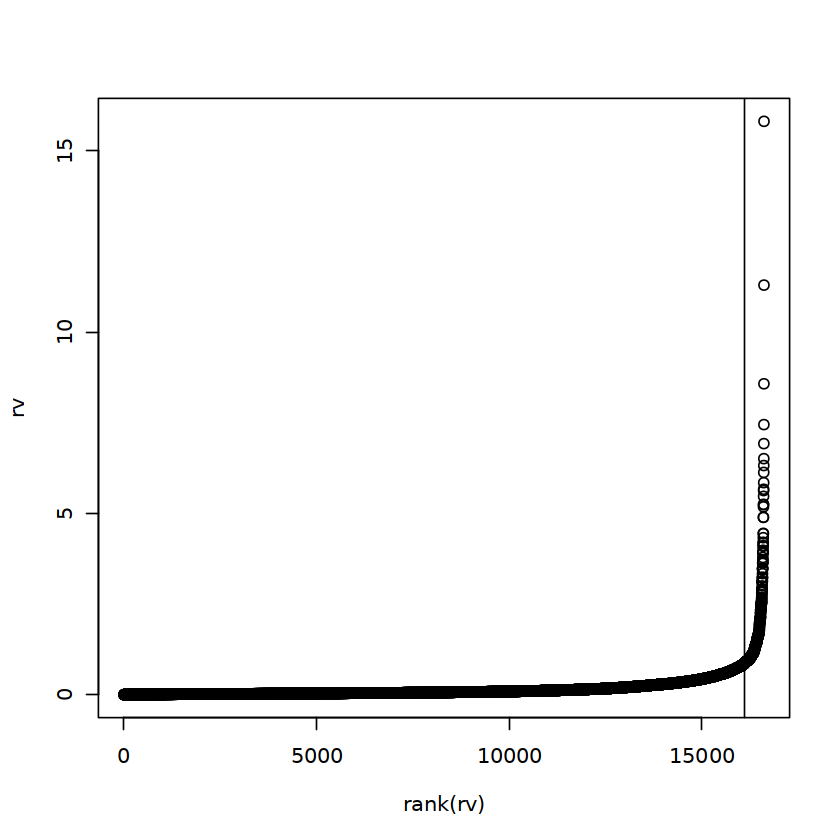

In [303]:
rv <- lcpm_filt %>% column_to_rownames('...1') %>% as.matrix() %>% matrixStats::rowVars()
rv_select <- order(rv, decreasing=TRUE)[1:500]

plot(rank(rv), rv)
abline(v=length(rv)-500)

In [172]:
pheatmap::pheatmap(
    lcpm_filt[rv_select,],
    scale = 'row', 
    show_rownames = FALSE,
    annotation_col = anno_col,
    annotation_colors = anno_colors,
    color = colorRampPalette(rev(brewer.pal(11, 'RdBu')))(200),
    filename = file.path(projdir, 'analyses', 'Plots', 'top500_var_hmp.png')
)

# PCA

## Plots

In [7]:
## Add lines to each plot
panel.lines <- function(x, y, ...)
{
    abline(h=0, lty=2)
    abline(v=0, lty=2)
    points(x,y,...)
}

In [317]:
pca <- prcomp(t(lcpm_filt[rv_select,] %>% column_to_rownames('...1')))
exp_var <- pca$sdev^2 / sum(pca$sdev^2)

In [ ]:
pairs_pch <- c(`BMP2-`=16, `BMP2+`=17)

In [663]:
png(file.path(projdir, 'analyses', 'Plots', 'pca.png'), res=300, units='in', width=6, height=6)
pairs(
    pca$x[,1:5], 
    upper.panel=NULL, 
    lower.panel = panel.lines,
    pch = pairs_pch[y$samples$treatment],
    col = anno_colors$psi[y$samples$psi],
    cex = 2,
    label = sprintf('PC%i\n%0.2f%%', 1:5, 100*exp_var[1:5]))
par(xpd=TRUE)
legend('topright', 
       legend = c(names(anno_colors$psi), names(pairs_pch)),
       pt.cex = 2,
       pch = c(rep(15, length(anno_colors$psi)), pairs_pch), 
       col = c(anno_colors$psi, 'black', 'black'))
dev.off()

png 
  2

In [47]:
projdir

[1] "/mnt/c/Users/benjy/Dropbox (University of Michigan)/ENGIN-Lab Notes/Lab Notes/Lab Notes Benjamin/GraceCaiSamples/8680-PD"

In [381]:
svg(file.path(projdir, 'analyses', 'Plots', 'pca_fig.svg'), width=4, height=4)
cbind(pca$x, y$samples) %>% 
    ggplot(aes(PC1, PC2)) + 
    geom_point(aes(color=psi, shape=treatment), size=4) +
    theme_bw() + 
    ggsci::scale_color_aaas(labels = c('0', '2', '4')) +
    coord_fixed() +
    guides(
        color = guide_legend(title='PSI'),
        shape = guide_legend(title = 'Treatment')
    ) +
    labs(
        x = sprintf('PC1: %0.1f%% variance', 100*exp_var[1]),
        y = sprintf('PC2: %0.1f%% variance', 100*exp_var[2])
    ) +
    theme(
        legend.title = element_text(size = 12, face='bold', family = 'Arial'),
        axis.text = element_text(size=12, color='black', family = 'Arial'),
        axis.title = element_text(size=12, face='bold', family = 'Arial')
    )
dev.off()
#ggsave(file.path(projdir, 'analyses', 'Plots', 'pca_fig.svg'), width=4, height=4)

png 
  2

## PCA loadings

In [302]:
pca_loadings_list <- list()
for(i in 1:5) {
    pca_loadings_list[[i]] <- pca$rotation[,i] %>%
        as.data.frame() %>%
        rownames_to_column('gene') %>%
        pivot_longer(!gene, names_to='PC', values_to='score') %>%
        mutate(Direction = as.factor(sign(score))) %>%
        group_by(Direction) %>%
        dplyr::slice_max(abs(score), n=20) %>%
        ungroup() %>%
        arrange(score) %>%
        mutate(gene = factor(gene, levels=unique(gene))) %>%
        ggplot(aes(score, gene)) +
            geom_col(aes(fill=Direction)) +
            labs(x=NULL) +
            ggtitle(paste0('PC', i))
}

png(file.path(projdir, 'analyses', 'Plots', 'pca_loadings_ens.png'), res=300, units='in', width=20, height=8)
ggpubr::ggarrange(
    plotlist = pca_loadings_list, nrow=1, ncol=5, common.legend=TRUE
)
dev.off()
#ggsave(file.path(projdir, 'analyses', 'Plots', 'pca_loadings_ens.png'), width=20, height=8)

png 
  2

In [464]:
pca_loadings_list <- list()
for(i in 1:5) {
    pca_loadings_list[[i]] <- pca$rotation[,i] %>%
        as.data.frame() %>%
        rownames_to_column('gene') %>%
        pivot_longer(!gene, names_to='PC', values_to='score') %>%
        left_join(rsem[,c('gene_id','external_gene_name')], by=c('gene'='gene_id')) %>%
        dplyr::filter(external_gene_name!='.') %>%
        mutate(Direction = as.factor(sign(score))) %>%
        group_by(Direction) %>%
        dplyr::slice_max(abs(score), n=20) %>%
        ungroup() %>%
        arrange(score) %>%
        mutate(external_gene_name = factor(external_gene_name, levels=unique(external_gene_name))) %>%
        ggplot(aes(score, external_gene_name)) +
            geom_col(aes(fill=Direction)) +
            labs(x=NULL) +
            ggtitle(paste0('PC', i))
}

png(file.path(projdir, 'analyses', 'Plots', 'pca_loadings_sym.png'), res=300, units='in', width=20, height=8)
ggpubr::ggarrange(
    plotlist = pca_loadings_list, nrow=1, ncol=5, common.legend=TRUE
)
dev.off()

png 
  2

## Heatmap of loading genes

In [318]:
pc1_rot <- pca$rotation[,1] %>%
    as.data.frame() %>%
    rownames_to_column('gene') %>%
    pivot_longer(!gene, names_to='PC', values_to='score') %>%
    mutate(Direction = as.factor(sign(score))) %>%
    dplyr::slice_max(abs(score), n=100)
#pc1_rot$sym <- gene_data$external_gene_name[match(pc1_rot$gene, gene_data$gene_id)]
pc1_rot_genes <- split(pc1_rot$gene, pc1_rot$Direction)
str(pc1_rot_genes)

List of 2
 $ -1: chr [1:15] "ENSG00000286038" "ENSG00000273184" "ENSG00000284292" "ENSG00000287086" ...
 $ 1 : chr [1:85] "ENSG00000288859" "ENSG00000165507" "ENSG00000135245" "ENSG00000081041" ...


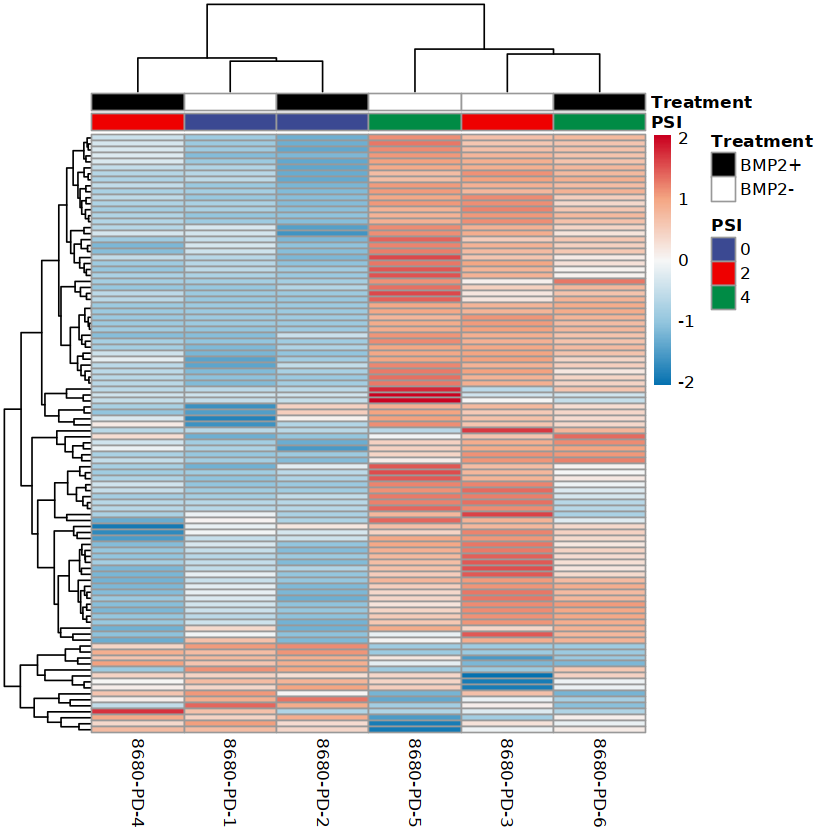

In [322]:
mat <- lcpm_filt %>% column_to_rownames('...1')

pheatmap::pheatmap(
    mat[unlist(pc1_rot_genes),],
    scale='row', 
    show_rownames = FALSE,
    annotation_col = anno_col, 
    annotation_colors = anno_colors,
    clustering_method='complete', 
    colorRampPalette(rev(brewer.pal(5,'RdBu')))(200)
)

## Annotation of loading genes

In [296]:
library(clusterProfiler)
library(enrichplot)
library(ReactomePA)

In [702]:
pc1_rot_gobp <- compareCluster(pc1_rot_genes, fun=enrichGO, keyType='ENSEMBL', readable=TRUE, OrgDb='org.Hs.eg.db', ont='BP', universe=rownames(lcpm_filt))

In [703]:
pc1_rot_gobp <- pairwise_termsim(pc1_rot_gobp)

In [704]:
pc1_rot_gobp

#
# Result of Comparing 2 gene clusters 
#
#.. @fun 	 enrichGO 
#.. @geneClusters 	List of 2
 $ -1: chr [1:15] "ENSG00000286038" "ENSG00000273184" "ENSG00000284292" "ENSG00000287086" ...
 $ 1 : chr [1:85] "ENSG00000288859" "ENSG00000165507" "ENSG00000135245" "ENSG00000081041" ...
#...Result 	'data.frame':	422 obs. of  10 variables:
 $ Cluster    : Factor w/ 2 levels "-1","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ ID         : chr  "GO:1901099" "GO:2001240" "GO:1900026" "GO:2001239" ...
 $ Description: chr  "negative regulation of signal transduction in absence of ligand" "negative regulation of extrinsic apoptotic signaling pathway in absence of ligand" "positive regulation of substrate adhesion-dependent cell spreading" "regulation of extrinsic apoptotic signaling pathway in absence of ligand" ...
 $ GeneRatio  : chr  "1/2" "1/2" "1/2" "1/2" ...
 $ BgRatio    : chr  "28/12125" "28/12125" "37/12125" "38/12125" ...
 $ pvalue     : num  0.00461 0.00461 0.00609 0.00626 0.00872 ...
 $ p.adjust   : nu

In [334]:
pc1_rot_genes_entrez <- lapply(pc1_rot_genes, function(i) unique(na.omit(gene_data$entrezgene_id[match(i, gene_data$gene_id)])))
pc1_rot_reactome <- compareCluster(pc1_rot_genes_entrez, fun=enrichPathway, readable=TRUE, organism='human', universe=rownames(lcpm_filt_entrez))

In [706]:
pc1_rot_all_gobp <- enrichGO(unlist(pc1_rot_genes), keyType='ENSEMBL', readable=TRUE, OrgDb='org.Hs.eg.db', ont='BP', universe=rownames(lcpm_filt))

In [707]:
pc1_rot_all_gobp <- pairwise_termsim(pc1_rot_all_gobp)

In [708]:
pc1_rot_all_reactome <- enrichPathway(unlist(pc1_rot_genes_entrez), readable=TRUE, organism='human', universe=rownames(lcpm_filt_entrez))

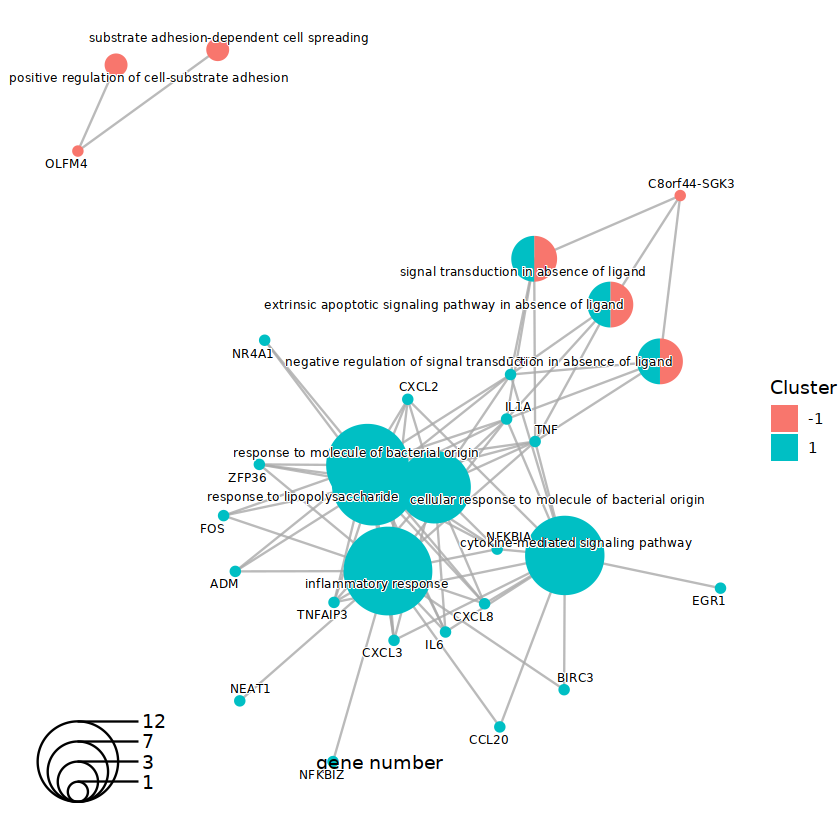

In [709]:
cnetplot(gofilter(pc1_rot_gobp, 5))

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


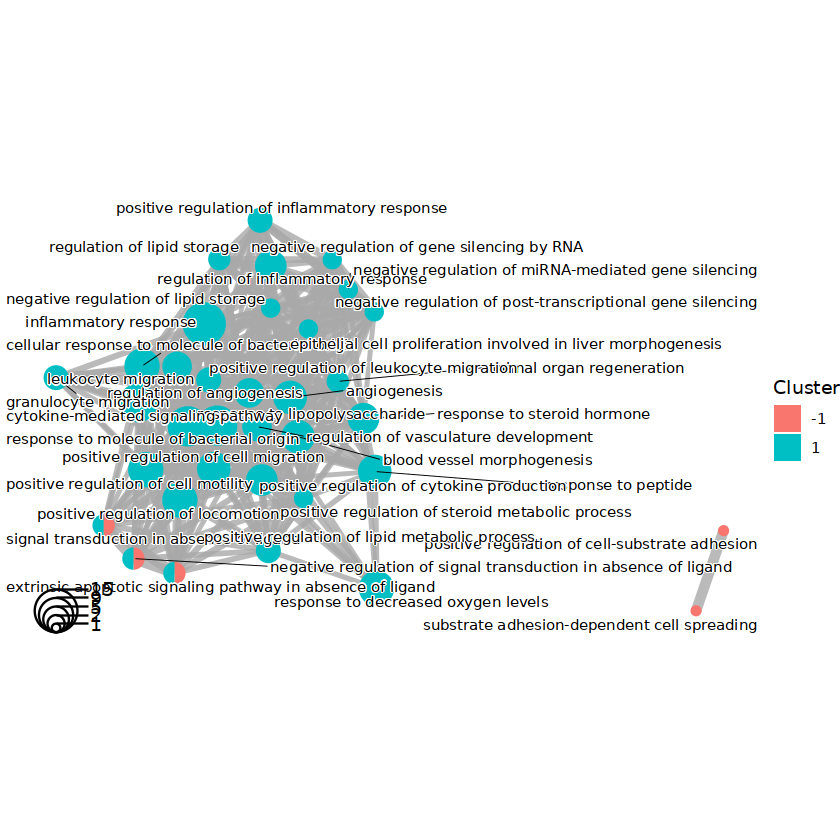

In [711]:
emapplot(gofilter(pc1_rot_gobp, 5))

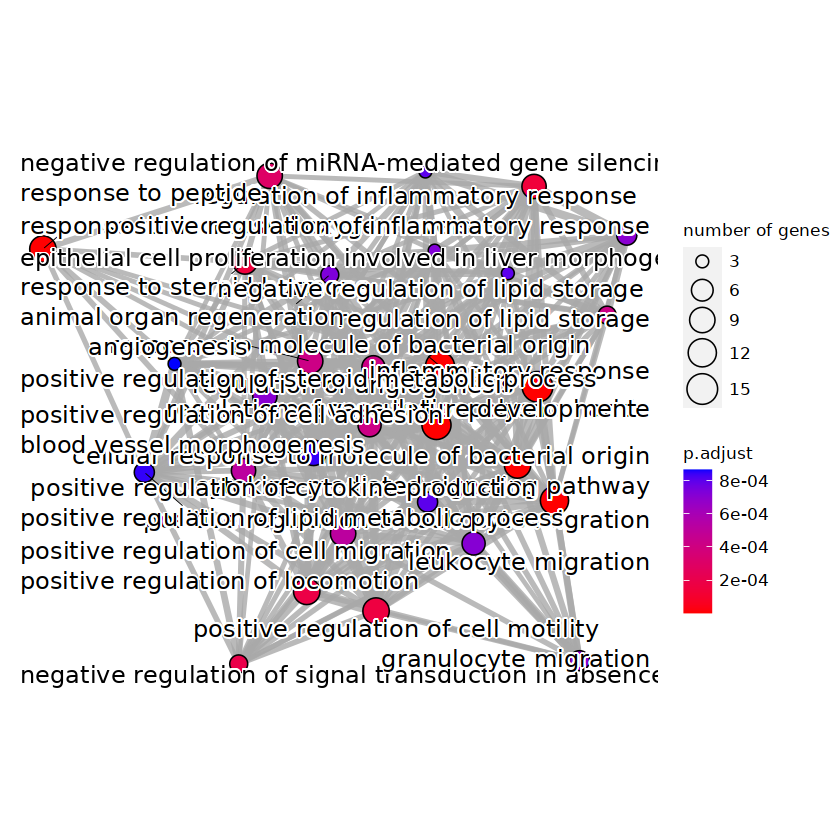

In [710]:
emapplot(gofilter(pc1_rot_all_gobp, 5))

In [723]:
svg(file.path(projdir, 'analyses', 'Plots', 'pc1_rot_clust_gobp.svg'), width=8, height=8)
dotplot(gofilter(pc1_rot_gobp, 5), showCategory=30, label_format=100)
dev.off()

png 
  2

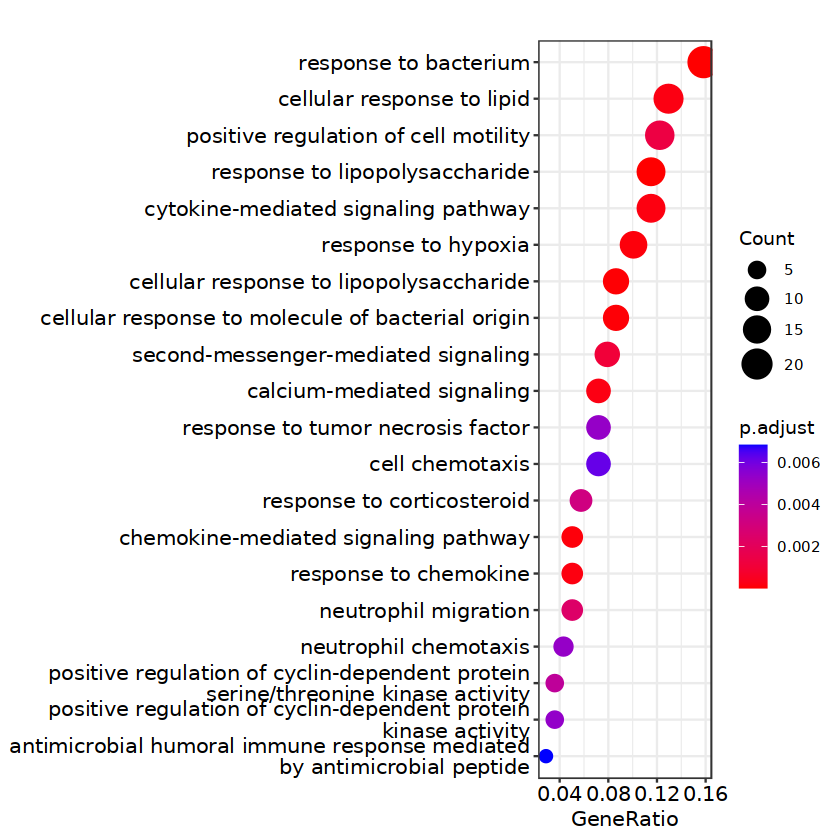

In [694]:
dotplot(gofilter(pc1_rot_all_gobp, 6), showCategory=20, label_format=50)

In [698]:
svg(file.path(projdir, 'analyses', 'Plots', 'pc1_rot_all_gobp.svg'), width=10, height=11)
dotplot(gofilter(pc1_rot_all_gobp, 5), showCategory=50, label_format=100)
dev.off()

png 
  2

In [726]:
svg(file.path(projdir, 'analyses', 'Plots', 'pc1_rot_clust_reactome.svg'), width=10, height=8)
dotplot(pc1_rot_reactome, showCategory=30, label_format=100)
dev.off()

png 
  2

In [683]:
svg(file.path(projdir, 'analyses', 'Plots', 'pc1_rot_all_reactome.svg'), width=13, height=10)
dotplot(pc1_rot_all_reactome, showCategory=50, label_format=100)
dev.off()
#ggsave(file.path(projdir, 'analyses', 'Plots', 'pc1_rot_all_reactome.svg'), width=15)

png 
  2

In [339]:
pc1_rot_reactome %>%
    as.data.frame() %>%
    arrange(p.adjust) %>%
    dplyr::filter(Description %in% c(
        'Senescence-Associated Secretory Phenotype (SASP)',
        '

Cluster ID           
1  1       R-HSA-6783783
2  1       R-HSA-2559582
3  1       R-HSA-380108 
4  1       R-HSA-449147 
5  1       R-HSA-6785807
6  1       R-HSA-2559583
7  1       R-HSA-375276 
8  1       R-HSA-5357956
9  1       R-HSA-500792 
10 1       R-HSA-383280 
11 1       R-HSA-9031628
12 1       R-HSA-5357905
13 1       R-HSA-373076 
14 1       R-HSA-9018519
15 1       R-HSA-75893  
16 1       R-HSA-5357786
17 1       R-HSA-198725 
18 1       R-HSA-5676594
19 1       R-HSA-8936459
20 1       R-HSA-73887  
   Description                                                                          
1  Interleukin-10 signaling                                                             
2  Senescence-Associated Secretory Phenotype (SASP)                                     
3  Chemokine receptors bind chemokines                                                  
4  Signaling by Interleukins                                                            
5  Interleukin-4 and Interleukin-13 signaling                                           
6  Cellular Senescence                                                                  
7  Peptide ligand-binding receptors                                                     
8  TNFR1-induced NFkappaB signaling pathway                                             
9  GPCR ligand binding                                                                  
10 Nuclear Receptor transcription pathway                                               
11 NGF-stimulated transcription                                                         
12 Regulation of TNFR1 signaling                                                        
13 Class A/1 (Rhodopsin-like receptors)                                                 
14 Estrogen-dependent gene expression                                                   
15 TNF signaling                                                                        
16 TNFR1-induced proapoptotic signaling                                                 
17 Nuclear Events (kinase and transcription factor activation)                          
18 TNF receptor superfamily (TNFSF) members mediating non-canonical NF-kB pathway       
19 RUNX1 regulates genes involved in megakaryocyte differentiation and platelet function
20 Death Receptor Signalling                                                            
   GeneRatio BgRatio  pvalue       p.adjust     qvalue      
1  7/29      31/7733  1.181344e-11 2.799786e-09 1.641447e-09
2  6/29      78/7733  3.423202e-07 4.056495e-05 2.378225e-05
3  4/29      23/7733  1.344767e-06 1.062366e-04 6.228392e-05
4  9/29      363/7733 4.351198e-06 2.578085e-04 1.511469e-04
5  5/29      79/7733  9.597831e-06 4.549372e-04 2.667187e-04
6  6/29      161/7733 2.370029e-05 9.361615e-04 5.488488e-04
7  4/29      58/7733  5.884636e-05 1.992370e-03 1.168078e-03
8  3/29      30/7733  1.798781e-04 5.017935e-03 2.941894e-03
9  5/29      147/7733 1.905545e-04 5.017935e-03 2.941894e-03
10 3/29      33/7733  2.399064e-04 5.168893e-03 3.030397e-03
11 3/29      33/7733  2.399064e-04 5.168893e-03 3.030397e-03
12 3/29      40/7733  4.268379e-04 8.235054e-03 4.828013e-03
13 4/29      98/7733  4.517118e-04 8.235054e-03 4.828013e-03
14 4/29      109/7733 6.761410e-04 1.144610e-02 6.710572e-03
15 3/29      49/7733  7.781175e-04 1.229426e-02 7.207825e-03
16 2/29      13/7733  1.032490e-03 1.521535e-02 8.920394e-03
17 3/29      55/7733  1.091397e-03 1.521535e-02 8.920394e-03
18 2/29      15/7733  1.383441e-03 1.686044e-02 9.884870e-03
19 3/29      60/7733  1.405780e-03 1.686044e-02 9.884870e-03
20 4/29      133/7733 1.422822e-03 1.686044e-02 9.884870e-03
   geneID                                         Count
1  CXCL2/TNF/CCL20/CSF2/IL1A/IL6/CXCL8            7    
2  H2AC19/FOS/IL1A/IL6/CXCL8/H4C15                6    
3  CXCL2/CCL20/CXCL3/CXCL8                        4    
4  CXCL2/TNF/CCL20/CSF2/FOS/IL1A/IL6/CXCL8/NFKBIA 9    
5  TNF/FOS/IL1A/IL6/CXCL8                       

# YAP/TAZ signaling

## Prepare Reactome data

In [57]:
reactome_ID2name <- as.list(reactomePATHID2NAME)

In [58]:
reactome_ID2name_df <- as.data.frame(t(as.data.frame(reactome_ID2name)))
rownames(reactome_ID2name_df) <- gsub('.','-',rownames(reactome_ID2name_df),fixed=TRUE)
colnames(reactome_ID2name_df) <- 'Name'

In [59]:
reactome_path2ID <- as.list(reactomePATHID2EXTID)
reactome_path2ID <- reactome_path2ID[grepl('HSA',names(reactome_path2ID),fixed=TRUE)]

In [333]:
lcpm_entrez_idx <- match(rownames(lcpm_filt), y$genes$gene_id)
lcpm_entrez_idx <- lcpm_entrez_idx[y$genes$entrezgene_id[lcpm_entrez_idx] != '.']
lcpm_entrez_idx <- lcpm_entrez_idx[y$genes$entrezgene_id[lcpm_entrez_idx] != '']
lcpm_entrez_idx <- lcpm_entrez_idx[!grepl(',', y$genes$entrezgene_id[lcpm_entrez_idx])]
lcpm_entrez_idx <- lcpm_entrez_idx[!is.na(y$genes$entrezgene_id[lcpm_entrez_idx])]
lcpm_entrez_idx <- lcpm_entrez_idx[!duplicated(y$genes$entrezgene_id[lcpm_entrez_idx])]
lcpm_filt_entrez <- lcpm_filt[lcpm_entrez_idx,]
rownames(lcpm_filt_entrez) <- y$genes$entrezgene_id[lcpm_entrez_idx]
#sva_lcpm_filt_entrez <- sva_lcpm_filt[lcpm_entrez_idx,]
#rownames(sva_lcpm_filt_entrez) <- y$genes$entrezgene_id[lcpm_entrez_idx]

## Look at expression

### Reactome

In [386]:
signaling_by_hippo <- reactome_path2ID[['R-HSA-2028269']]

In [387]:
signaling_by_hippo_ens <- gene_data %>% 
    dplyr::filter(entrezgene_id %in% signaling_by_hippo) %>%
    pull(gene_id) %>%
    unique()

In [388]:
signaling_by_hippo_counts <- lcpm_filt_entrez[signaling_by_hippo,]
rownames(signaling_by_hippo_counts) <- gene_data$external_gene_name[match(rownames(signaling_by_hippo_counts), gene_data$entrezgene_id)]

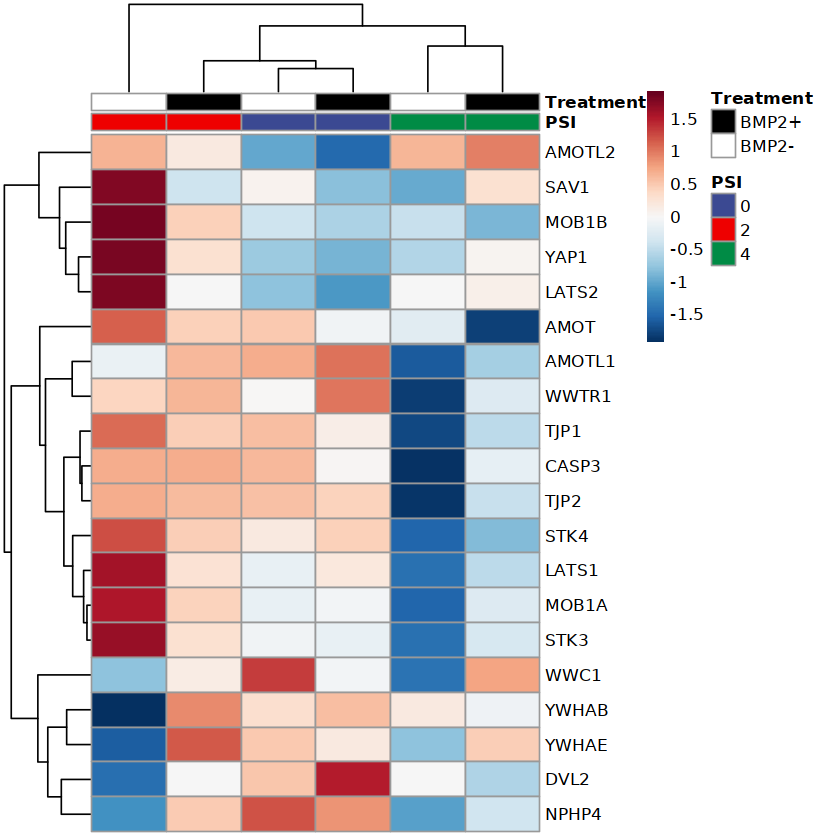

In [389]:
pheatmap::pheatmap(
    signaling_by_hippo_counts,
    scale = 'row',
    annotation_col = anno_col,
    annotation_colors = anno_colors,
    show_colnames = FALSE,
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200)
)

### GO Term

In [382]:
library(GO.db)

In [383]:
as.list(GO.db::GO)[1]

[[1]]
showQCData("GO", datacache)


In [390]:
go_all_genes <- as.list(org.Hs.eg.db::org.Hs.egGO2ALLEGS)

In [391]:
go_genes <- as.list(org.Hs.eg.db::org.Hs.egGO2EG)

In [392]:
str(go_genes[1])

List of 1
 $ GO:0000002: Named chr [1:13] "291" "1890" "4205" "4358" ...
  ..- attr(*, "names")= chr [1:13] "TAS" "IMP" "ISS" "IMP" ...


In [393]:
str(go_all_genes[1])

List of 1
 $ GO:0000002: Named chr [1:45] "142" "291" "1763" "1890" ...
  ..- attr(*, "names")= chr [1:45] "IMP" "TAS" "IDA" "IMP" ...


In [394]:
length(na.omit(gene_data$gene_id[match(unname(go_all_genes[['GO:0035329']]), gene_data$entrezgene_id)]))

[1] 70

In [29]:
# GO:0035329
# hippo_go_term <- read_tsv(file.path(projdir, 'analyses', 'GO_term_summary_20230818_005437_Hippo.txt'))

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 89 Columns: 11
── Column specification ──────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): MGI Gene/Marker ID, Symbol, Name, Chr, Annotated Term, Context, Evi...
lgl (2): Qualifier, Proteoform

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [395]:
#hippo_go_term <- toupper(unique(hippo_go_term$Symbol))
hippo_go_term <- na.omit(gene_data$external_gene_name[match(unname(go_all_genes[['GO:0035329']]), gene_data$entrezgene_id)])
hippo_go_term_ens <- na.omit(gene_data$gene_id[match(unname(go_all_genes[['GO:0035329']]), gene_data$entrezgene_id)])
length(hippo_go_term)
length(hippo_go_term_ens)

[1] 70

[1] 70

In [158]:
setdiff(signaling_by_hippo_ens, intersect(rownames(lcpm_filt), hippo_go_term_ens))

[1] "ENSG00000004975" "ENSG00000104067" "ENSG00000108953" "ENSG00000119139"
[5] "ENSG00000131697" "ENSG00000164305" "ENSG00000166913"

In [396]:
hippo_goterm_counts <- lcpm_filt[intersect(rownames(lcpm_filt), hippo_go_term_ens),]
rownames(hippo_goterm_counts) <- gene_data$external_gene_name[match(rownames(hippo_goterm_counts), gene_data$gene_id)]

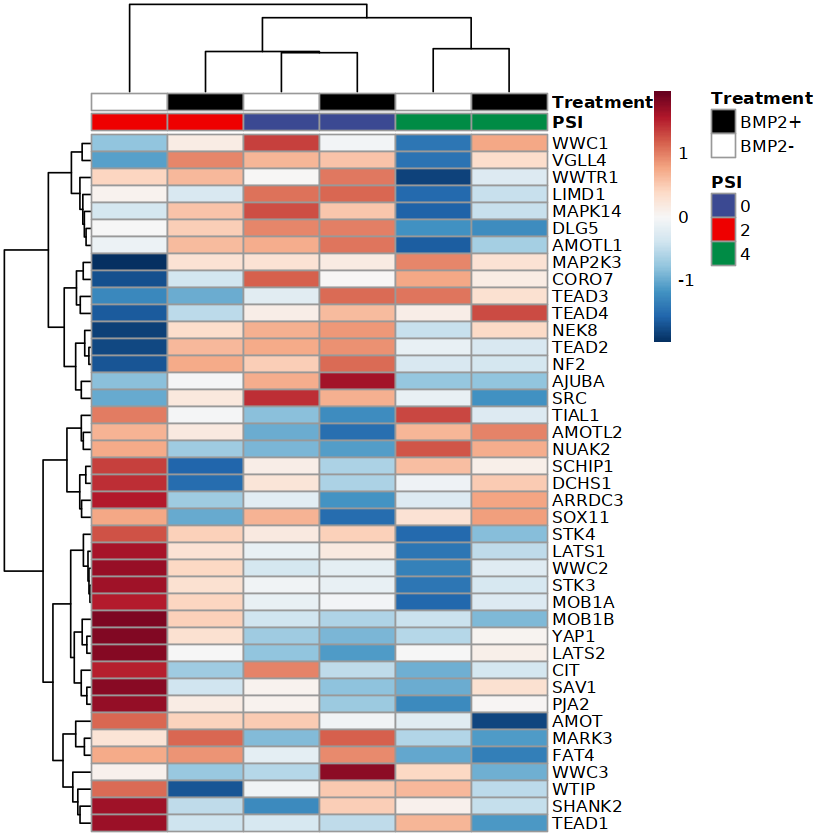

In [397]:
pheatmap::pheatmap(
    hippo_goterm_counts,
    scale = 'row',
    annotation_col = anno_col,
    annotation_colors = anno_colors,
    show_colnames = FALSE,
    clustering_method = 'ward.D2',
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200)
)

## Combined terms

In [398]:
hippo_combo_ens <- unique(c(hippo_go_term_ens, signaling_by_hippo_ens))

In [399]:
hippo_combo_counts <- lcpm_filt[intersect(rownames(lcpm_filt), hippo_combo_ens),]
rownames(hippo_combo_counts) <- gene_data$external_gene_name[match(rownames(hippo_combo_counts), gene_data$gene_id)]

In [400]:
hippo_combo_lfc <- as.data.frame(hippo_combo_counts)
hippo_combo_lfc$psi0 <- hippo_combo_counts[,2] - hippo_combo_counts[,1]
hippo_combo_lfc$psi2 <- hippo_combo_counts[,4] - hippo_combo_counts[,3]
hippo_combo_lfc$psi4 <- hippo_combo_counts[,5] - hippo_combo_counts[,6]
head(hippo_combo_lfc)

8680-PD-1 8680-PD-2 8680-PD-3 8680-PD-4 8680-PD-5 8680-PD-6 psi0       
DVL2   5.910542  6.023661  5.680162  5.847339  5.848075  5.779618   0.11311889
TEAD3  5.094403  5.199584  5.010451  5.035255  5.196109  5.135763   0.10518108
WWTR1  7.956006  8.236444  8.070272  8.129616  7.450676  7.880077   0.28043824
MAP2K3 6.684149  6.664307  6.276171  6.683020  6.805668  6.684435  -0.01984179
WWC3   5.547968  5.701219  5.591052  5.535707  5.612368  5.521956   0.15325137
TEAD2  4.778546  4.799691  4.449689  4.765491  4.663163  4.642949   0.02114582
       psi2        psi4       
DVL2    0.16717679  0.06845662
TEAD3   0.02480318  0.06034620
WWTR1   0.05934401 -0.42940089
MAP2K3  0.40684930  0.12123369
WWC3   -0.05534434  0.09041200
TEAD2   0.31580223  0.02021406

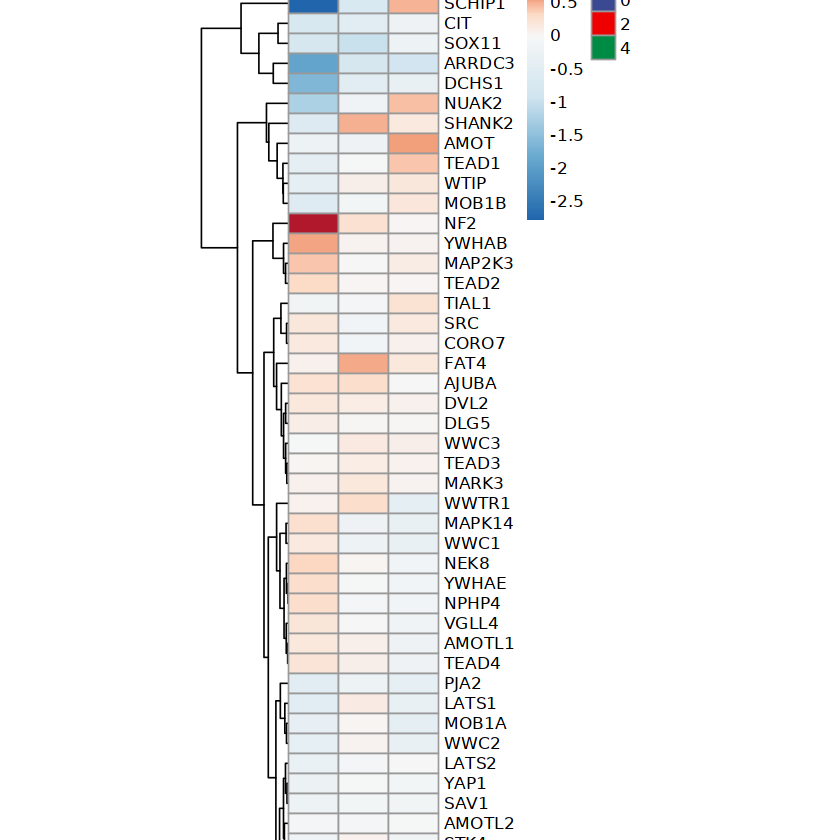

In [401]:
mat <- as.matrix(hippo_combo_lfc[,paste0('psi',c(0,2,4))])
paletteLength <- 200

myBreaks <- c(seq(min(mat), 0, length.out=ceiling(paletteLength/2) + 1), 
              seq(max(mat)/paletteLength, max(mat), length.out=floor(paletteLength/2)))

hippo_combo_lfc_hmp <- pheatmap::pheatmap(
    as.matrix(hippo_combo_lfc[,paste0('psi',c(0,2,4))]),
    scale = 'none', 
    cellwidth=30, cellheight=12,
    clustering_method = 'complete',
    annotation_col = data.frame(PSI = as.factor(c(0,2,4)), row.names=paste0('psi',c(0,2,4))),
    annotation_colors = anno_colors,
    show_colnames = FALSE,
    #fontfamily = 'Arial',
    #color = colorRampPalette(hcl.colors(20, 'Berlin'))(paletteLength),
    #color = colorRampPalette(c('green','black','red'))(200),
    breaks = myBreaks,
    color = colorRampPalette(rev(brewer.pal(7,'RdBu')))(paletteLength)
)

In [402]:
svg(file.path(projdir, 'analyses', 'Plots', 'hippo_combo_lfc.svg'), height=10, width=4)
hippo_combo_lfc_hmp
dev.off()

png 
  2

In [429]:
anno_col

Pressure Treatment
8680-PD-1 0 psi    -BMP2    
8680-PD-2 0 psi    +BMP2    
8680-PD-3 2 psi    -BMP2    
8680-PD-4 2 psi    +BMP2    
8680-PD-5 4 psi    -BMP2    
8680-PD-6 4 psi    +BMP2

In [430]:
anno_colors

$PSI
      0 psi       2 psi       4 psi 
"#3B4992FF" "#EE0000FF" "#008B45FF" 

$Treatment
  +BMP2   -BMP2 
"black" "white"

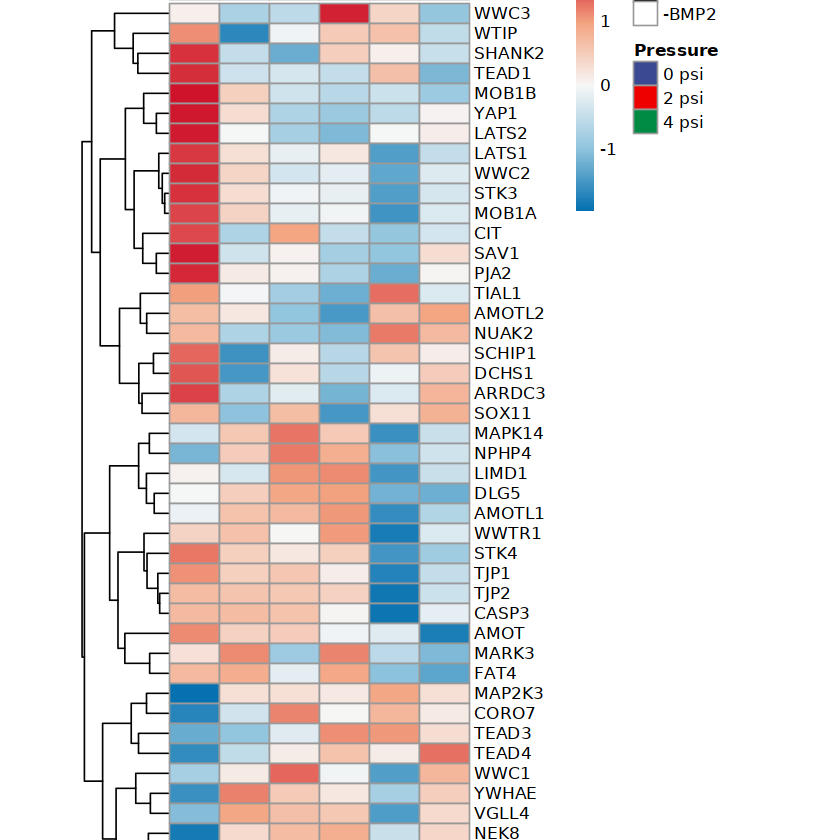

In [432]:
hippo_combo_hmp <- pheatmap::pheatmap(
    hippo_combo_counts,
    scale = 'row', 
    cellwidth=30, cellheight=12,
    clustering_method = 'complete',
    annotation_col = anno_col,
    annotation_colors = anno_colors,
    show_colnames = FALSE,
    fontfamily = 'Arial',
    #color = colorRampPalette(hcl.colors(11, 'Berlin'))(200)
    #color = colorRampPalette(c('green','black','red'))(200)
    color = colorRampPalette(rev(brewer.pal(5,'RdBu')))(200)
)

In [433]:
svg(file.path(projdir, 'analyses', 'Plots', 'hippo_combo_counts.svg'), height=10)
hippo_combo_hmp
dev.off()

png 
  2

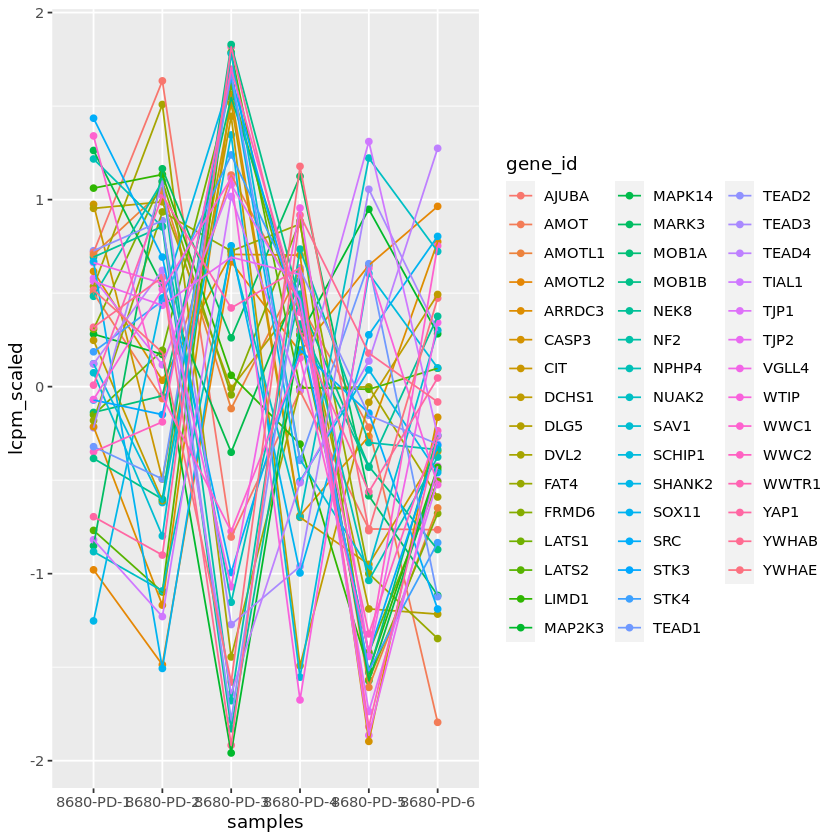

In [249]:

hippo_combo_counts %>%
    as.data.frame() %>%
    rownames_to_column('gene_id') %>%
    pivot_longer(!gene_id, names_to='samples', values_to='lcpm') %>%
    left_join(y$samples %>% rownames_to_column('samples') %>% dplyr::select(samples, psi, treatment), by='samples') %>%
    group_by(gene_id) %>%
    mutate(lcpm_scaled = scale(lcpm)) %>%
    ggplot(aes(samples, lcpm_scaled)) + 
    geom_point(aes(color=gene_id)) +
    geom_line(aes(color=gene_id, group=gene_id))

In [238]:
hippo_combo_counts['YAP1',]

8680-PD-1 8680-PD-2 8680-PD-3 8680-PD-4 8680-PD-5 8680-PD-6 
 6.677469  6.641802  7.114350  6.850027  6.700549  6.806485

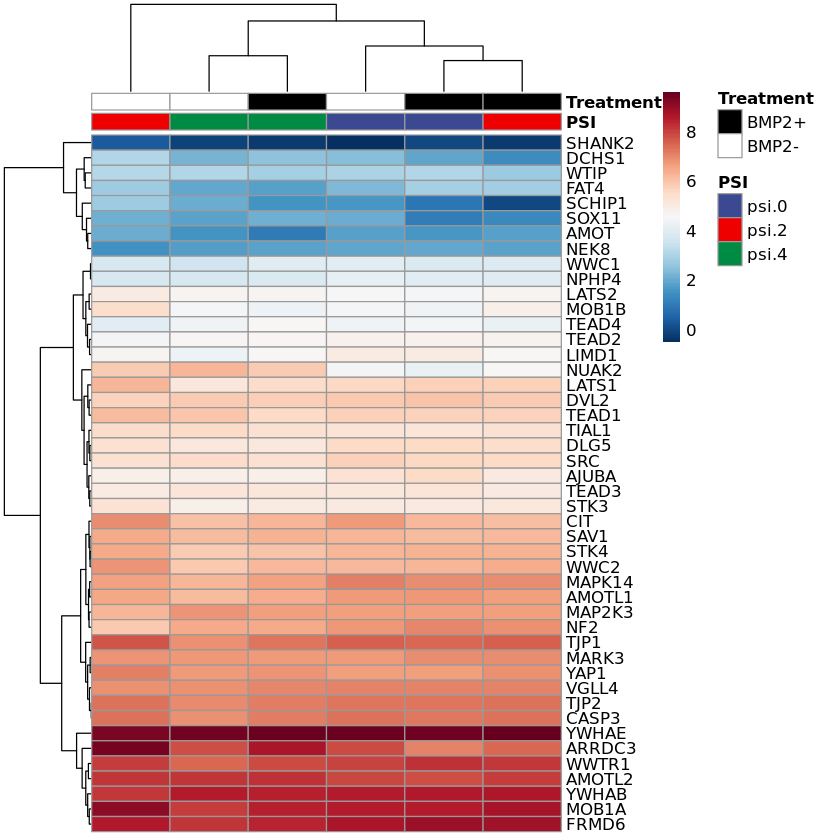

In [226]:
pheatmap::pheatmap(
    hippo_combo_counts,
    scale = 'none',
    clustering_method = 'complete',
    annotation_col = anno_col,
    annotation_colors = anno_colors,
    show_colnames = FALSE,
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200)
)

# edgeR

In [232]:
mean_exp <- rowMeans(lcpm_filt)
var_exp <- matrixStats::rowVars(lcpm_filt)

In [103]:
estimateCommonDisp(y$counts, group=rep(1,6), verbose = TRUE)

Disp = 0.04001 , BCV = 0.2 


[1] 0.04000624

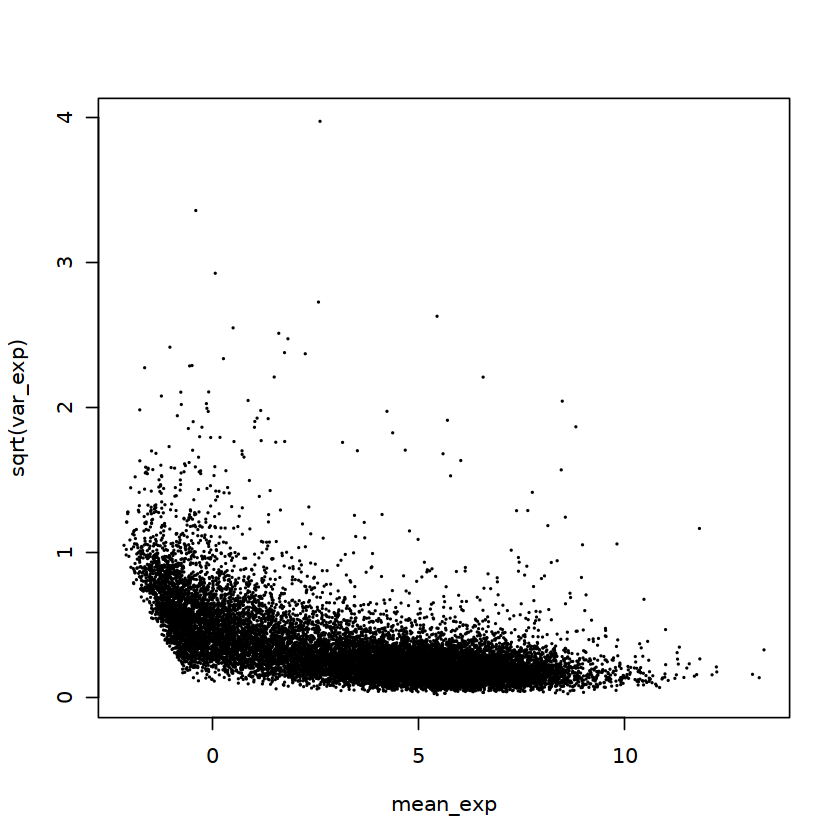

In [236]:
plot(mean_exp, sqrt(var_exp), pch=16, cex=0.25)

In [104]:
bcv <- 0.2
et_psi0 <- exactTest(y, pair=c('psi.0.BMP2-', 'psi.0.BMP2+'), dispersion=bcv^2)
et_psi2 <- exactTest(y, pair=c('psi.2.BMP2-', 'psi.2.BMP2+'), dispersion=bcv^2)
et_psi4 <- exactTest(y, pair=c('psi.4.BMP2-', 'psi.4.BMP2+'), dispersion=bcv^2)

In [106]:
head(topTags(et_psi4, p.value = 0.05, n=Inf)$table)

gene_id         entrezgene_id external_gene_name
ENSG00000288825 ENSG00000288825 8337          H2AC18            
ENSG00000288859 ENSG00000288859 723790        H2AC19            
ENSG00000277150 ENSG00000277150 474384        F8A3              
ENSG00000288709 ENSG00000288709 474383        F8A2              
ENSG00000256040 ENSG00000256040 493913        PAPPA-AS1         
ENSG00000285238 ENSG00000285238 .             .                 
                description                                                             
ENSG00000288825 H2A clustered histone 18 [Source:HGNC Symbol;Acc:HGNC:4736]             
ENSG00000288859 H2A clustered histone 19 [Source:HGNC Symbol;Acc:HGNC:29668]            
ENSG00000277150 coagulation factor VIII associated 3 [Source:HGNC Symbol;Acc:HGNC:31850]
ENSG00000288709 coagulation factor VIII associated 2 [Source:HGNC Symbol;Acc:HGNC:31849]
ENSG00000256040 PAPPA antisense RNA 1 [Source:HGNC Symbol;Acc:HGNC:35152]               
ENSG00000285238 novel transcript                                                        
                logFC      logCPM    PValue       FDR         
ENSG00000288825  12.654136 3.7704577 3.877301e-33 6.440196e-29
ENSG00000288859 -11.018350 2.3660037 4.583218e-23 3.806363e-19
ENSG00000277150 -10.552952 2.9629065 4.358511e-20 2.413162e-16
ENSG00000288709  10.232490 0.6099489 6.310148e-17 2.620289e-13
ENSG00000256040  -9.875456 0.6426188 4.866611e-16 1.616688e-12
ENSG00000285238  -9.700567 1.8456404 5.391446e-15 1.492532e-11

## Housekeeping genes

In [107]:
# https://housekeeping.unicamp.br/?download
housekeeping_genes <- read.delim(file.path(projdir, 'analyses', 'Housekeeping_GenesHuman.csv'), sep=';')

In [108]:
housekeeping_genes <- housekeeping_genes %>% left_join(gene_data, by=c('Gene.name'='external_gene_name')) %>% distinct()
head(housekeeping_genes)

Ensembl         Gene.name Refseq                                   CCDS.ID  
1 ENST00000000233 ARF5      NM_001662                                CCDS34745
2 ENST00000000412 M6PR      NM_002355                                CCDS8598 
3 ENST00000005257 RALA      NM_005402                                CCDS5460 
4 ENST00000005340 DVL2      NM_004422                                CCDS11091
5 ENST00000006777 RHBDD2    NM_001346188; NM_001346189; NM_001040456 CCDS43602
6 ENST00000007390 TSR3      NM_001001410                             CCDS10435
  gene_id         entrezgene_id
1 ENSG00000004059 381          
2 ENSG00000003056 4074         
3 ENSG00000006451 5898         
4 ENSG00000004975 1856         
5 ENSG00000005486 57414        
6 ENSG00000007520 115939       
  description                                                                      
1 ADP ribosylation factor 5 [Source:HGNC Symbol;Acc:HGNC:658]                      
2 mannose-6-phosphate receptor, cation dependent [Source:HGNC Symbol;Acc:HGNC:6752]
3 RAS like proto-oncogene A [Source:HGNC Symbol;Acc:HGNC:9839]                     
4 dishevelled segment polarity protein 2 [Source:HGNC Symbol;Acc:HGNC:3086]        
5 rhomboid domain containing 2 [Source:HGNC Symbol;Acc:HGNC:23082]                 
6 TSR3 ribosome maturation factor [Source:HGNC Symbol;Acc:HGNC:14175]

In [109]:
housekeeping <- intersect(housekeeping_genes$gene_id, rownames(y))

In [121]:
table(cut_number(rowMeans(lcpm_filt[housekeeping,]), n=10))


[-0.74,4.8]  (4.8,5.32] (5.32,5.74]  (5.74,6.1]   (6.1,6.4]  (6.4,6.74] 
        213         213         212         213         213         212 
(6.74,7.11] (7.11,7.56]  (7.56,8.2]  (8.2,12.2] 
        213         212         213         213 

In [124]:
table(cut_interval(rowMeans(lcpm_filt[housekeeping,]), n=10))


[-0.74,0.556]  (0.556,1.85]   (1.85,3.15]   (3.15,4.44]   (4.44,5.74] 
            2             4            28           109           494 
  (5.74,7.04]   (7.04,8.33]   (8.33,9.63]   (9.63,10.9]   (10.9,12.2] 
          809           501           135            39             6 

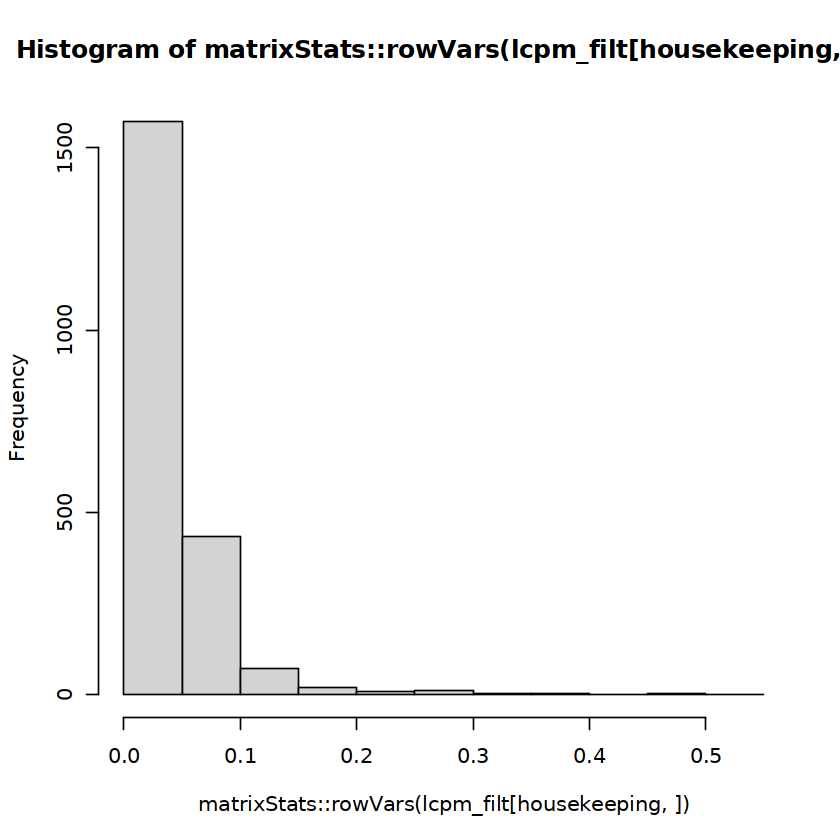

In [294]:
hist(matrixStats::rowVars(lcpm_filt[housekeeping,]))

In [615]:
sampled_genes <- list()
for(i in 1:500) sampled_genes[[i]] <- base::sample(setdiff(rownames(y), housekeeping), length(housekeeping))

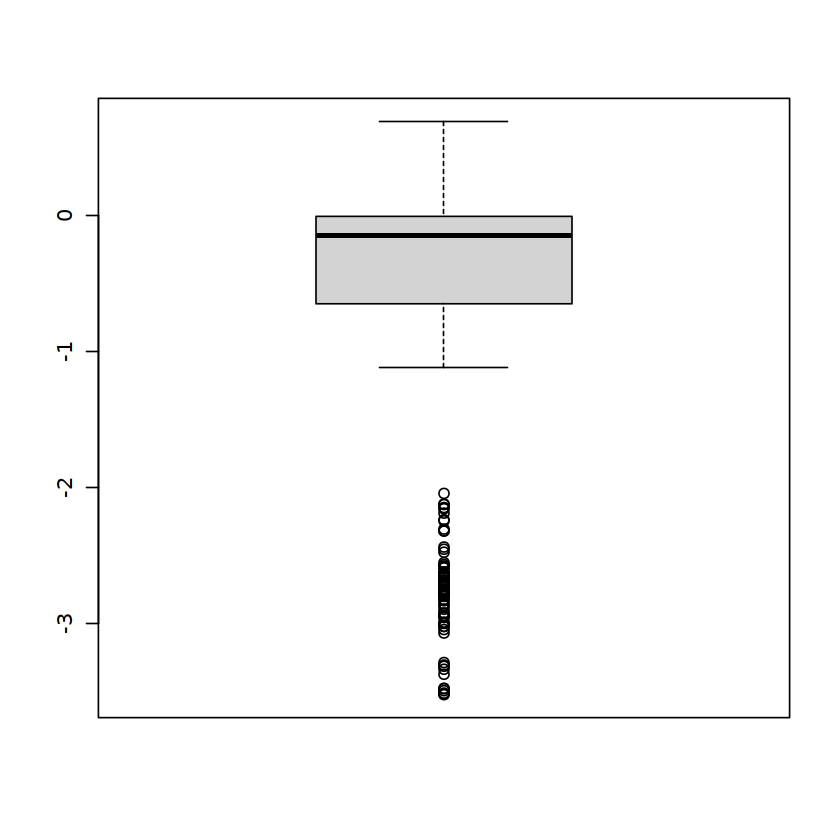

In [642]:
boxplot(unlist(lapply(sampled_genes, function(i) mean(calc_cv(lcpm_filt[i,])))))

In [619]:
calc_cv <- function(data) matrixStats::rowSds(data) / rowMeans(data)

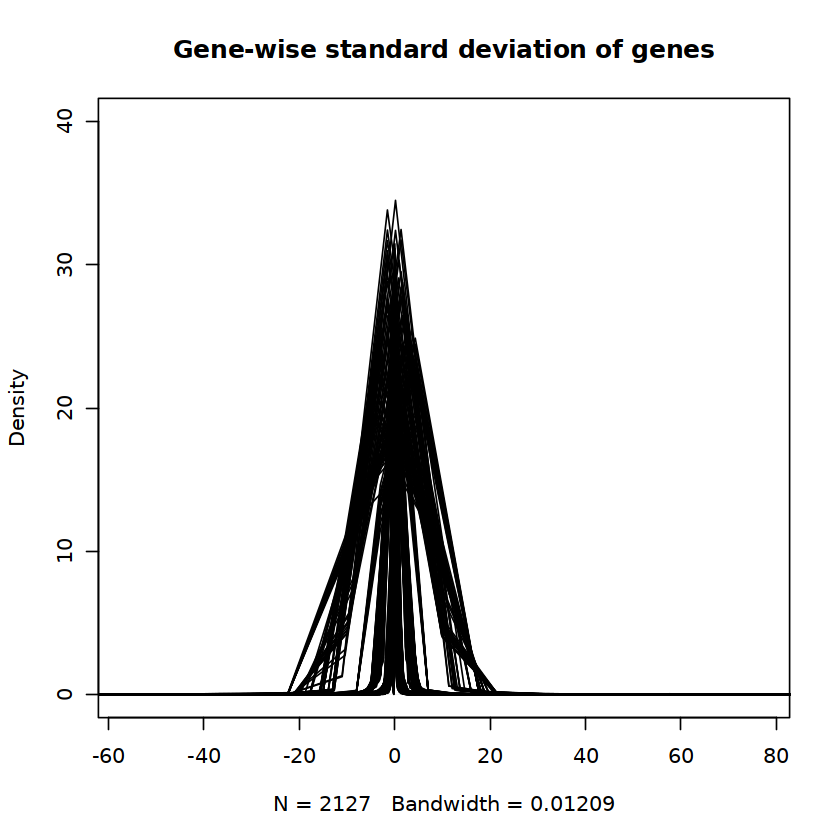

In [634]:
plot(density(calc_cv(lcpm_filt[sampled_genes[[1]],])), main='Gene-wise standard deviation of genes', ylim=c(0,40))
for(i in 2:500) lines(density(calc_cv(lcpm_filt[sampled_genes[[i]],])))
#lines(density(calc_cv(lcpm_filt[housekeeping,])), col='red', lwd=1)

In [651]:
svg(file.path(projdir, 'analyses', 'Plots', 'housekeeping_SD.svg'))
plot(density(matrixStats::rowSds(lcpm_filt[sampled_genes[[1]],])), main='Gene-wise standard deviation of genes', ylim=c(0,6))
for(i in 2:500) lines(density(matrixStats::rowSds(lcpm_filt[sampled_genes[[i]],])))
lines(density(matrixStats::rowSds(lcpm_filt[housekeeping,])), col='red', lwd=1)
legend('topright', col=c('black','red'), legend = c('Random', 'Housekeeping'), lty=1)
dev.off()

png 
  2

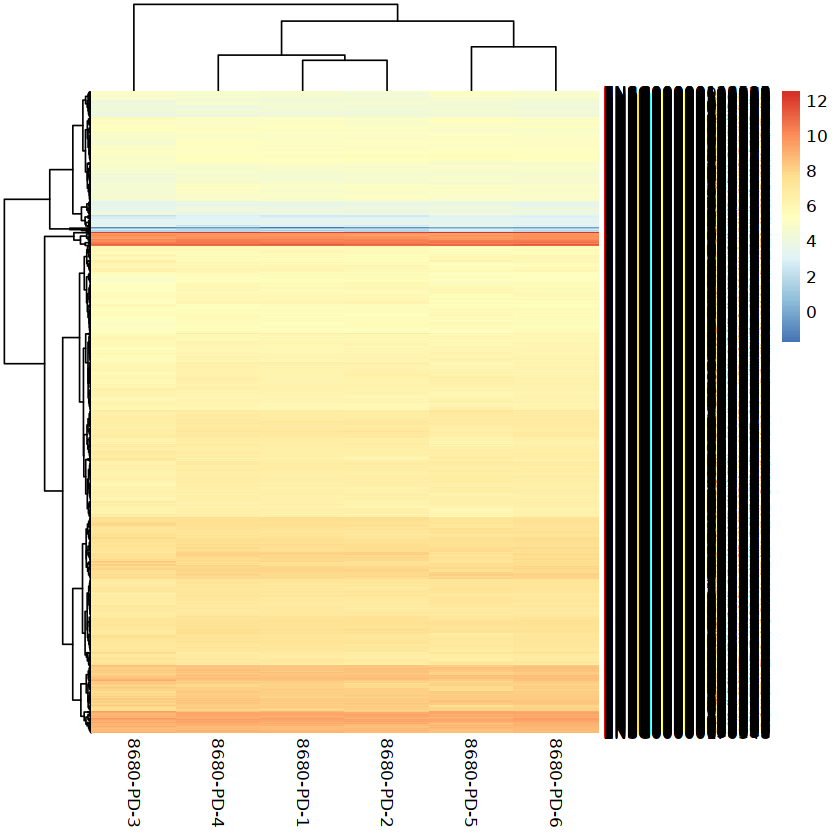

In [290]:
pheatmap::pheatmap(lcpm_filt[housekeeping,])

In [125]:
y1 <- y
y1$samples$group <- 1

In [126]:
y0 <- estimateDisp(y1[housekeeping,], trend="none", tagwise=FALSE)

Using classic mode.



In [127]:
y0$common.dispersion
sqrt(y0$common.dispersion)

[1] 0.01811346

[1] 0.1345863

In [128]:
y$common.dispersion <- y0$common.dispersion

In [131]:
design

grouppsi.0.BMP2- grouppsi.0.BMP2+ grouppsi.2.BMP2- grouppsi.2.BMP2+
8680-PD-1 1                0                0                0               
8680-PD-2 0                1                0                0               
8680-PD-3 0                0                1                0               
8680-PD-4 0                0                0                1               
8680-PD-5 0                0                0                0               
8680-PD-6 0                0                0                0               
          grouppsi.4.BMP2- grouppsi.4.BMP2+
8680-PD-1 0                0               
8680-PD-2 0                0               
8680-PD-3 0                0               
8680-PD-4 0                0               
8680-PD-5 1                0               
8680-PD-6 0                1

In [129]:
edgeR_fit <- glmFit(y, design)

In [130]:
lrt_psi0 <- glmLRT(edgeR_fit, contrast = c(-1,1,0,0,0,0))
lrt_psi2 <- glmLRT(edgeR_fit, contrast = c(0,0,-1,1,0,0))
lrt_psi4 <- glmLRT(edgeR_fit, contrast = c(0,0,0,0,-1,1))

In [132]:
summary(decideTests(lrt_psi0))
summary(decideTests(lrt_psi2))
summary(decideTests(lrt_psi4))

       -1*grouppsi.0.BMP2- 1*grouppsi.0.BMP2+
Down                                       98
NotSig                                  16406
Up                                        106

       -1*grouppsi.2.BMP2- 1*grouppsi.2.BMP2+
Down                                      873
NotSig                                  15476
Up                                        261

       -1*grouppsi.4.BMP2- 1*grouppsi.4.BMP2+
Down                                      282
NotSig                                  16208
Up                                        120

## Plots

In [133]:
plot_lrt_MA <- function(lrt, title) {
    topTags(lrt, n=Inf)$table %>%
        mutate(Sig = ifelse(FDR<0.05, ifelse(logFC>0, 'Up', 'Down'), 'NS')) %>%
        mutate(Sig = factor(Sig, levels=c('NS','Up','Down'))) %>%
        mutate(gene = ifelse(Sig!='NS' & external_gene_name!='.', external_gene_name, NA)) %>%
        arrange(Sig) %>%
        ggplot(aes(logCPM, logFC)) +
        geom_point(aes(color=Sig, size=Sig)) +
        ggrepel::geom_text_repel(aes(label=gene, color=Sig), max.overlaps=10, force=10, show.legend=FALSE) +
        scale_color_manual(values=c('gray','red','blue')) +
        scale_size_manual(values=c(0.5,1.5,1.5)) +
        theme_bw() +
        ggtitle(title) +
        theme(
            legend.position = 'top',
            title = element_text(size=14, face='bold', color='black'),
            axis.text = element_text(size=14, face='bold', color='black'),
            axis.title = element_text(size=14, face='bold', color='black'),
            legend.text = element_text(size=14, color='black'),
            legend.title = element_blank()
        )
}

In [611]:
svg(file.path(projdir, 'analyses', 'Plots', 'edgeR_LRT_MA_psi0.svg'))
plot_lrt_MA(lrt_psi0, '0 PSI')
dev.off()
#ggsave(file.path(projdir, 'analyses', 'Plots', 'edgeR_LRT_MA_psi0.png'), dpi=600)

Warning message:
“Removed 16490 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 97 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

In [612]:
svg(file.path(projdir, 'analyses', 'Plots', 'edgeR_LRT_MA_psi2.svg'))
plot_lrt_MA(lrt_psi2, '2 PSI')
dev.off()

Warning message:
“Removed 15760 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 833 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

In [613]:
svg(file.path(projdir, 'analyses', 'Plots', 'edgeR_LRT_MA_psi4.svg'))
plot_lrt_MA(lrt_psi4, '4 PSI')
dev.off()

Warning message:
“Removed 16382 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 208 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

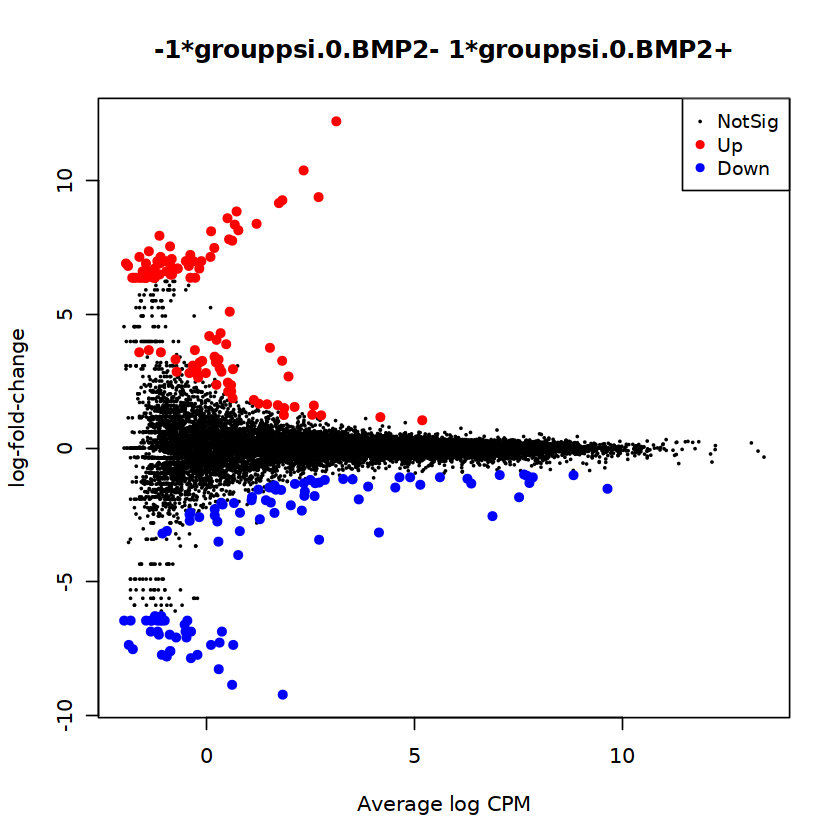

In [503]:
plotMD(lrt)

## Gene enrichment

In [134]:
go_psi0 <- goana(lrt_psi0, species='Hs', geneid = 'entrezgene_id')

In [138]:
kegg_psi0 <- kegga(lrt_psi0, species='Hs', geneid = 'entrezgene_id')

In [135]:
topGO(go_psi0, ont="BP", sort="Up", n=Inf, truncate=50) %>% dplyr::filter(P.Up<0.01)

Term                                               Ont N    Up Down
GO:0050773 regulation of dendrite development                 BP    80 3  0   
GO:0036164 cell-abiotic substrate adhesion                    BP     1 1  0   
GO:0021793 chemorepulsion of branchiomotor axon               BP     1 1  0   
GO:0002316 follicular B cell differentiation                  BP     1 1  0   
GO:0021644 vagus nerve morphogenesis                          BP     1 1  0   
GO:0021893 cerebral cortex GABAergic interneuron fate comm... BP     2 1  0   
GO:0032902 nerve growth factor production                     BP     2 1  0   
GO:0014737 positive regulation of muscle atrophy              BP     2 1  0   
GO:0021784 postganglionic parasympathetic fiber developmen... BP     2 1  0   
GO:0007168 receptor guanylyl cyclase signaling pathway        BP     2 1  0   
GO:0014878 response to electrical stimulus involved in reg... BP     2 1  0   
GO:0014873 response to muscle activity involved in regulat... BP     2 1  0   
GO:0021564 vagus nerve development                            BP     2 1  0   
GO:0007354 zygotic determination of anterior/posterior axi... BP     2 1  0   
GO:0060284 regulation of cell development                     BP   384 5  3   
GO:0045595 regulation of cell differentiation                 BP  1133 9  7   
GO:0071248 cellular response to metal ion                     BP   131 3  2   
GO:0021892 cerebral cortex GABAergic interneuron different... BP     3 1  0   
GO:0006032 chitin catabolic process                           BP     3 1  0   
GO:0006030 chitin metabolic process                           BP     3 1  0   
GO:0009631 cold acclimation                                   BP     3 1  0   
GO:0010621 negative regulation of transcription by transcr... BP     3 1  0   
GO:0032898 neurotrophin production                            BP     3 1  0   
GO:1902871 positive regulation of amacrine cell differenti... BP     3 1  0   
GO:0032224 positive regulation of synaptic transmission, c... BP     3 1  0   
GO:0014735 regulation of muscle atrophy                       BP     3 1  0   
GO:0050923 regulation of negative chemotaxis                  BP     3 1  0   
GO:0001878 response to yeast                                  BP     3 1  0   
           P.Up        P.Down    
GO:0050773 0.002034440 1.00000000
GO:0036164 0.003156158 1.00000000
GO:0021793 0.003156158 1.00000000
GO:0002316 0.003156158 1.00000000
GO:0021644 0.003156158 1.00000000
GO:0021893 0.006302581 1.00000000
GO:0032902 0.006302581 1.00000000
GO:0014737 0.006302581 1.00000000
GO:0021784 0.006302581 1.00000000
GO:0007168 0.006302581 1.00000000
GO:0014878 0.006302581 1.00000000
GO:0014873 0.006302581 1.00000000
GO:0021564 0.006302581 1.00000000
GO:0007354 0.006302581 1.00000000
GO:0060284 0.006942269 0.19291679
GO:0045595 0.007915971 0.15628056
GO:0071248 0.008109544 0.09433794
GO:0021892 0.009439297 1.00000000
GO:0006032 0.009439297 1.00000000
GO:0006030 0.009439297 1.00000000
GO:0009631 0.009439297 1.00000000
GO:0010621 0.009439297 1.00000000
GO:0032898 0.009439297 1.00000000
GO:1902871 0.009439297 1.00000000
GO:0032224 0.009439297 1.00000000
GO:0014735 0.009439297 1.00000000
GO:0050923 0.009439297 1.00000000
GO:0001878 0.009439297 1.00000000

In [141]:
topGO(go_psi0, ont="BP", sort="Up", n=Inf, truncate=50) %>% dplyr::filter(P.Down<0.01)

Term                                               Ont N    Up Down
GO:0051239 regulation of multicellular organismal process     BP  1893 11 16  
GO:0009628 response to abiotic stimulus                       BP   849  5 14  
GO:0072503 cellular divalent inorganic cation homeostasis     BP   202  2  5  
GO:0072507 divalent inorganic cation homeostasis              BP   220  2  5  
GO:0006875 cellular metal ion homeostasis                     BP   269  2  5  
GO:0048731 system development                                 BP  3034 12 20  
GO:0030003 cellular cation homeostasis                        BP   324  2  5  
GO:0055065 metal ion homeostasis                              BP   327  2  5  
GO:0048639 positive regulation of developmental growth        BP   111  1  3  
GO:0019722 calcium-mediated signaling                         BP   120  1  5  
GO:0070887 cellular response to chemical stimulus             BP  2117  8 16  
GO:0006935 chemotaxis                                         BP   393  2  7  
GO:0042330 taxis                                              BP   393  2  7  
GO:0042221 response to chemical                               BP  2743 10 19  
GO:0050920 regulation of chemotaxis                           BP   150  1  4  
GO:0006874 cellular calcium ion homeostasis                   BP   176  1  5  
GO:0019932 second-messenger-mediated signaling                BP   177  1  5  
GO:0055074 calcium ion homeostasis                            BP   189  1  5  
GO:0016477 cell migration                                     BP  1089  4 10  
GO:0009605 response to external stimulus                      BP  1734  6 17  
GO:0070371 ERK1 and ERK2 cascade                              BP   213  1  4  
GO:0002684 positive regulation of immune system process       BP   573  2  7  
GO:0010941 regulation of cell death                           BP  1236  4 11  
GO:0008219 cell death                                         BP  1596  5 15  
GO:0032103 positive regulation of response to external sti... BP   288  1  5  
GO:0019221 cytokine-mediated signaling pathway                BP   318  1  6  
GO:0009617 response to bacterium                              BP   366  1  6  
GO:0007186 G protein-coupled receptor signaling pathway       BP   375  1  6  
GO:0012501 programmed cell death                              BP  1478  4 15  
GO:0002376 immune system process                              BP  1694  4 14  
⋮          ⋮                                                  ⋮   ⋮    ⋮  ⋮   
GO:0071622 regulation of granulocyte chemotaxis               BP   37  0   2  
GO:0070098 chemokine-mediated signaling pathway               BP   39  0   4  
GO:1990869 cellular response to chemokine                     BP   46  0   4  
GO:1990868 response to chemokine                              BP   46  0   4  
GO:0071677 positive regulation of mononuclear cell migrati... BP   49  0   3  
GO:0002690 positive regulation of leukocyte chemotaxis        BP   65  0   3  
GO:0071621 granulocyte chemotaxis                             BP   77  0   3  
GO:0006090 pyruvate metabolic process                         BP   81  0   3  
GO:0002688 regulation of leukocyte chemotaxis                 BP   83  0   4  
GO:0071675 regulation of mononuclear cell migration           BP   88  0   3  
GO:0030278 regulation of ossification                         BP   91  0   3  
GO:0007204 positive regulation of cytosolic calcium ion co... BP   93  0   3  
GO:0097530 granulocyte migration                              BP   94  0   3  
GO:0050921 positive regulation of chemotaxis                  BP   98  0   3  
GO:0002687 positive regulation of leukocyte migration         BP  102  0   4  
GO:0048469 cell maturation                                    BP  107  0   3  
GO:0071456 cellular response to hypoxia                       BP  120  0   7  
GO:0036294 cellular response to decreased oxygen levels       BP  128  0   7  
GO:0030595 leukocyte chemotaxis                              

In [140]:
topKEGG(kegg_psi0, sort="Up", n=Inf, truncate=50) %>% dplyr::filter(P.Down<0.05)

Pathway                                            N   Up Down
hsa05410 Hypertrophic cardiomyopathy                         62 1  2   
hsa04066 HIF-1 signaling pathway                             86 1  4   
hsa04060 Cytokine-cytokine receptor interaction             144 1  5   
hsa00910 Nitrogen metabolism                                  8 0  1   
hsa00340 Histidine metabolism                                11 0  1   
hsa04924 Renin secretion                                     43 0  2   
hsa04061 Viral protein interaction with cytokine and cyt...  43 0  3   
hsa04972 Pancreatic secretion                                47 0  2   
hsa05134 Legionellosis                                       52 0  2   
hsa04925 Aldosterone synthesis and secretion                 63 0  2   
hsa04137 Mitophagy - animal                                  68 0  2   
hsa04928 Parathyroid hormone synthesis, secretion and ac...  84 0  2   
hsa04270 Vascular smooth muscle contraction                  84 0  2   
hsa04140 Autophagy - animal                                 133 0  3   
         P.Up      P.Down      
hsa05410 0.1876201 0.0278024535
hsa04066 0.2505894 0.0004573577
hsa04060 0.3836998 0.0003354167
hsa00910 1.0000000 0.0330478966
hsa00340 1.0000000 0.0451620331
hsa04924 1.0000000 0.0139656138
hsa04061 1.0000000 0.0007659613
hsa04972 1.0000000 0.0165409316
hsa05134 1.0000000 0.0200211093
hsa04925 1.0000000 0.0286378541
hsa04137 1.0000000 0.0329632814
hsa04928 1.0000000 0.0483534079
hsa04270 1.0000000 0.0483534079
hsa04140 1.0000000 0.0182426423

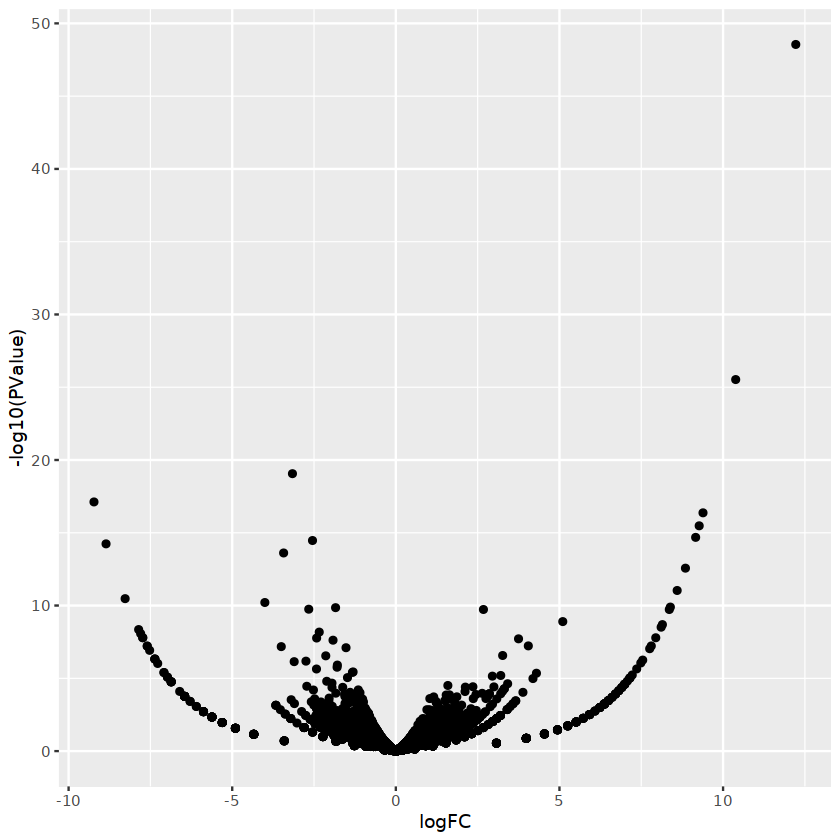

In [526]:
topTags(lrt, n=Inf)$table %>%
    ggplot(aes(logFC, -log10(PValue))) + geom_point()

## Save top tags

In [829]:
write_tsv(topTags(lrt_psi0, n=Inf)$table, file.path(projdir, 'analyses', 'lrt_psi0_topTags.tsv'))
write_tsv(topTags(lrt_psi2, n=Inf)$table, file.path(projdir, 'analyses', 'lrt_psi2_topTags.tsv'))
write_tsv(topTags(lrt_psi4, n=Inf)$table, file.path(projdir, 'analyses', 'lrt_psi4_topTags.tsv'))

# NOISeq

In [6]:
library(NOISeq)

Loading required package: splines

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘NOISeq’


The following object is masked from ‘package:edgeR’:

    rpkm




## Run NOISeq

In [6]:
phenoData <- y$samples
phenoData$group <- sapply(phenoData$group, function(i) gsub('+','.pos',i,fixed=TRUE))
phenoData$group <- sapply(phenoData$group, function(i) gsub('-','.neg',i,fixed=TRUE))
phenoData <- new("AnnotatedDataFrame", data=phenoData)
edata <- ExpressionSet(assayData = y$counts, phenoData = phenoData)

In [7]:
edata_full <- ExpressionSet(
    assayData = rsem %>% dplyr::select(!c('entrezgene_id','external_gene_name','description')) %>% column_to_rownames('gene_id') %>% as.matrix(), 
    phenoData = phenoData
)

In [8]:
noiseq_psi0_all <- noiseq(
    edata_full, 
    factor="group", 
    condition=c('psi.0.BMP2.pos','psi.0.BMP2.neg'), 
    k=NULL, 
    norm="tmm", 
    pnr=0.2, nss=5, v=0.02, lc=1, replicates="no"
)

In [112]:
noiseq_psi2_all <- noiseq(
    edata_full, 
    factor="group", 
    condition=c('psi.2.BMP2.pos','psi.2.BMP2.neg'), 
    k=NULL, 
    norm="tmm", 
    pnr=0.2, nss=5, v=0.02, lc=1, replicates="no"
)

[1] "Computing (M,D) values..."
[1] "Computing probability of differential expression..."


In [113]:
noiseq_psi4_all <- noiseq(
    edata_full, 
    factor="group", 
    condition=c('psi.4.BMP2.pos','psi.4.BMP2.neg'), 
    k=NULL, 
    norm="tmm", 
    pnr=0.2, nss=5, v=0.02, lc=1, replicates="no"
)

[1] "Computing (M,D) values..."
[1] "Computing probability of differential expression..."


In [135]:
noiseq_psi4_all@results[[1]] %>% drop_na() %>% dim()

[1] 26257     6

In [7]:
#save(noiseq_psi0_all, noiseq_psi2_all, noiseq_psi4_all, file = file.path(projdir, 'noiseq_all.RData'))
load(file.path(projdir, 'noiseq_all.RData'))

In [10]:
head(noiseq_psi0_all@results[[1]])

psi.0.BMP2.pos_mean psi.0.BMP2.neg_mean M           D        
ENSG00000000003 1484.140234         1526.049306         -0.04017416  41.90907
ENSG00000000005          NA                  NA                  NA        NA
ENSG00000000419 1332.625022         1466.473808         -0.13808042 133.84879
ENSG00000000457  311.004909          367.764135         -0.24184344  56.75923
ENSG00000000460  784.157676          878.738602         -0.16429030  94.58093
ENSG00000000938    7.088431            9.165461         -0.37074117   2.07703
                prob      ranking    
ENSG00000000003 0.1778651  -41.909091
ENSG00000000005        NA    0.000000
ENSG00000000419 0.4672068 -133.848857
ENSG00000000457 0.5941518  -56.759741
ENSG00000000460 0.4872573  -94.581069
ENSG00000000938 0.3146379   -2.109859

In [85]:
noiseq_psi0 <- noiseq(edata, factor="group", condition=c('psi.0.BMP2.pos','psi.0.BMP2.neg'), k=NULL, norm="tmm", pnr=0.2, nss=5, v=0.02, lc=1, replicates="no")

[1] "Computing (M,D) values..."
[1] "Computing probability of differential expression..."


In [86]:
noiseq_psi2 <- noiseq(edata, factor="group", condition=c('psi.2.BMP2.pos','psi.2.BMP2.neg'), k=NULL, norm="tmm", pnr=0.2, nss=5, v=0.02, lc=1, replicates="no")

[1] "Computing (M,D) values..."
[1] "Computing probability of differential expression..."


In [87]:
noiseq_psi4 <- noiseq(edata, factor="group", condition=c('psi.4.BMP2.pos','psi.4.BMP2.neg'), k=NULL, norm="tmm", pnr=0.2, nss=5, v=0.02, lc=1, replicates="no")

[1] "Computing (M,D) values..."
[1] "Computing probability of differential expression..."


In [115]:
save(noiseq_psi0, noiseq_psi2, noiseq_psi4, file = file.path(projdir, 'noiseq.RData'))

In [116]:
noiseq_psi0_all


Summary 1 

You are comparing psi.0.BMP2.pos - psi.0.BMP2.neg from group 

                psi.0.BMP2.pos_mean psi.0.BMP2.neg_mean         M         D
ENSG00000285976           569.73264           0.5728413  9.957934 569.15980
ENSG00000269955           159.48970           0.5728413  8.121112 158.91686
ENSG00000107159            46.96086         419.3198544 -3.158521 372.35900
ENSG00000280987            11.51870         124.8794102 -3.438486 113.36071
ENSG00000288534            79.74485           0.5728413  7.121112  79.17201
ENSG00000289027            73.54247           0.5728413  7.004298  72.96963
                     prob    ranking
ENSG00000285976 0.9999980  569.24690
ENSG00000269955 0.9992367  159.12423
ENSG00000107159 0.9978423 -372.37239
ENSG00000280987 0.9969548 -113.41285
ENSG00000288534 0.9936754   79.49162
ENSG00000289027 0.9921019   73.30503

Normalization
	method: tmm 
	k: 0.5 
	lc: 1 

You are working with simulated replicates:
	pnr: 0.2 
	nss: 5 
	v: 0.02 

## NOISeq fgsea

In [8]:
library(fgsea)
library(clusterProfiler)
library(ReactomePA)
library(enrichplot)



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProf

In [9]:
process_noiseq_res <- function(res, thresh) {
    res[which(res$prob>thresh),] %>%
        rownames_to_column('ensembl_gene_id') %>%
        left_join(y$genes, by=c('ensembl_gene_id'='gene_id')) %>%
        relocate(c(contains('gene'), 'description')) %>%
        arrange(M)
}

In [10]:
noiseq_psi0_all_rank <- process_noiseq_res(noiseq_psi0_all@results[[1]], 0) %>% 
    drop_na() %>% 
    dplyr::filter(entrezgene_id != '.') %>% 
    dplyr::select(entrezgene_id, ranking) %>% 
    distinct() %>% 
    deframe() %>%
    sort(decreasing=TRUE)

In [11]:
noiseq_psi2_all_rank <- process_noiseq_res(noiseq_psi2_all@results[[1]], 0) %>% 
    drop_na() %>% 
    dplyr::filter(entrezgene_id != '.') %>% 
    dplyr::select(entrezgene_id, ranking) %>% 
    distinct() %>% 
    deframe() %>%
    sort(decreasing=TRUE)

In [12]:
noiseq_psi4_all_rank <- process_noiseq_res(noiseq_psi4_all@results[[1]], 0) %>% 
    drop_na() %>% 
    dplyr::filter(entrezgene_id != '.') %>% 
    dplyr::select(entrezgene_id, ranking) %>% 
    distinct() %>% 
    deframe() %>%
    sort(decreasing=TRUE)

In [13]:
noiseq_ranks <- list(
    psi0 = noiseq_psi0_all_rank,
    psi2 = noiseq_psi2_all_rank,
    psi4 = noiseq_psi4_all_rank
)

In [14]:
noiseq_all_reactome <- compareCluster(noiseq_ranks, fun=gsePathway, organism='human', eps=0)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (12.74% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.73% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.74% of the list).
The order of those tied genes will be arbi

In [15]:
noiseq_all_reactome <- setReadable(noiseq_all_reactome, OrgDb = 'org.Hs.eg.db', keyType = 'ENTREZID')

In [1]:
dotplot(noiseq_all_reactome, label_format=50, showCategory=15)

ERROR: Error in dotplot(noiseq_all_reactome, label_format = 50, showCategory = 15): could not find function "dotplot"


In [377]:
as.data.frame(noiseq_all_reactome) %>%
    dplyr::filter(p.adjust<0.05) %>%
    dplyr::filter(grepl('Translation',Description,fixed=TRUE))

Cluster ID           Description                          setSize
1 psi2    R-HSA-72766  Translation                          285    
2 psi2    R-HSA-156842 Eukaryotic Translation Elongation     89    
3 psi2    R-HSA-192823 Viral mRNA Translation                85    
4 psi2    R-HSA-72613  Eukaryotic Translation Initiation    113    
5 psi2    R-HSA-72737  Cap-dependent Translation Initiation 113    
6 psi2    R-HSA-72764  Eukaryotic Translation Termination    89    
7 psi4    R-HSA-156842 Eukaryotic Translation Elongation     89    
  enrichmentScore NES       pvalue       p.adjust     qvalue       rank
1  0.7382414       1.925379 5.232463e-08 1.214803e-05 8.968625e-06 2194
2  0.8368935       1.974257 4.278527e-05 8.514268e-04 6.285896e-04 1547
3  0.8279338       1.952353 4.599541e-05 8.776932e-04 6.479815e-04 1547
4  0.7900875       1.898412 5.388098e-05 9.470109e-04 6.991572e-04 1547
5  0.7900875       1.898412 5.388098e-05 9.470109e-04 6.991572e-04 1547
6  0.8341211       1.967717 5.889265e-05 9.884031e-04 7.297161e-04 1547
7 -0.8749610      -1.826402 1.517116e-04 1.504919e-02 1.331666e-02 1327
  leading_edge                  
1 tags=61%, list=16%, signal=53%
2 tags=74%, list=11%, signal=66%
3 tags=73%, list=11%, signal=65%
4 tags=67%, list=11%, signal=60%
5 tags=67%, list=11%, signal=60%
6 tags=74%, list=11%, signal=66%
7 tags=90%, list=9%, signal=82% 
  core_enrichment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
1 EEF1A1/EIF4A1/EIF5/RPL15/SEC61A1/RPN1/WARS1/RPS3A/RPLP0/EIF3B/RPS6/DDOST/IARS1/RPS2/SRP14/ETF1/RPL27/RPS27A/RPS7/RPL6/RPL8/EEF1B2/RPL19/EIF3I/EEF1G/RPLP1/TUFM/RPS14/SSR3/RPL4/RPL35/KARS1/RPL5/RPL41/RPL9/SSR2/RPS26/RPL3/RPS10/MRPL15/RPL17/HARS1/YARS1/MRPL51/RPS8/MARS1/RPL10A/RPS23/RPS4X/TARS1/RPL7/VARS1/RPSA/GARS1/RPN2/SARS1/RARS1/RPS13/RPL35A/EEF2/RPL13A/SPCS1/RPS3/EIF4H/MRPS6/MRPL3/RPL32/RPS5/AARS1/EIF4G1/RPS16/SEC61B/RPL36AL/RPS19/RPL24/SRPRB/SRPRA/SRP68/SPCS2/RPL18/RPL18A/EIF4B/MRPL49/RPS15/MRPL13/RPS11/MRPS7/RPS20/RPS15A/RPS17/EIF3D/EIF3M/EIF3L/TRMT112/PPA2/DAP3/FARSB/RPL23A/PPA1/MRPL20/MRPL14/RPL21/APEH/MRPS16/RPL27A/RPS18/UBA52/MRPS23/MRPL22/EPRS1/MRPL28/SEC11A/AURKAIP1/MRPL27/MRPL37/RPL39/MRPS24/EIF4EBP1/RPL36/MRPL39/RPL10/MRPL47/RPL29/MRPL38/FARSA/GSPT1/EIF3K/MRPS15/MRPS18C/RPL38/MRPL52/RPL30/RPL26/GADD45GIP1/EIF2B1/ERAL1/MRPS10/RPL26L1/RPL14/EIF2B3/RPL7A/RPL37A/RPLP2/MRPS18B/MRPL11/MRPS34/EIF3G/QARS1/AIMP2/RARS2/RPL13/MRPL12/MRPL43/RPL23/MRPS27/MRPL16/MRPL21/MRPL34/RPS9/MRPS18A/MRPL44/MRPS11/SEC11C/RPS27L/EEF1D/MRPL23/MRPL4/MRPL18/RPS25/SSR4/EIF3F/RPL37/CARS1/RPL31/SRP9
2 EEF1A1/RPL15/RPS3A/RPLP0/RPS6/RPS2/RPL27/RPS27A/RPS7/RPL6/RPL8/EEF1B2/RPL19/EEF1G/RPLP1/RPS14/RPL4/RPL35/RPL5/RPL41/RPL9/RPS26/RPL3/RPS10/RPL17/RPS8/RPL10A/RPS23/RPS4X/RPL7/RPSA/RPS13/RPL35A/EEF2/RPL13A/RPS3/RPL32/RPS5/RPS16/RPL36AL/RPS19/RPL24/RPL18/RPL18A/RPS15/RPS11/RPS20/RPS15A/RPS17/RPL23A/RPL21/RPL27A/RPS18/UBA52/RPL39/RPL36/RPL10/RPL29/RPL38/RPL30/RPL26/RPL26L1/RPL14/RPL7A/RPL37A/RPLP2                         

In [362]:
reactome_df <- as.data.frame(noiseq_all_reactome) %>%
    dplyr::filter(p.adjust<0.05) %>%
    group_by(Cluster, sign(NES)) %>%
    #dplyr::slice_max(abs(NES), n=15) %>%
    arrange(NES) %>%
    mutate(Description = factor(Description, levels = unique(Description)))

In [380]:
reactome_df %>%
    dplyr::filter(Cluster=='psi4')

Cluster ID           
1  psi4    R-HSA-380108 
2  psi4    R-HSA-445095 
3  psi4    R-HSA-156902 
4  psi4    R-HSA-373076 
5  psi4    R-HSA-156842 
6  psi4    R-HSA-2408557
7  psi4    R-HSA-500792 
8  psi4    R-HSA-446203 
9  psi4    R-HSA-948021 
10 psi4    R-HSA-199977 
11 psi4    R-HSA-112314 
12 psi4    R-HSA-112316 
13 psi4    R-HSA-71387  
14 psi4    R-HSA-170834 
15 psi4    R-HSA-8856688
16 psi4    R-HSA-2132295
17 psi4    R-HSA-977225 
18 psi4    R-HSA-6811434
19 psi4    R-HSA-9020956
20 psi4    R-HSA-8984722
21 psi4    R-HSA-112315 
22 psi4    R-HSA-70326  
23 psi4    R-HSA-70171  
24 psi4    R-HSA-1566948
25 psi4    R-HSA-9634597
26 psi4    R-HSA-418555 
27 psi4    R-HSA-70263  
   Description                                                     setSize
1  Chemokine receptors bind chemokines                              23    
2  Interaction between L1 and Ankyrins                              19    
3  Peptide chain elongation                                         85    
4  Class A/1 (Rhodopsin-like receptors)                             98    
5  Eukaryotic Translation Elongation                                89    
6  Selenocysteine synthesis                                         89    
7  GPCR ligand binding                                             147    
8  Asparagine N-linked glycosylation                               268    
9  Transport to the Golgi and subsequent modification              160    
10 ER to Golgi Anterograde Transport                               137    
11 Neurotransmitter receptors and postsynaptic signal transmission 132    
12 Neuronal System                                                 236    
13 Metabolism of carbohydrates                                     237    
14 Signaling by TGF-beta Receptor Complex                           91    
15 Golgi-to-ER retrograde transport                                116    
16 MHC class II antigen presentation                                97    
17 Amyloid fiber formation                                          60    
18 COPI-dependent Golgi-to-ER retrograde traffic                    84    
19 Interleukin-27 signaling                                         10    
20 Interleukin-35 Signalling                                        11    
21 Transmission across Chemical Synapses                           170    
22 Glucose metabolism                                               77    
23 Glycolysis                                                       62    
24 Elastic fibre formation                                          36    
25 GPER1 signaling                                                  35    
26 G alpha (s) signalling events                                    73    
27 Gluconeogenesis                                                  25    
   enrichmentScore NES       pvalue       p.adjust    qvalue      rank
1  -0.9821612      -2.103382 5.463849e-06 0.002984121 0.002640575   15
2  -0.9223450      -1.932497 8.338377e-04 0.043019850 0.038067211   18
3  -0.8749815      -1.865283 3.300709e-04 0.019990816 0.017689383 1327
4  -0.8709884      -1.853750 1.204655e-05 0.002984121 0.002640575   15
5  -0.8749610      -1.826402 1.517116e-04 0.015049186 0.013316656 1327
6  -0.8624823      -1.800354 4.873912e-04 0.027157436 0.024030950 1327
7  -0.7865105      -1.726280 2.939179e-04 0.019496556 0.017252025   15
8   0.7330708       1.523951 1.499558e-05 0.002984121 0.002640575 1420
9   0.7513067       1.528371 1.432734e-04 0.015049186 0.013316656 1615
10  0.7662516       1.541274 1.713581e-04 0.015049186 0.013316656 1395
11  0.7690886       1.547047 3.236375e-04 0.019990816 0.017689383  890
12  0.7496041       1.555397 7.298163e-06 0.002984121 0.002640575  923
13  0.7501934       1.556586 1.204311e-05 0.002984121 0.002640575 1357
14  0.7899110       1.563961 4.338087e-04 0.025178980 0.022280262  860
15  0.7859266       1.573748 1.556776e-04 0.015049186 0.013316656 1280
16  0.7946626       1.577375 2.052653e-04 0.015049186 0.013316656 1

In [363]:
reactome_df %>% dplyr::filter(grepl('NRF2', Description, fixed=TRUE))

Cluster ID Description setSize enrichmentScore NES pvalue p.adjust qvalue
     rank leading_edge core_enrichment sign(NES)

In [63]:
reactome_df_genes_ens <- unique(y$genes$gene_id[y$genes$entrezgene_id %in% unique(unlist(reactome_path2ID[reactome_df$ID], use.names=FALSE))])

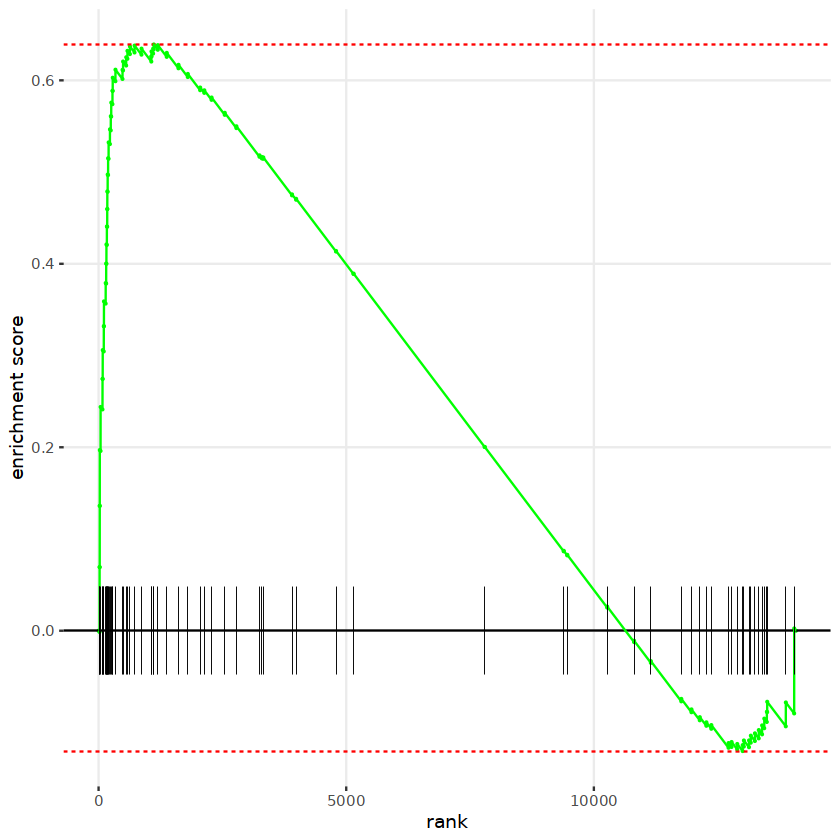

In [78]:
plotEnrichment(reactome_path2ID[['R-HSA-9759194']], stats=noiseq_psi0_all_rank)

In [177]:
reactome_counts_mat <- lcpm_filt[lcpm_filt[[1]] %in% reactome_df_genes_ens,-1]
reactome_counts_mat <- reactome_counts_mat %>% distinct() %>% as.data.frame()
rownames(reactome_counts_mat) <- lcpm_filt[[1]][lcpm_filt[[1]] %in% reactome_df_genes_ens]

In [193]:
get_reactome_gene_pos <- function(ID) {
    as.factor(rownames(reactome_counts_mat) %in% rsem$gene_id[match(reactome_path2ID[[ID]], rsem$entrezgene_id)])
}

In [355]:
anno_row <- data.frame(
    NFE2L2 = get_reactome_gene_pos('R-HSA-9759194'),
    ECM_Deg = get_reactome_gene_pos('R-HSA-3000171'),
    Translation = get_reactome_gene_pos('R-HSA-156842'),
    WNT = get_reactome_gene_pos('R-HSA-3858494')
)
rownames(anno_row) <- rownames(reactome_counts_mat)

In [356]:
anno_colors$RUNX1 <- c('FALSE'='white', 'TRUE'='black')
anno_colors$NFE2L2 <- c('FALSE'='white', 'TRUE'='black')
anno_colors$ECM_Deg <- c('FALSE'='white', 'TRUE'='black')
anno_colors$Translation <- c('FALSE'='white', 'TRUE'='black')
anno_colors$WNT <- c('FALSE'='white', 'TRUE'='black')

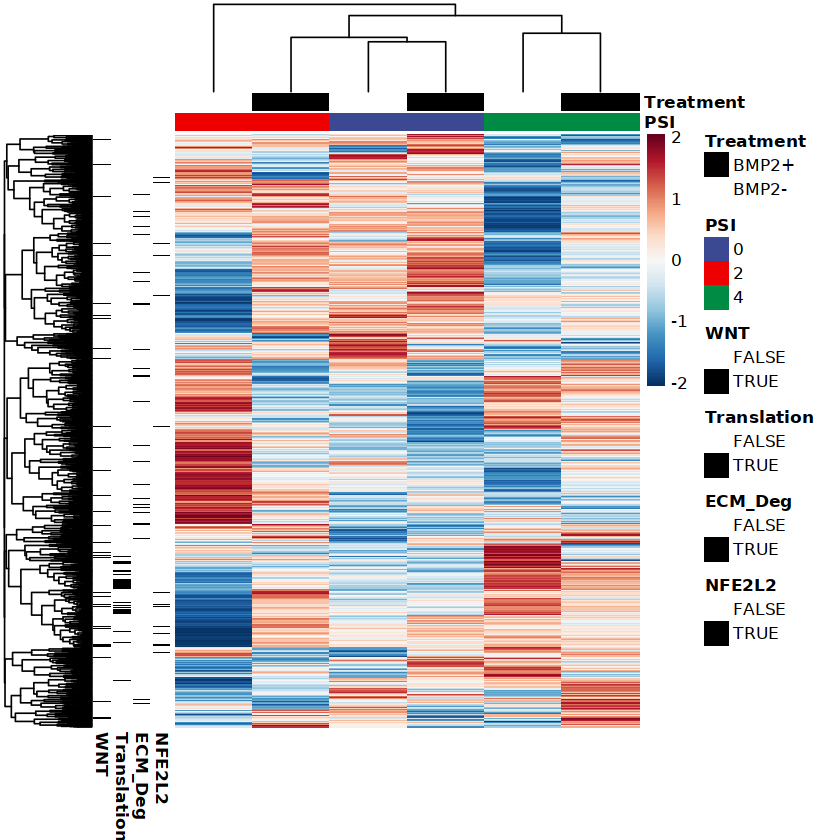

In [357]:
pheatmap::pheatmap(
    reactome_counts_mat, 
    scale='row',
    #clustering_method = 'ward.D2',
    show_rownames = FALSE,
    show_colnames = FALSE,
    annotation_col = anno_col,
    annotation_row = anno_row,
    annotation_colors = anno_colors,
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200)
)

In [378]:
selected_terms <- c(
    'Elastic fibre formation',
    'Signaling by TGF-beta Receptor Complex',
    'Eukaryotic Translation Elongation',
    'Nuclear events mediated by NFE2L2',
    'Signaling by TGF-beta Receptor Complex',
    "Hedgehog 'on' state",
    'Beta-catenin independent WNT signaling',
    'Degradation of the extracellular matrix',
    'Cell-cell junction organization',
    'Gap junction assembly',
    'Transport of connexons to the plasma membrane',
    'Glycolysis',
    'Gluconeogenesis'
)

In [379]:
svg(file.path(projdir, 'analyses', 'Plots', 'noiseq_reactome_gsea_dotplot.svg'), width=7, height=5)
reactome_df %>%
    mutate(Cluster = ifelse(Cluster=='psi0', '0 PSI', ifelse(Cluster=='psi2', '2 PSI', '4 PSI'))) %>%
    dplyr::filter(Description %in% selected_terms) %>%
    ggplot(aes(Cluster, Description)) +
    geom_point(aes(color=NES), size=4) +
    scale_color_distiller(palette='RdBu') +
    theme_bw() + labs(x=NULL, y=NULL) +
    theme(
        axis.text = element_text(color='black', size=12)
    )
dev.off()

png 
  2

In [163]:
noiseq_psi0_all_reactome <- fgsea(reactome_path2ID, noiseq_psi0_all_rank, eps=0, minSize=5, maxSize=500)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (12.74% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”


In [164]:
noiseq_psi2_all_reactome <- fgsea(reactome_path2ID, noiseq_psi2_all_rank, eps=0, minSize=5, maxSize=500)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.73% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”


In [165]:
noiseq_psi4_all_reactome <- fgsea(reactome_path2ID, noiseq_psi4_all_rank, eps=0, minSize=5, maxSize=500)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.74% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”


In [166]:
noiseq_psi0_all_reactome %>% 
    dplyr::filter(padj<0.05) %>% 
    arrange(NES) %>%
    mutate(name = gsub('Homo sapiens: ', '', reactome_ID2name[pathway], fixed=TRUE))

pathway       pval         padj       log2err   ES        NES      size
1 R-HSA-3000171 1.565181e-05 0.01697183 0.5756103 0.9014242 2.125990 54  
2 R-HSA-1442490 1.954154e-05 0.01697183 0.5756103 0.9158867 2.148471 48  
  leadingEdge  name                                  
1 1277, 12.... Non-integrin membrane-ECM interactions
2 1277, 12.... Collagen degradation

In [169]:
noiseq_psi2_all_reactome %>% 
    dplyr::filter(padj<0.05) %>% 
    arrange(NES) %>%
    mutate(name = gsub('Homo sapiens: ', '', reactome_ID2name[pathway], fixed=TRUE)) %>%
    tail()

pathway       pval         padj         log2err   ES        NES      size
1 R-HSA-9755511 6.979398e-07 9.330919e-05 0.6594444 0.8638400 2.019143  97 
2 R-HSA-8939236 3.408448e-07 6.582091e-05 0.6749629 0.8696889 2.024987  91 
3 R-HSA-5689603 2.532545e-07 5.501953e-05 0.6749629 0.8721560 2.034855  92 
4 R-HSA-9759194 1.969474e-06 2.090838e-04 0.6272567 0.8844700 2.034940  76 
5 R-HSA-9010553 1.725860e-09 1.022191e-06 0.7881868 0.8391201 2.051829 158 
6 R-HSA-376176  6.896788e-10 1.022191e-06 0.8012156 0.8203739 2.077526 196 
  leadingEdge 
1 7316, 74....
2 7316, 57....
3 60, 7316....
4 7316, 57....
5 7316, 57....
6 7316, 57....
  name                                                                      
1 KEAP1-NFE2L2 pathway                                                      
2 RUNX1 regulates transcription of genes involved in differentiation of HSCs
3 UCH proteinases                                                           
4 Nuclear events mediated by NFE2L2                                         
5 Regulation of expression of SLITs and ROBOs                               
6 Signaling by ROBO receptors

In [171]:
noiseq_psi4_all_reactome %>% 
    dplyr::filter(padj<0.05) %>% 
    arrange(NES) %>%
    mutate(name = gsub('Homo sapiens: ', '', reactome_ID2name[pathway], fixed=TRUE)) 

pathway       pval         padj         log2err   ES         NES       size
1  R-HSA-380108  6.970774e-08 0.0001211521 0.7049757 -0.9821612 -1.939253  23 
2  R-HSA-380994  6.149418e-04 0.0356256259 0.4772708 -0.9374118 -1.861512  27 
3  R-HSA-156902  9.959426e-05 0.0110023590 0.5384341 -0.8749815 -1.847138  85 
4  R-HSA-373076  3.016458e-05 0.0065532549 0.5756103 -0.8709884 -1.828573  98 
5  R-HSA-192823  3.118597e-04 0.0225838387 0.4984931 -0.8576911 -1.810637  85 
6  R-HSA-156842  4.539111e-05 0.0071717958 0.5573322 -0.8749610 -1.800375  89 
7  R-HSA-375276  1.998203e-04 0.0156525968 0.5188481 -0.8870627 -1.781631  58 
8  R-HSA-2408557 1.282326e-04 0.0120907985 0.5188481 -0.8624823 -1.774698  89 
9  R-HSA-72689   7.680548e-04 0.0417149751 0.4772708 -0.8248133 -1.725637  95 
10 R-HSA-72764   6.681941e-04 0.0374619770 0.4772708 -0.8372468 -1.722771  89 
11 R-HSA-500792  3.719474e-04 0.0239423931 0.4984931 -0.7865105 -1.715311 147 
12 R-HSA-948021  1.374341e-04 0.0120907985 0.5188481  0.7513067  1.511880 160 
13 R-HSA-446203  1.013006e-05 0.0026006017 0.5933255  0.7330708  1.521862 268 
14 R-HSA-199977  1.253955e-04 0.0120907985 0.5188481  0.7662516  1.523457 137 
15 R-HSA-112314  3.699198e-04 0.0239423931 0.4984931  0.7690886  1.529656 132 
16 R-HSA-112316  2.021902e-06 0.0011713553 0.6272567  0.7496041  1.545152 236 
17 R-HSA-71387   3.613120e-06 0.0012559205 0.6272567  0.7501934  1.546417 237 
18 R-HSA-6807878 5.697973e-04 0.0341485445 0.4772708  0.7881793  1.546700  89 
19 R-HSA-170834  1.391346e-04 0.0120907985 0.5188481  0.7899110  1.546988  91 
20 R-HSA-977225  5.414653e-04 0.0336095217 0.4772708  0.8135615  1.549666  60 
21 R-HSA-8856688 4.483295e-05 0.0071717958 0.5573322  0.7859266  1.551296 116 
22 R-HSA-6811434 2.071402e-04 0.0156525968 0.5188481  0.8012514  1.560277  84 
23 R-HSA-2132295 8.544919e-05 0.0106079063 0.5384341  0.7946626  1.565555  97 
24 R-HSA-112315  3.239674e-06 0.0012559205 0.6272567  0.7884811  1.587271 170 
25 R-HSA-9020956 3.492505e-04 0.0239423931 0.4984931  0.9700214  1.600638  10 
26 R-HSA-70326   5.421639e-05 0.0078523404 0.5573322  0.8273245  1.604000  77 
27 R-HSA-8984722 2.048269e-04 0.0156525968 0.5188481  0.9696732  1.606867  11 
28 R-HSA-70171   6.145919e-05 0.0082166210 0.5384341  0.8428328  1.610478  62 
29 R-HSA-1566948 1.012875e-04 0.0110023590 0.5384341  0.8852004  1.625081  36 
30 R-HSA-9634597 4.519293e-05 0.0071717958 0.5573322  0.8944083  1.637324  35 
31 R-HSA-418555  1.047423e-05 0.0026006017 0.5933255  0.8582213  1.660802  73 
32 R-HSA-70263   1.908978e-06 0.0011713553 0.6272567  0.9511052  1.699262  25 
   leadingEdge 
1  3576, 29....
2    3576, 6347
3  1915, 62....
4  3576, 29....
5  6233, 61....
6  1915, 62....
7  3576, 29....
8  6233, 61....
9  6233, 61....
10 6233, 61....
11 3576, 29....
12 10484, 1....
13 7316, 82....
14 10484, 1....
15 5573, 10....
16 54407, 3....
17 2023, 25....
18 10376, 1....
19 3688, 50....
20 567, 731....
21 10376, 1....
22 10376, 1....
23 1213, 82....
24 54407, 3....
25 821, 677....
26 2023, 25....
27 821, 677....
28 2023, 25....
29 3688, 23....
30 3688, 23....
31 3688, 23....
32 2023, 25....
   name                                                             
1  Chemokine receptors bind chemokines                              
2  ATF4 activates genes in response to endoplasmic reticulum  stress
3  Peptide chain elongation                                         
4  Class A/1 (Rhodopsin-like receptors)                             
5  Viral mRNA Translation                                           
6  Eukaryotic Translation Elongation                                
7  Peptide ligand-binding receptors                                 
8  Selenocysteine synthesis                                         
9  Formation of a pool of free 40S subunits                         
10 Eukaryotic Translation Termination                               
11 GPCR ligand binding                                              
12 Transport to the Golgi and subsequent

In [126]:
process_noiseq_res(noiseq_psi0_all@results[[1]], 0.9)

ensembl_gene_id entrezgene_id       external_gene_name
1  ENSG00000285238 .                   .                 
2  ENSG00000254721 .                   .                 
3  ENSG00000239704 284040              CDRT4             
4  ENSG00000286192 .                   .                 
5  ENSG00000254692 .                   .                 
6  ENSG00000196826 .                   .                 
7  ENSG00000284874 .                   .                 
8  ENSG00000254806 .                   SYS1-DBNDD2       
9  ENSG00000213648 445329,124907837    SULT1A4           
10 ENSG00000280987 9782                MATR3             
11 ENSG00000107159 768                 CA9               
12 ENSG00000162496 9249                DHRS3             
13 ENSG00000288542 .                   .                 
14 ENSG00000157470 145773              FAM81A            
15 ENSG00000273217 .                   .                 
16 ENSG00000165507 11067               DEPP1             
17 ENSG00000290731 .                   .                 
18 ENSG00000228748 .                   .                 
19 ENSG00000270181 100533467           BIVM-ERCC5        
20 ENSG00000187951 100288637           .                 
21 ENSG00000171388 8862                APLN              
22 ENSG00000255730 .                   .                 
23 ENSG00000165071 137835              TMEM71            
24 ENSG00000216285 .                   .                 
25 ENSG00000289316 .                   .                 
26 ENSG00000161958 2256                FGF11             
27 ENSG00000104419 10397               NDRG1             
28 ENSG00000049249 3604                TNFRSF9           
29 ENSG00000143847 8497                PPFIA4            
30 ENSG00000247095 100506211           MIR210HG          
⋮  ⋮               ⋮                   ⋮                 
65 ENSG00000059377 6916                TBXAS1            
66 ENSG00000132182 23225               NUP210            
67 ENSG00000262967 .                   .                 
68 ENSG00000259332 100528021           ST20-MTHFS        
69 ENSG00000166436 9866                TRIM66            
70 ENSG00000284707 .                   .                 
71 ENSG00000288684 .                   .                 
72 ENSG00000076770 55796               MBNL3             
73 ENSG00000140479 5046                PCSK6             
74 ENSG00000232527 100996732,107985200 LINC02802         
75 ENSG00000270276 554313              H4C15             
76 ENSG00000264668 .                   .                 
77 ENSG00000255152 .                   MSH5-SAPCD1       
78 ENSG00000256966 .                   .                 
79 ENSG00000197943 5336                PLCG2             
80 ENSG00000286235 .                   .                 
81 ENSG00000242852 163051              ZNF709            
82 ENSG00000290908 .                   .                 
83 ENSG00000264443 .                   NCMAP-DT          
84 ENSG00000202198 .                   7SK               
85 ENSG00000254732 .                   .                 
86 ENSG00000259171 .                   .                 
87 ENSG00000170667 10156,100271927     RASA4B            
88 ENSG00000283239 104266957           KBTBD11-OT1       
89 ENSG00000285000 .                   .                 
90 ENSG00000279232 .                   .                 
91 ENSG00000289027 .                   .                 
92 ENSG00000288534 .                   .                 
93 ENSG00000269955 100996928           FMC1-LUC7L2       
94 ENSG00000285976 .                   .                 
   description                                                                            
1  novel transcript                                                                       
2  novel transcript                                                                       
3  CMT1A duplicated region transcript 4 [Source:HGNC Symbol;Acc:HGNC:14383]               
4  Novel protein                           

## Get DE Genes

In [16]:
noiseq_psi0_all.deg <- degenes(noiseq_psi0_all, q=0.9, M=NULL)

[1] "94 differentially expressed features"


In [17]:
noiseq_psi2_all.deg <- degenes(noiseq_psi2_all, q=0.9, M=NULL)

[1] "444 differentially expressed features"


In [18]:
noiseq_psi4_all.deg <- degenes(noiseq_psi4_all, q=0.9, M=NULL)

[1] "174 differentially expressed features"


In [83]:
process_noiseq_res(noiseq_psi0_all@results[[1]], 0.9) %>% dplyr::filter(external_gene_name != '.') %>% head()

ensembl_gene_id entrezgene_id    external_gene_name
1 ENSG00000239704 284040           CDRT4             
2 ENSG00000254806 .                SYS1-DBNDD2       
3 ENSG00000213648 445329,124907837 SULT1A4           
4 ENSG00000280987 9782             MATR3             
5 ENSG00000107159 768              CA9               
6 ENSG00000162496 9249             DHRS3             
  description                                                                
1 CMT1A duplicated region transcript 4 [Source:HGNC Symbol;Acc:HGNC:14383]   
2 SYS1-DBNDD2 readthrough (NMD candidate) [Source:HGNC Symbol;Acc:HGNC:33535]
3 sulfotransferase family 1A member 4 [Source:HGNC Symbol;Acc:HGNC:30004]    
4 matrin 3 [Source:NCBI gene (formerly Entrezgene);Acc:9782]                 
5 carbonic anhydrase 9 [Source:HGNC Symbol;Acc:HGNC:1383]                    
6 dehydrogenase/reductase 3 [Source:HGNC Symbol;Acc:HGNC:17693]              
  psi.0.BMP2.pos_mean psi.0.BMP2.neg_mean M         D         prob     
1  0.4430269           36.66185           -6.370741  36.21882 0.9559073
2  3.5442155           58.42982           -4.043167  54.88560 0.9829764
3  3.5442155           41.24458           -3.540666  37.70036 0.9586594
4 11.5187003          124.87941           -3.438486 113.36071 0.9969548
5 46.9608552          419.31985           -3.158521 372.35900 0.9978423
6  4.4302694           38.95321           -3.136276  34.52294 0.9492122
  ranking   
1  -36.77484
2  -55.03432
3  -37.86626
4 -113.41285
5 -372.37239
6  -34.66511

## Make plots

[1] "444 differentially expressed features"


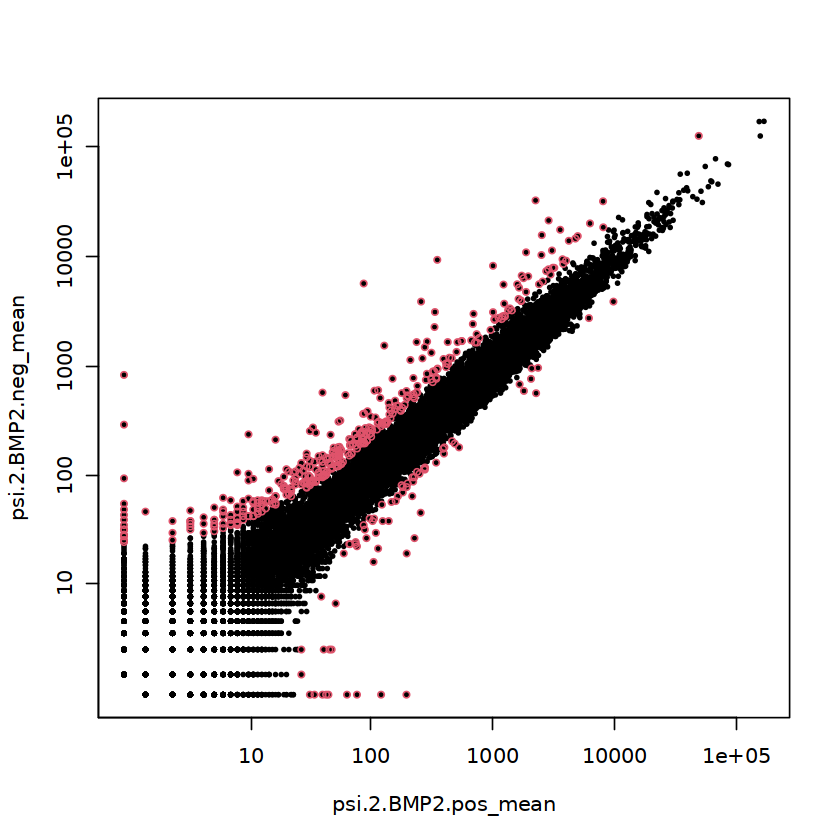

In [19]:
DE.plot(noiseq_psi2_all, q=0.9, graphic="expr", log.scale=TRUE)

[1] "444 differentially expressed features"


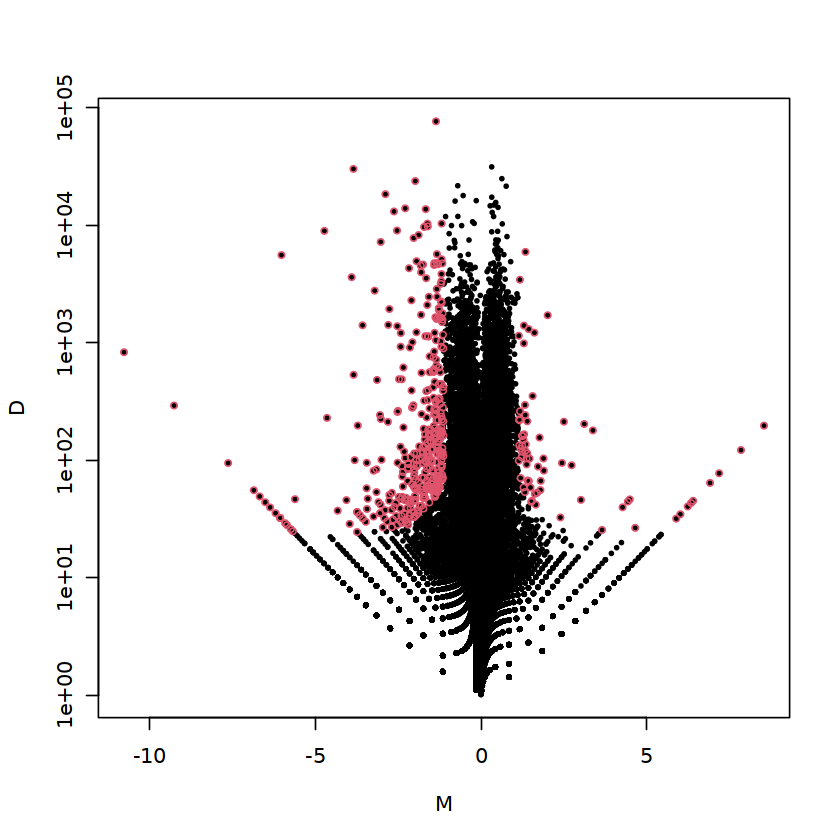

In [85]:
DE.plot(noiseq_psi2_all, q=0.9, graphic="MD", log.scale=TRUE)

In [137]:
make_MD_plot <- function(res, title, up, down) {
    res %>%
        mutate(sig = ifelse(prob>=0.9, ifelse(M>0, up, down), 'NS')) %>%
        mutate(sig = factor(sig, levels=c('NS',up,down))) %>%
        mutate(label = ifelse(sig!='NS' & external_gene_name!='.', external_gene_name, NA)) %>%
        arrange(sig) %>%
        ggplot(aes(M, log10(D+1))) +
        geom_point(aes(color=sig), size=0.5) +
        ggrepel::geom_text_repel(
            data=. %>% dplyr::filter(M>0), 
            aes(label=label, color=sig), 
            show.legend = FALSE,
            max.overlaps=8, force=15, nudge_x = 1.5
        ) +
        ggrepel::geom_text_repel(
            data=. %>% dplyr::filter(M<0), 
            aes(label=label, color=sig), 
            show.legend = FALSE,
            max.overlaps=8, force=15, nudge_x = -1.5
        ) +
        scale_color_manual(values=c('gray','firebrick','dodgerblue')) +
        theme_bw() +
        guides(color = guide_legend(override.aes = list(size = 2))) +
        ggtitle(title) +
        theme(
            title = element_text(face='bold'),
            axis.text = element_text(color='black', size=12),
            legend.text = element_text(size=12),
            legend.title = element_blank(),
            legend.position = 'top',
            axis.title = element_text(color='black', face='bold', size=12)
        )
}

In [140]:
svg(file.path(projdir, 'analyses', 'Plots', 'noiseq_psi0_all_MD.svg'))
make_MD_plot(
    res = process_noiseq_res(noiseq_psi0_all@results[[1]], 0),
    title = '0 PSI',
    up = 'BMP+',
    down = 'BMP-'
)
dev.off()

Warning message:
“Removed 13696 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 11759 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

In [141]:
svg(file.path(projdir, 'analyses', 'Plots', 'noiseq_psi2_all_MD.svg'))
make_MD_plot(
    res = process_noiseq_res(noiseq_psi2_all@results[[1]], 0),
    title = '2 PSI',
    up = 'BMP+',
    down = 'BMP-'
)
dev.off()
#ggsave(file.path(projdir, 'analyses', 'Plots', 'noiseq_psi2_all_MD.svg'))

Warning message:
“Removed 11793 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 12986 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 27 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 288 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

In [142]:
svg(file.path(projdir, 'analyses', 'Plots', 'noiseq_psi4_all_MD.svg'))
make_MD_plot(
    res = process_noiseq_res(noiseq_psi4_all@results[[1]], 0),
    title = '4 PSI',
    up = 'BMP+',
    down = 'BMP-'
)
dev.off()

Warning message:
“Removed 12655 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 13494 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 20 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 52 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


png 
  2

## ORA

In [26]:
noiseq_psi0_all.deg.gobp <- enrichGO(
    gene = rownames(noiseq_psi0_all.deg), 
    universe = unique(rownames(noiseq_psi0_all@results[[1]])),
    OrgDb = 'org.Hs.eg.db', ont='BP', keyType='ENSEMBL'
)

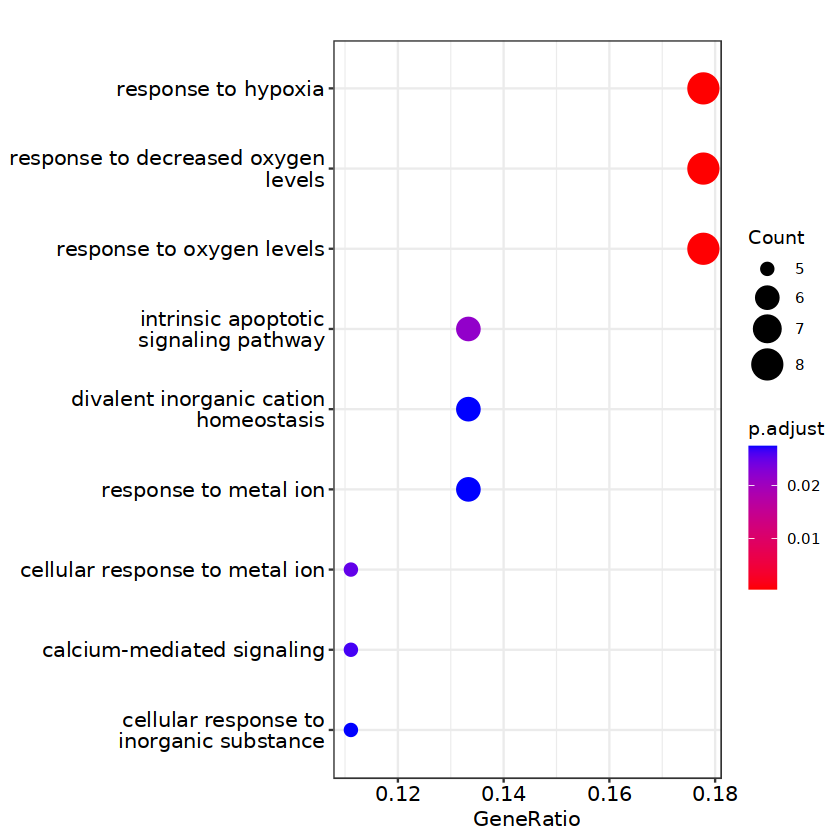

In [33]:
dotplot(noiseq_psi0_all.deg.gobp, showCategory=15)

In [34]:
noiseq_psi2_all.deg.gobp <- enrichGO(
    gene = rownames(noiseq_psi2_all.deg), 
    universe = unique(rownames(noiseq_psi2_all@results[[1]])),
    OrgDb = 'org.Hs.eg.db', ont='BP', keyType='ENSEMBL'
)

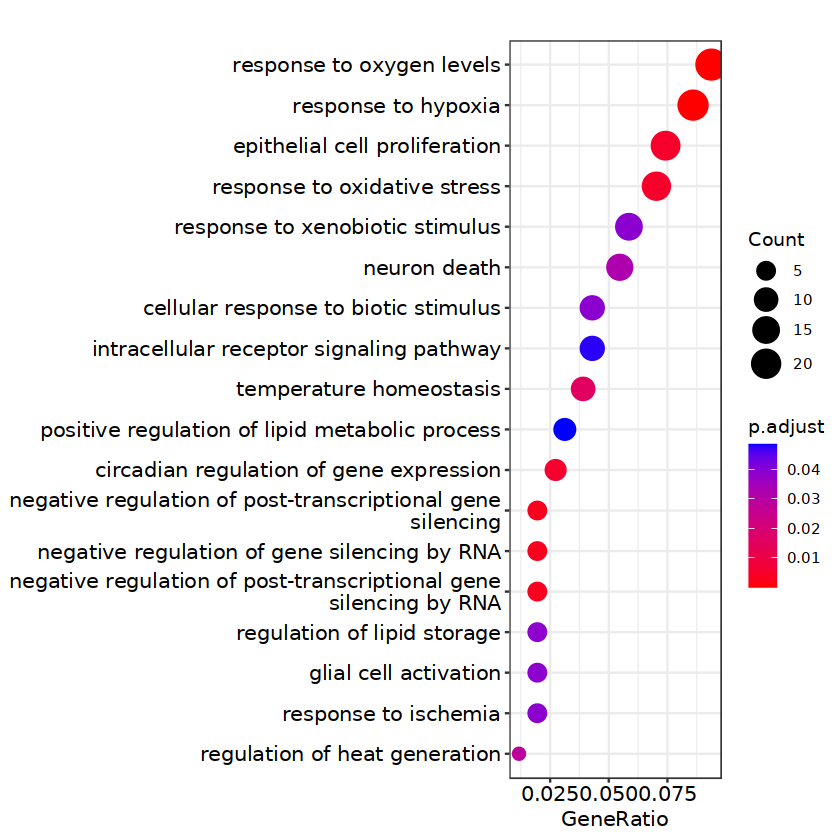

In [40]:
dotplot(gofilter(noiseq_psi2_all.deg.gobp, 4), showCategory=20, label_format=50)

In [41]:
noiseq_psi4_all.deg.gobp <- enrichGO(
    gene = rownames(noiseq_psi4_all.deg), 
    universe = unique(rownames(noiseq_psi4_all@results[[1]])),
    OrgDb = 'org.Hs.eg.db', ont='BP', keyType='ENSEMBL'
)

In [48]:
noiseq_psi4_all.deg.reactome <- enrichPathway(
    gene = y$genes$entrezgene_id[match(rownames(noiseq_psi4_all.deg), y$genes$gene_id)], 
    universe = y$genes$entrezgene_id[match(unique(rownames(noiseq_psi4_all@results[[1]])), y$genes$gene_id)],
    organism = 'human'
)

In [44]:
noiseq_psi4_all.deg.gobp

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 BP 
#...@keytype 	 ENSEMBL 
#...@gene 	 chr [1:174] "ENSG00000288825" "ENSG00000288859" "ENSG00000277150" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...0 enriched terms found
#...Citation
 T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu.
 clusterProfiler 4.0: A universal enrichment tool for interpreting omics data.
 The Innovation. 2021, 2(3):100141 


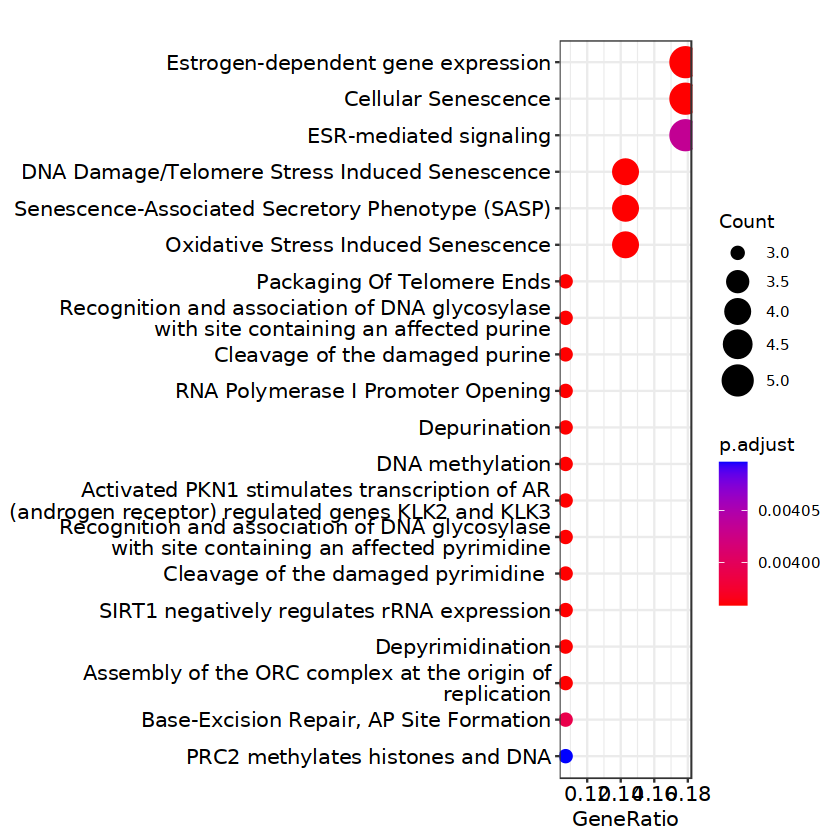

In [51]:
dotplot(noiseq_psi4_all.deg.reactome, showCategory=20, label_format=50)

# GSVA

In [22]:
gsva_reactome <- gsva(lcpm_filt_entrez, reactome_path2ID, min.sz=10, max.sz=500)

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”


Estimating GSVA scores for 1393 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



In [23]:
ssgsea_reactome <- gsva(lcpm_filt_entrez, reactome_path2ID, min.sz=10, max.sz=500, method='ssgsea')

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”


Estimating ssGSEA scores for 1393 gene sets.
[1] "Calculating ranks..."


Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”


[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


## GSVA fold changes

In [811]:
gsva_reactome_df <- as.data.frame(gsva_reactome)
gsva_reactome_df$psi0 <- gsva_reactome[,2] - gsva_reactome[,1]
gsva_reactome_df$psi2 <- gsva_reactome[,4] - gsva_reactome[,3]
gsva_reactome_df$psi4 <- gsva_reactome[,6] - gsva_reactome[,5]

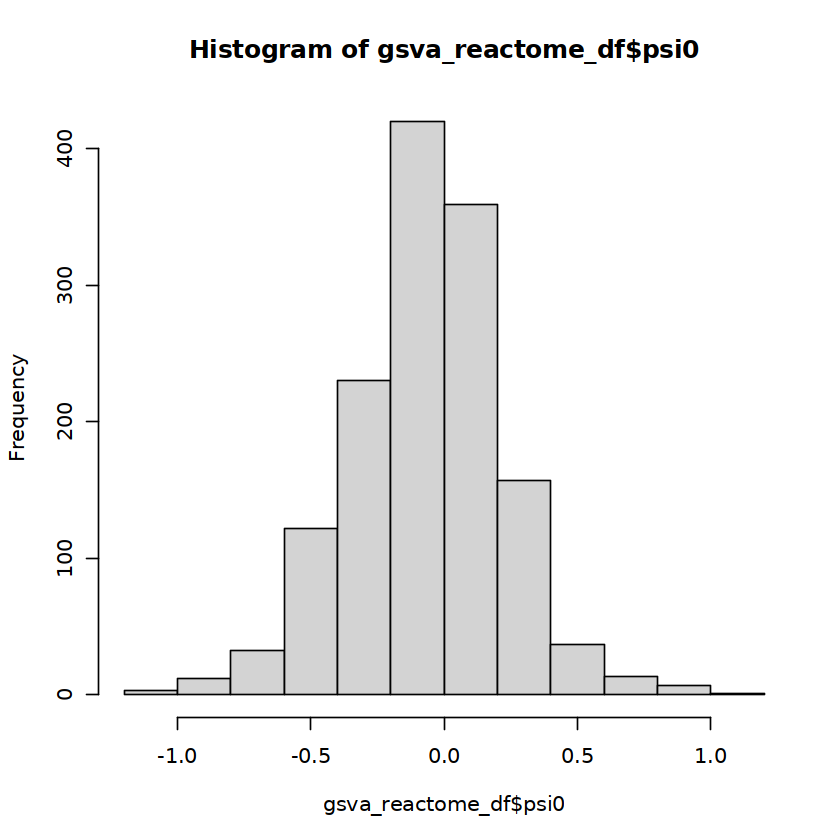

In [812]:
hist(gsva_reactome_df$psi0)

In [813]:
sig_reactome_fc <- gsva_reactome_df %>%
    dplyr::select(psi0,psi2,psi4) %>%
    mutate_all(scale) %>%
    rownames_to_column('reactome') %>%
    pivot_longer(!reactome, names_to='psi', values_to='GSVA') %>%
    dplyr::filter(abs(GSVA)>=3) %>%
    pull(reactome) %>%
    unique()

In [814]:
reactome_ID2name[sig_reactome_fc]

$`R-HSA-390247`
[1] "Homo sapiens: Beta-oxidation of very long chain fatty acids"

$`R-HSA-9706369`
[1] "Homo sapiens: Negative regulation of FLT3"

$`R-HSA-2514853`
[1] "Homo sapiens: Condensation of Prometaphase Chromosomes"

$`R-HSA-2564830`
[1] "Homo sapiens: Cytosolic iron-sulfur cluster assembly"

$`R-HSA-2453902`
[1] "Homo sapiens: The canonical retinoid cycle in rods (twilight vision)"

$`R-HSA-2691230`
[1] "Homo sapiens: Signaling by NOTCH1 HD Domain Mutants in Cancer"

$`R-HSA-2691232`
[1] "Homo sapiens: Constitutive Signaling by NOTCH1 HD Domain Mutants"

$`R-HSA-2468052`
[1] "Homo sapiens: Establishment of Sister Chromatid Cohesion"

$`R-HSA-5083635`
[1] "Homo sapiens: Defective B3GALTL causes PpS"

$`R-HSA-5173214`
[1] "Homo sapiens: O-glycosylation of TSR domain-containing proteins"

$`R-HSA-191273`
[1] "Homo sapiens: Cholesterol biosynthesis"

$`R-HSA-392170`
[1] "Homo sapiens: ADP signalling through P2Y purinoceptor 12"

$`R-HSA-5607763`
[1] "Homo sapiens: CLEC7A (Dectin-1) induces NFAT activation"

$`R-HSA-75035`
[1] "Homo sapiens: Chk1/Chk2(Cds1) mediated inactivation of Cyclin B:Cdk1 complex"

$`R-HSA-5579029`
[1] "Homo sapiens: Metabolic disorders of biological oxidation enzymes"

$`R-HSA-9768759`
[1] "Homo sapiens: Regulation of NPAS4 gene expression"

$`R-HSA-140837`
[1] "Homo sapiens: Intrinsic Pathway of Fibrin Clot Formation"

$`R-HSA-199220`
[1] "Homo sapiens: Vitamin B5 (pantothenate) metabolism"

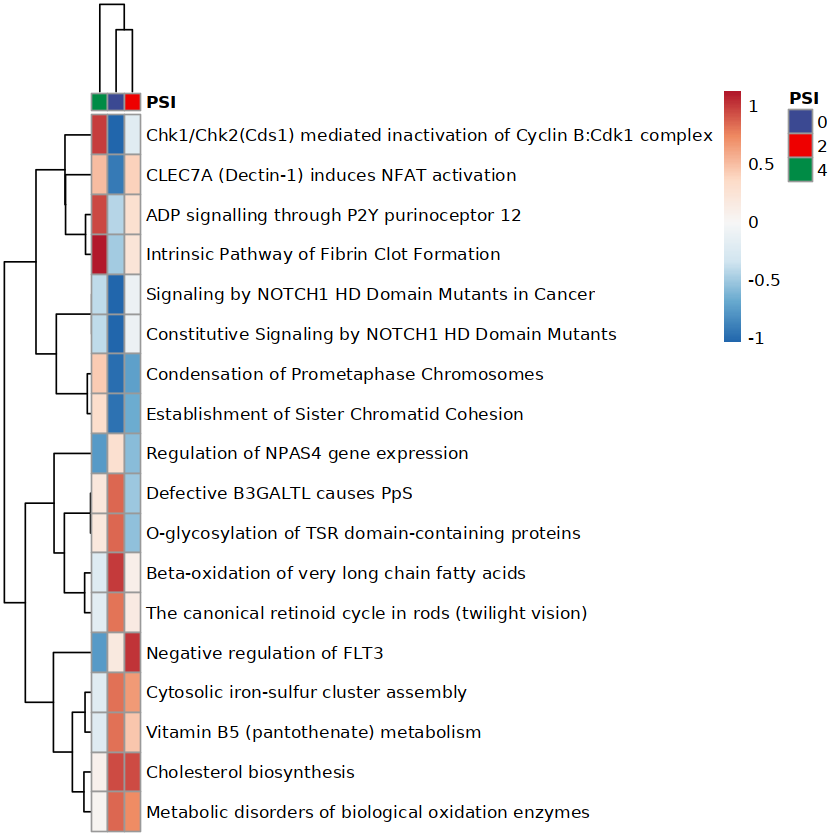

In [818]:
mat <- as.matrix(gsva_reactome_df[sig_reactome_fc,paste0('psi',c(0,2,4))])
rownames(mat) <- gsub('Homo sapiens: ', '', reactome_ID2name[sig_reactome_fc])

paletteLength <- 200

myBreaks <- c(seq(min(mat), 0, length.out=ceiling(paletteLength/2) + 1), 
              seq(max(mat)/paletteLength, max(mat), length.out=floor(paletteLength/2)))

reactome_diff_hmp <- pheatmap::pheatmap(
    mat,
    scale = 'none', 
    #cellwidth=30, cellheight=12,
    clustering_method = 'complete',
    annotation_col = data.frame(PSI = as.factor(c(0,2,4)), row.names=paste0('psi',c(0,2,4))),
    annotation_colors = anno_colors,
    show_colnames = FALSE,
    show_rownames = TRUE,
    #fontfamily = 'Arial',
    #color = colorRampPalette(hcl.colors(20, 'Berlin'))(paletteLength),
    #color = colorRampPalette(c('green','black','red'))(200),
    breaks = myBreaks,
    color = colorRampPalette(rev(brewer.pal(7,'RdBu')))(paletteLength)
)

In [823]:
svg(file.path(projdir, 'analyses', 'Plots', 'reactome_diff_hmp.svg'), width=8, height=6)
reactome_diff_hmp
dev.off()

png 
  2

## Hippo only

In [667]:
gsva_hippo <- gsva(lcpm_filt, list(hippo_combo = hippo_combo_ens, hippo_ens = signaling_by_hippo_ens))

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”


Estimating GSVA scores for 2 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



In [674]:
svg(file.path(projdir, 'analyses', 'Plots', 'hippo_combo_gsva_bar.svg'), width=5, height=4)
barplot(gsva_hippo[1,], main = 'Hippo signaling pathway', las=2, names=paste0(rep(paste0('psi',c(0,2,4)), each=2), c('-','+')))
dev.off()

png 
  2

In [675]:
svg(file.path(projdir, 'analyses', 'Plots', 'hippo_reactome_gsva_bar.svg'), width=5, height=4)
barplot(gsva_hippo[2,], main = 'Hippo signaling pathway', las=2, names=paste0(rep(paste0('psi',c(0,2,4)), each=2), c('-','+')))
dev.off()

png 
  2

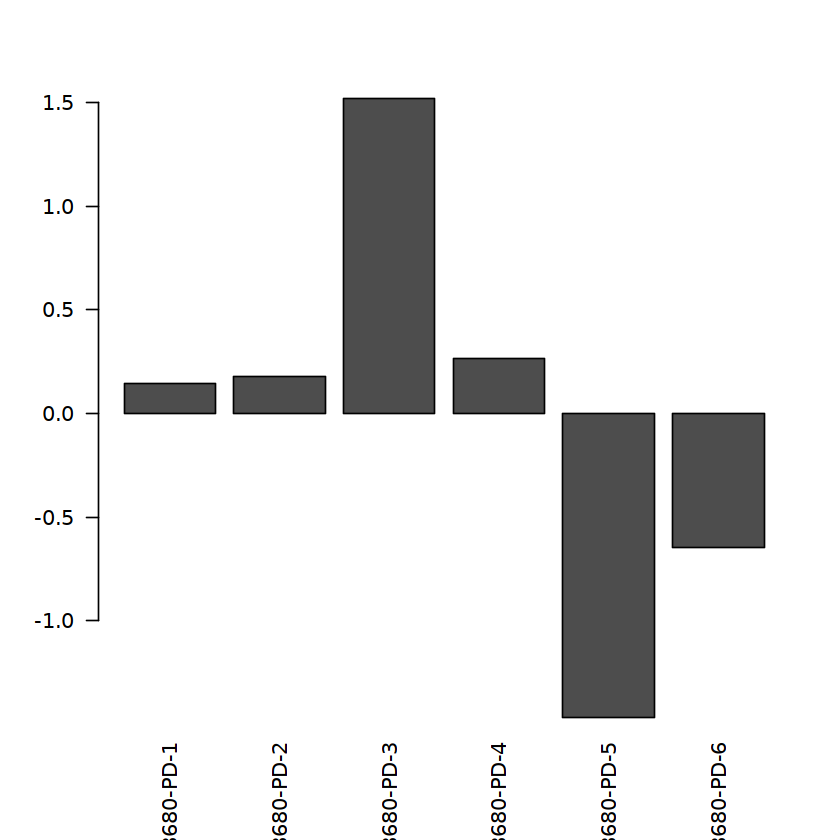

In [38]:
barplot(t(scale(ssgsea_reactome['R-HSA-2028269',])), las=2)

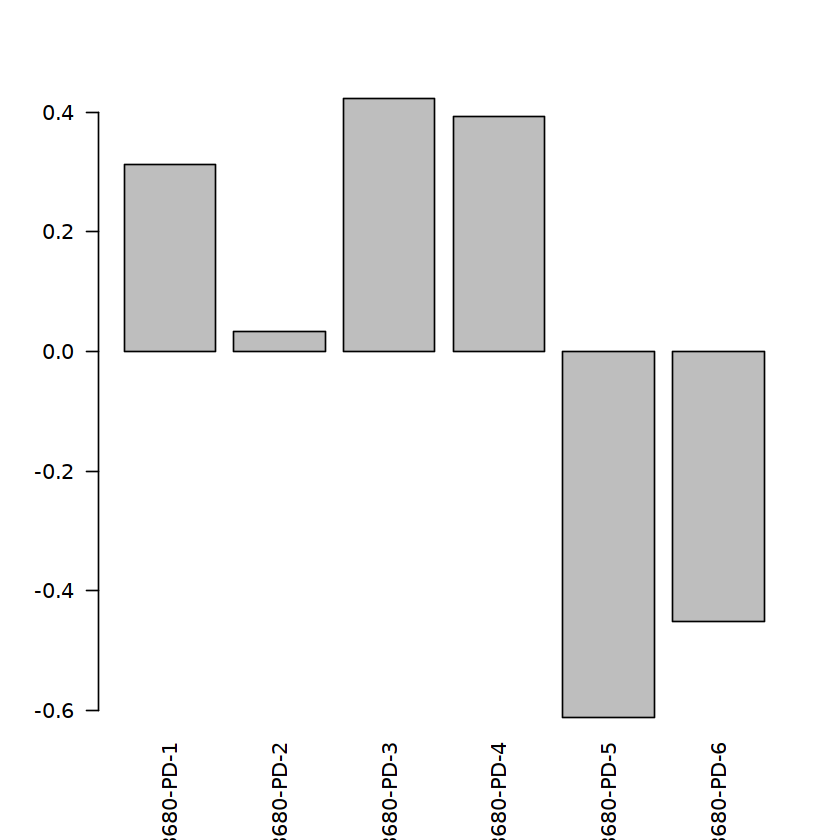

In [26]:
barplot(gsva_reactome['R-HSA-2028269',], las=2)

## SMAD

In [80]:
gsva_SMAD <- gsva(
    lcpm_filt_entrez, 
    list(
        SMAD_reactome = reactome_path2ID[['R-HSA-2173793']],
        SMAD_GO = unname(go_all_genes[['GO:0060395']])
    )
)

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”


Estimating GSVA scores for 2 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



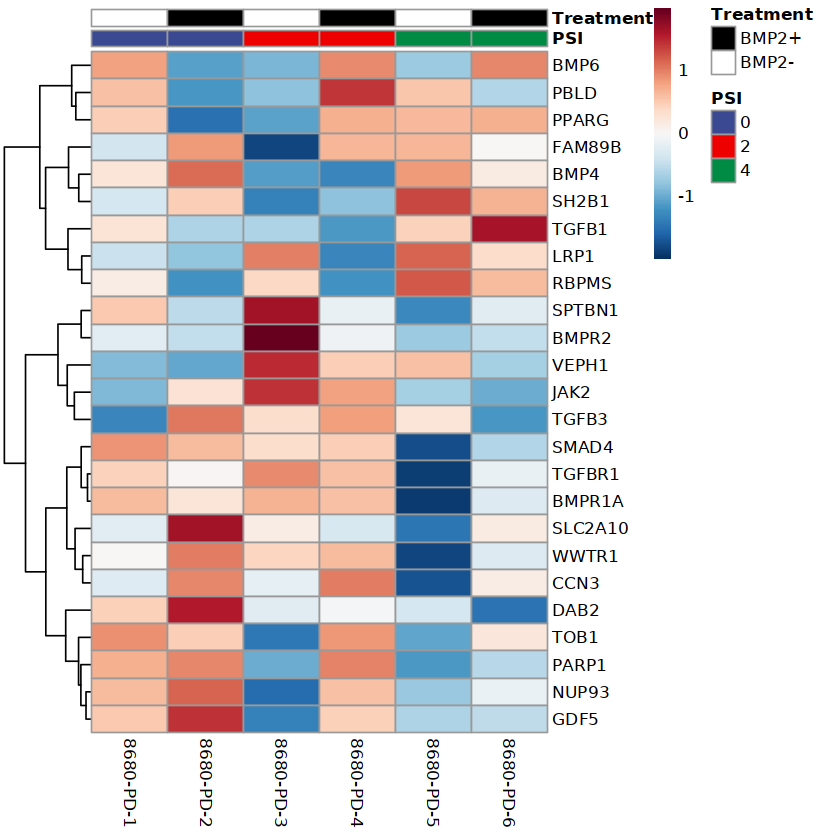

In [95]:
#GO_smad_genes <- intersect(rownames(lcpm_filt_entrez), unname(go_all_genes[['GO:0060395']]))
GO_smad_genes <- intersect(rownames(lcpm_filt_entrez), unname(go_all_genes[['GO:0060390']]))
GO_smad_mat <- lcpm_filt_entrez[GO_smad_genes,]
rownames(GO_smad_mat) <- gene_data$external_gene_name[match(rownames(GO_smad_mat), gene_data$entrezgene_id)]

pheatmap::pheatmap(
    GO_smad_mat,
    scale = 'row',
    clustering_method = 'ward.D2',
    cluster_col = FALSE,
    annotation_col = anno_col, annotation_colors = anno_colors,
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200)
)

In [81]:
length(unname(go_all_genes[['GO:0060395']]))
length(reactome_path2ID[['R-HSA-2173793']])

[1] 109

[1] 51

In [666]:
svg(file.path(projdir, 'analyses', 'Plots', 'smad_reactome_gsva_bar.svg'), width=5, height=4)
barplot(gsva_SMAD[1,], main = 'Transcriptional activity of\nSMAD2/SMAD3:SMAD4 heterotrimer', las=2, names=paste0(rep(paste0('psi',c(0,2,4)), each=2), c('-','+')))
dev.off()

png 
  2

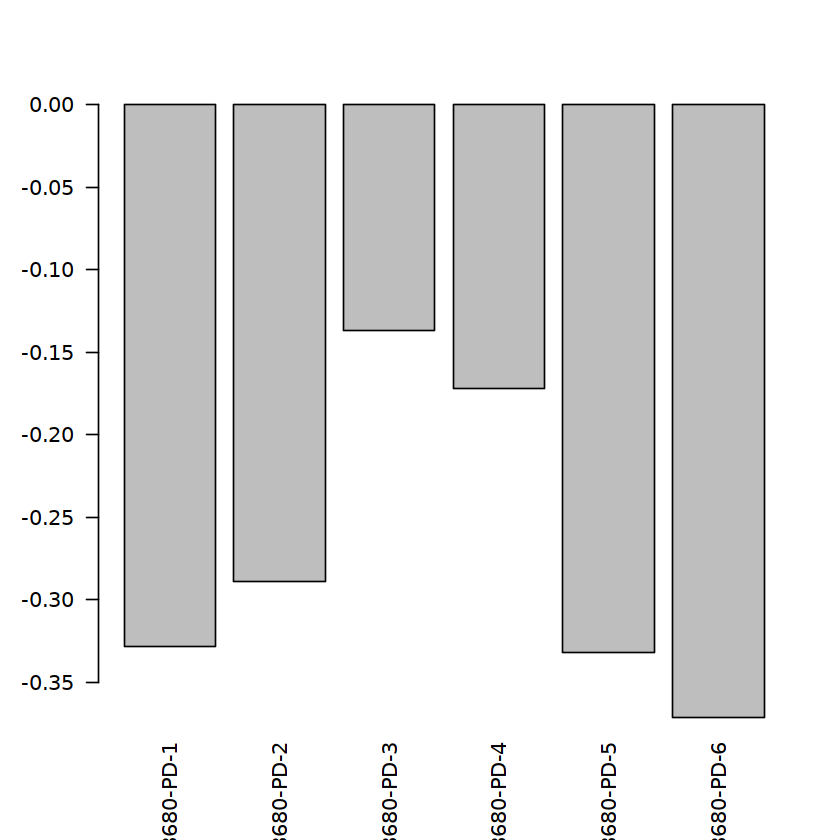

In [82]:
barplot(gsva_SMAD[2,], las=2)

In [459]:
smad_combo_counts <- lcpm_filt_entrez[intersect(rownames(lcpm_filt_entrez), unique(c(reactome_path2ID[['R-HSA-2173793']], go_all_genes[['GO:0060395']]))),]

smad_combo_lfc <- as.data.frame(smad_combo_counts)

smad_combo_lfc$psi0 <- smad_combo_counts[,2] - smad_combo_counts[,1]
smad_combo_lfc$psi2 <- smad_combo_counts[,4] - smad_combo_counts[,3]
smad_combo_lfc$psi4 <- smad_combo_counts[,5] - smad_combo_counts[,6]

smad_combo_lfc$gene <- gene_data$external_gene_name[match(rownames(smad_combo_lfc), gene_data$entrezgene_id)]
rownames(smad_combo_lfc) <- smad_combo_lfc$gene
head(smad_combo_lfc)

8680-PD-1 8680-PD-2 8680-PD-3 8680-PD-4 8680-PD-5 8680-PD-6 psi0       
WWTR1   7.956006  8.236444  8.070272  8.129616  7.450676  7.880077  0.28043824
VIM    10.327536 10.163362 10.240700 10.253092 10.453927 10.467183 -0.16417349
NEDD4L  6.596834  6.638775  6.448412  6.577649  6.397394  6.501999  0.04194077
HIPK2   5.329230  5.160012  4.838378  5.226969  5.546891  5.094204 -0.16921793
YBX1    7.902187  7.962112  7.624551  7.991296  7.994433  7.983962  0.05992535
UBE2D1  5.541677  5.366257  5.879972  5.737471  5.470686  5.714497 -0.17542019
       psi2        psi4        gene  
WWTR1   0.05934401 -0.42940089 WWTR1 
VIM     0.01239136 -0.01325571 VIM   
NEDD4L  0.12923654 -0.10460474 NEDD4L
HIPK2   0.38859147  0.45268708 HIPK2 
YBX1    0.36674482  0.01047162 YBX1  
UBE2D1 -0.14250150 -0.24381128 UBE2D1

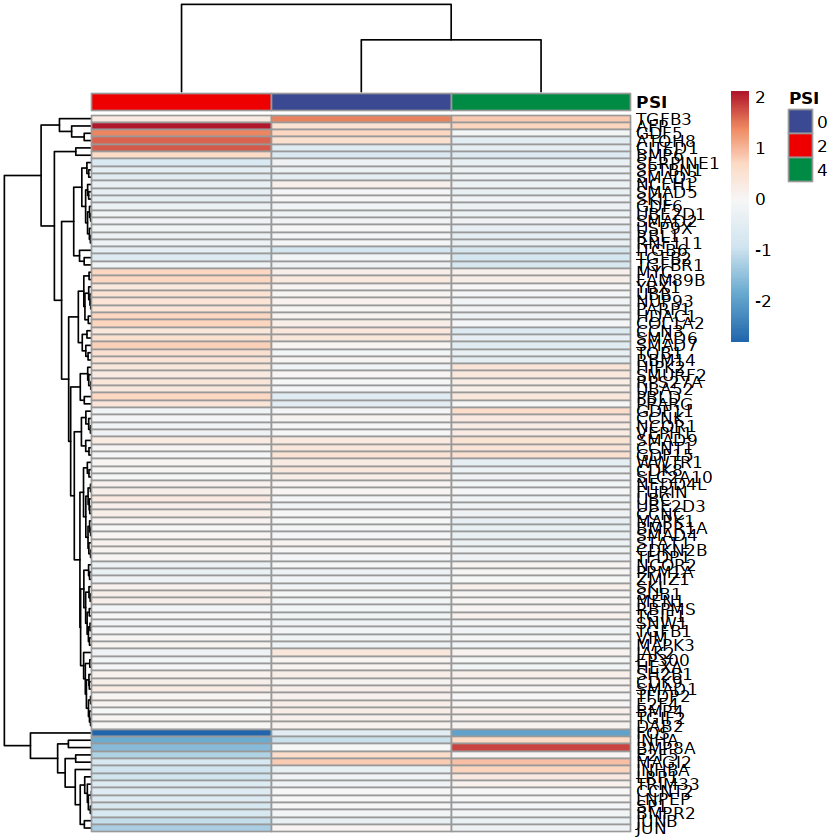

In [460]:
mat <- as.matrix(smad_combo_lfc[,paste0('psi',c(0,2,4))])
paletteLength <- 200

myBreaks <- c(seq(min(mat), 0, length.out=ceiling(paletteLength/2) + 1), 
              seq(max(mat)/paletteLength, max(mat), length.out=floor(paletteLength/2)))

smad_combo_lfc_hmp <- pheatmap::pheatmap(
    as.matrix(smad_combo_lfc[,paste0('psi',c(0,2,4))]),
    scale = 'none', 
    #cellwidth=30, cellheight=12,
    clustering_method = 'complete',
    annotation_col = data.frame(PSI = as.factor(c(0,2,4)), row.names=paste0('psi',c(0,2,4))),
    annotation_colors = anno_colors,
    show_colnames = FALSE,
    #fontfamily = 'Arial',
    #color = colorRampPalette(hcl.colors(20, 'Berlin'))(paletteLength),
    #color = colorRampPalette(c('green','black','red'))(200),
    breaks = myBreaks,
    color = colorRampPalette(rev(brewer.pal(7,'RdBu')))(paletteLength)
)

## SMAD 1/5/8

In [75]:
reactome_path2ID[['R-HSA-201821']]

NULL

In [74]:
grep('Homo sapiens: SMAD', reactome_ID2name, value=TRUE)

R-HSA-3315487 
                  "Homo sapiens: SMAD2/3 MH2 Domain Mutants in Cancer" 
                                                         R-HSA-3304356 
       "Homo sapiens: SMAD2/3 Phosphorylation Motif Mutants in Cancer" 
                                                         R-HSA-2173796 
"Homo sapiens: SMAD2/SMAD3:SMAD4 heterotrimer regulates transcription" 
                                                         R-HSA-3311021 
                    "Homo sapiens: SMAD4 MH2 Domain Mutants in Cancer"

In [57]:
reactome_ID2name[['Phospho-R-Smad1/5/8 dissociates from the receptor complex']]

NULL

In [24]:
pheatmap::pheatmap(
    lcpm_filt_entrez[intersect(rownames(lcpm_filt_entrez), reactome_path2ID[['R-HSA-201444']]),],
    scale = 'row'
)

Warning message in min(x, na.rm = T):
“no non-missing arguments to min; returning Inf”
Warning message in max(x, na.rm = T):
“no non-missing arguments to max; returning -Inf”


ERROR: Error in seq.default(-m, m, length.out = n + 1): 'from' must be a finite number


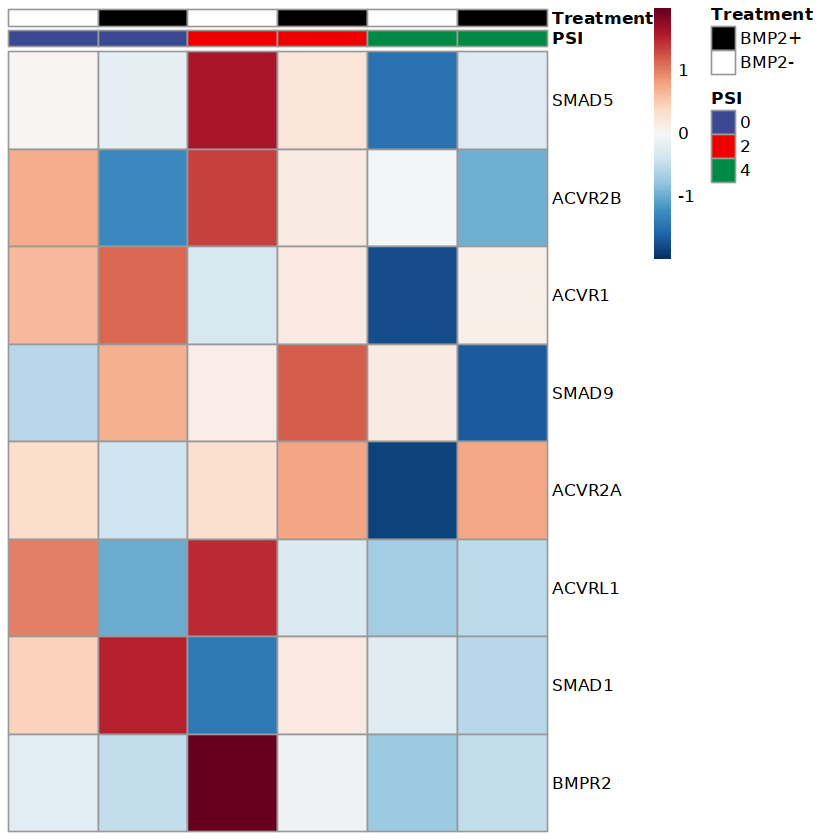

In [147]:
#SMAD_genes <- gene_data %>% dplyr::filter(grepl('SMAD', external_gene_name)) %>% pull(gene_id)
SMAD_genes <- gene_data %>% 
    dplyr::filter(external_gene_name %in% c(
        'BMPR2', 'ACVR2A', 'ACVR2B',
        'ACVRL1', 'ACVR1', 'BMPRIA', 'BMPRIB',
        paste0('SMAD',c(1,5,8,9))
    )) %>% 
    pull(gene_id)
SMAD_mat <- lcpm_filt[intersect(rownames(lcpm_filt), SMAD_genes),]
rownames(SMAD_mat) <- gene_data$external_gene_name[match(rownames(SMAD_mat), gene_data$gene_id)]

pheatmap::pheatmap(
    SMAD_mat,
    annotation_col = anno_col, annotation_colors = anno_colors,
    show_colnames = FALSE,
    cluster_col = FALSE,
    cluster_row = FALSE,
    scale = 'row',
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200)
)

## BMP signaling

In [96]:
gsva_BMP2 <- gsva(
    lcpm_filt_entrez, 
    list(
        BMP2_reactome = reactome_path2ID[['R-HSA-201451']],
        BMP2_GO = unname(go_all_genes[['GO:0030509']])
    )
)

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”


Estimating GSVA scores for 2 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



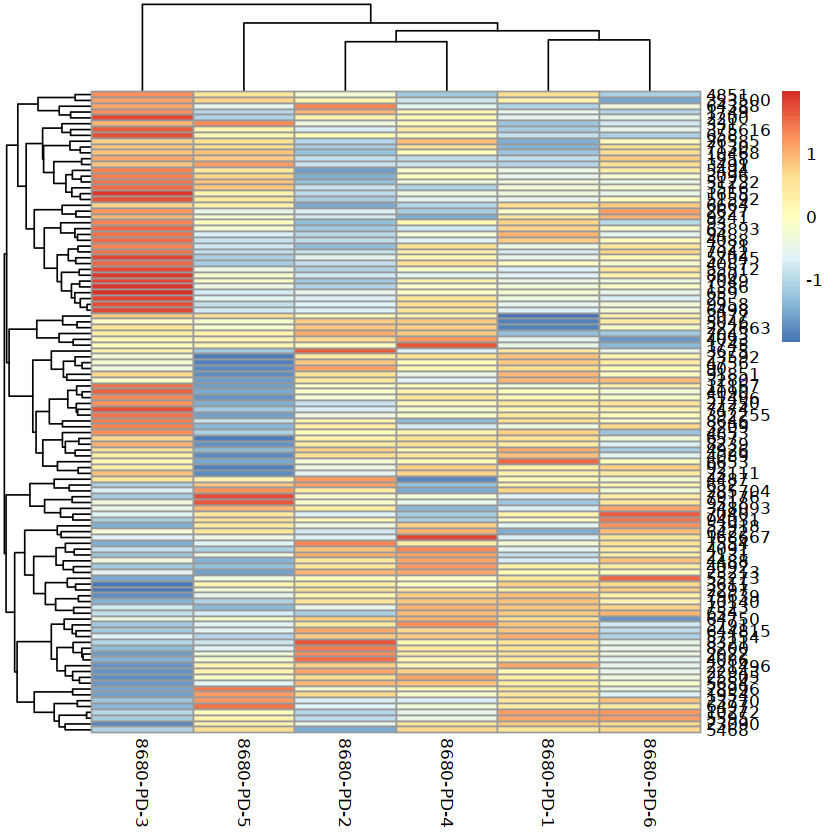

In [194]:
pheatmap::pheatmap(
    lcpm_filt_entrez[intersect(rownames(lcpm_filt_entrez), unname(go_all_genes[['GO:0030509']])),],
    scale = 'row'
)

In [467]:
paste0(rep(paste0('psi',c(0,2,4)), each=2), c('-','+'))

[1] "psi0-" "psi0+" "psi2-" "psi2+" "psi4-" "psi4+"

In [727]:
svg(file.path(projdir, 'analyses', 'Plots', 'BMP_reactome_gsva_bar.svg'), width=5, height=4)
barplot(gsva_BMP2[1,], main = 'Signaling by BMP', las=2, names=paste0(rep(paste0('psi',c(0,2,4)), each=2), c('-','+')))
dev.off()

png 
  2

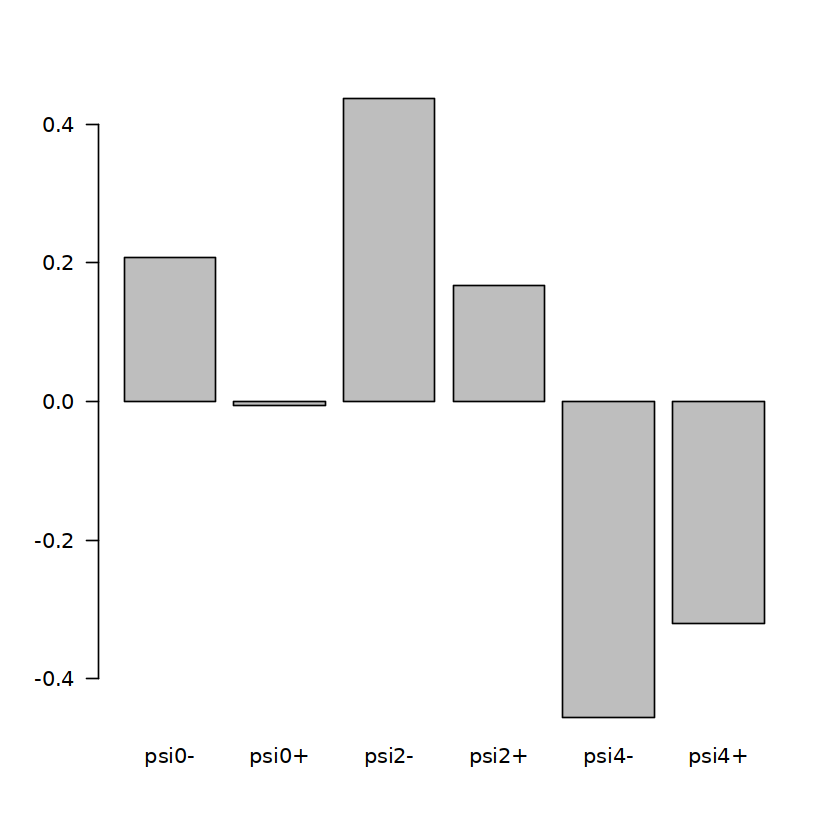

In [97]:
barplot(gsva_BMP2[1,], las=1, names=paste0(rep(paste0('psi',c(0,2,4)), each=2), c('-','+')))

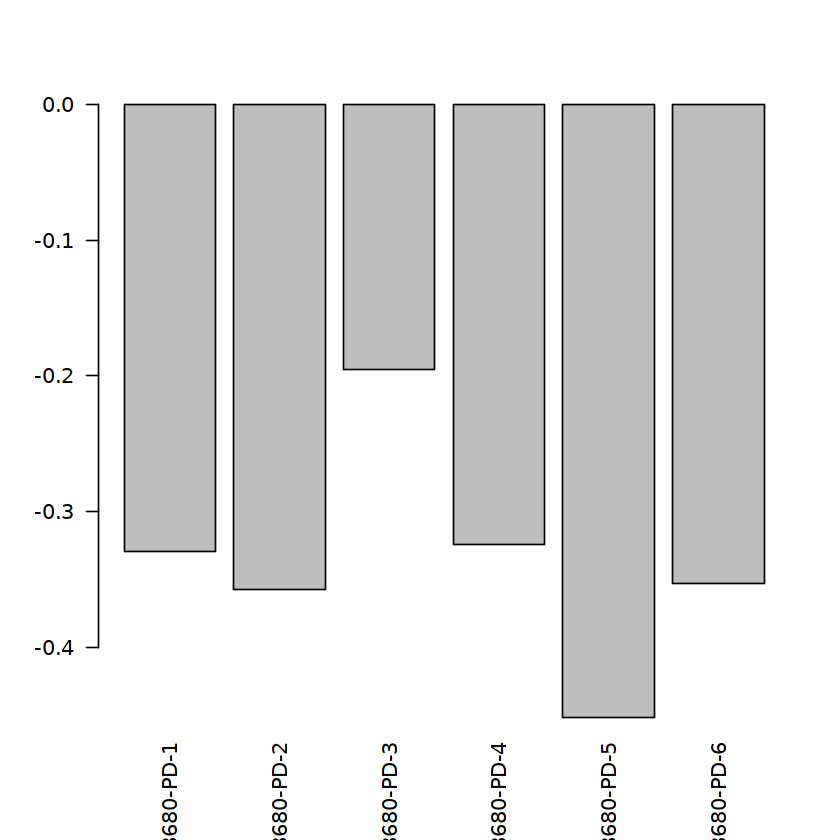

In [98]:
barplot(gsva_BMP2[2,], las=2)

In [151]:
ReactomePA::viewPathway('Signaling by BMP', organism = 'human')

Warning message in FUN(X[[i]], ...):
“NAs introduced by coercion”
Warning message in draw_axis(break_positions = guide$key[[aesthetic]], break_labels = guide$key$.label, :
“restarting interrupted promise evaluation”
Warning message in draw_axis(break_positions = guide$key[[aesthetic]], break_labels = guide$key$.label, :
“internal error -3 in R_decompress1”
ERROR while rich displaying an object: Error in draw_axis(break_positions = guide$key[[aesthetic]], break_labels = guide$key$.label, : lazy-load database '/home/benjy/mambaforge/lib/R/library/gtable/R/gtable.rdb' is corrupt

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOn

## PCA

In [21]:
reactome_pca <- prcomp(t(gsva_reactome))
reactome_exp_var <- reactome_pca$sdev^2/sum(reactome_pca$sdev^2)

reactome_ssgsea_pca <- prcomp(t(ssgsea_reactome))
reactome_ssgsea_exp_var <- reactome_ssgsea_pca$sdev^2/sum(reactome_ssgsea_pca$sdev^2)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 't': object 'gsva_reactome' not found


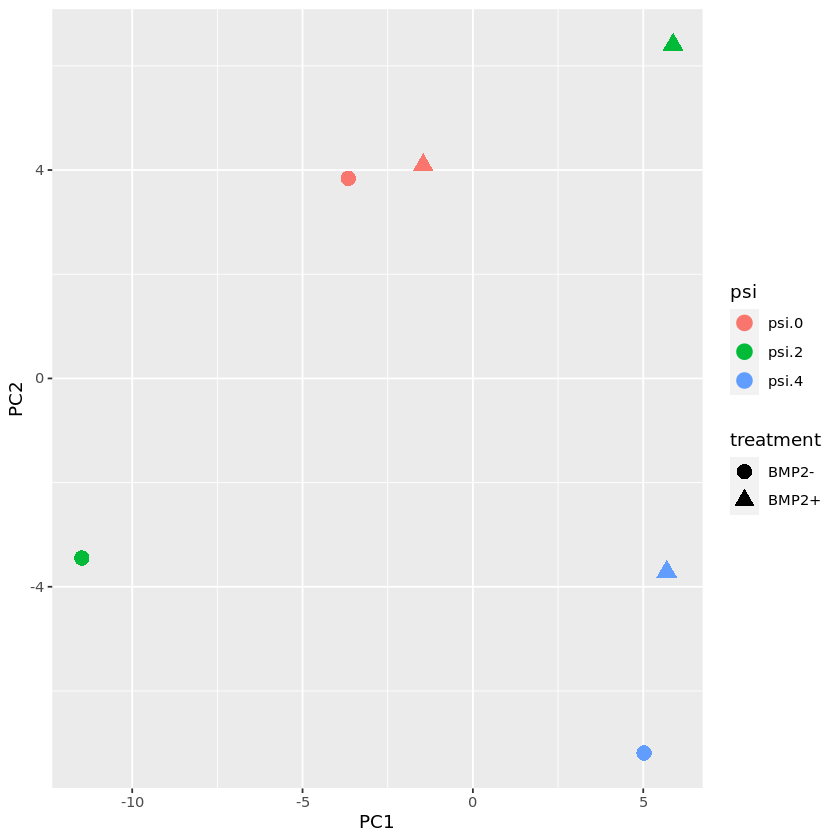

In [336]:
cbind(reactome_pca$x, y$samples) %>%
    ggplot(aes(PC1, PC2)) + 
    geom_point(aes(color=psi, shape=treatment), size=4)

In [529]:
png(file.path(projdir, 'analyses', 'Plots', 'pca_reactome.png'), res=300, units='in', width=6, height=6)
pairs(
    reactome_pca$x[,1:5], 
    upper.panel=NULL,
    lower.panel=panel.lines,
    pch = pairs_pch[y$samples$treatment],
    col = anno_colors$psi[y$samples$psi],
    cex = 2,
    label = sprintf('PC%i\n%0.2f%%', 1:5, 100*exp_var[1:5]))
par(xpd=TRUE)
legend('topright', 
       legend = c(names(anno_colors$psi), names(pairs_pch)),
       pt.cex = 2,
       pch = c(rep(15, length(anno_colors$psi)), pairs_pch), 
       col = c(anno_colors$psi, 'black', 'black'))
dev.off()

png 
  2

## PCA loadings

In [564]:
reactome_pca_loading <- list()
for(i in 1:5) {
    tmp <- reactome_pca$rotation[,i] %>%
        as.data.frame() %>%
        rownames_to_column('Term') %>%
        pivot_longer(!Term, names_to='PC', values_to='score') %>%
        mutate(Direction = as.factor(sign(score))) %>%
        group_by(Direction) %>%
        dplyr::slice_max(abs(score), n=15) %>%
        arrange(score)
    tmp$Name <- reactome_ID2name_df[tmp$Term,'Name']
    tmp$Name <- gsub('Homo sapiens: ', '', tmp$Name)
    tmp$Name <- factor(tmp$Name, levels=unique(tmp$Name))
    reactome_pca_loading[[i]] <- ggplot(tmp, aes(score, Name)) + 
        geom_col(aes(fill=Direction)) + 
        labs(y=NULL) +
        scale_y_discrete(labels = function(x) str_wrap(x, width = 100)) +
        ggtitle(paste0('PC',i)) +
        theme_bw(base_size=15)
}

In [565]:
png(file.path(projdir, 'analyses', 'Plots', 'pca_reactome_loadings.png'), res=300, units='in', width=30, height=20)
ggpubr::ggarrange(
    plotlist = reactome_pca_loading, nrow=2, ncol=3, common.legend=TRUE
)
dev.off()

png 
  2

## Heatmap

In [41]:
gsva_reactome_hmp <- pheatmap::pheatmap(
    gsva_reactome, 
    annotation_col=anno_col, annotation_colors=anno_colors,
    show_rownames=FALSE,
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200),
    filename = file.path(projdir, 'analyses', 'Plots', 'gsva_hmp.png'))

## Heatmap clustering

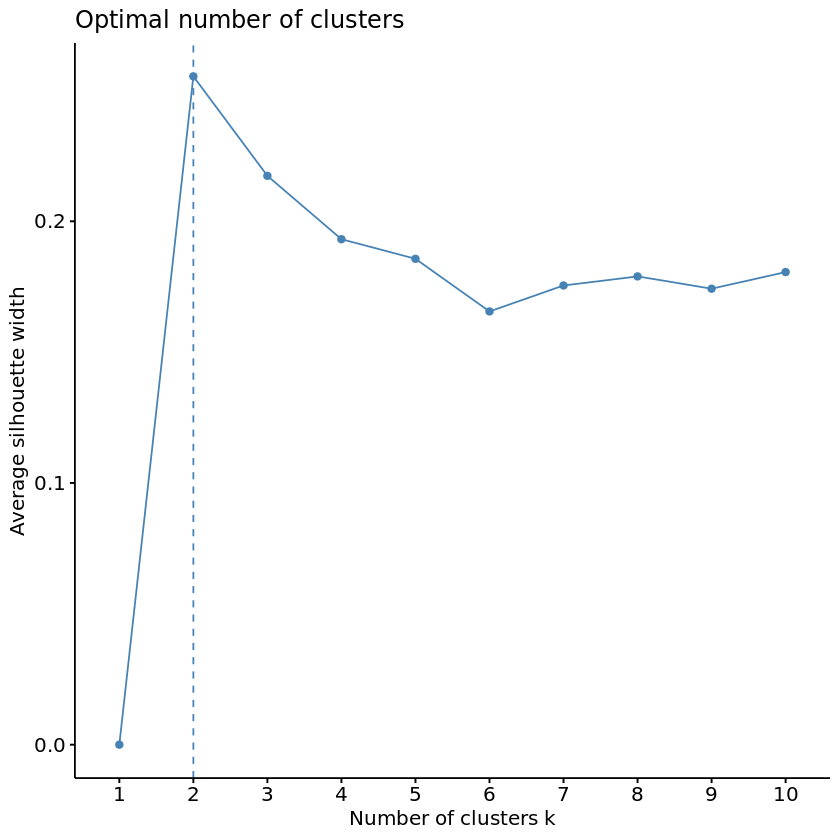

In [107]:
factoextra::fviz_nbclust(gsva_reactome, kmeans, method = "silhouette")

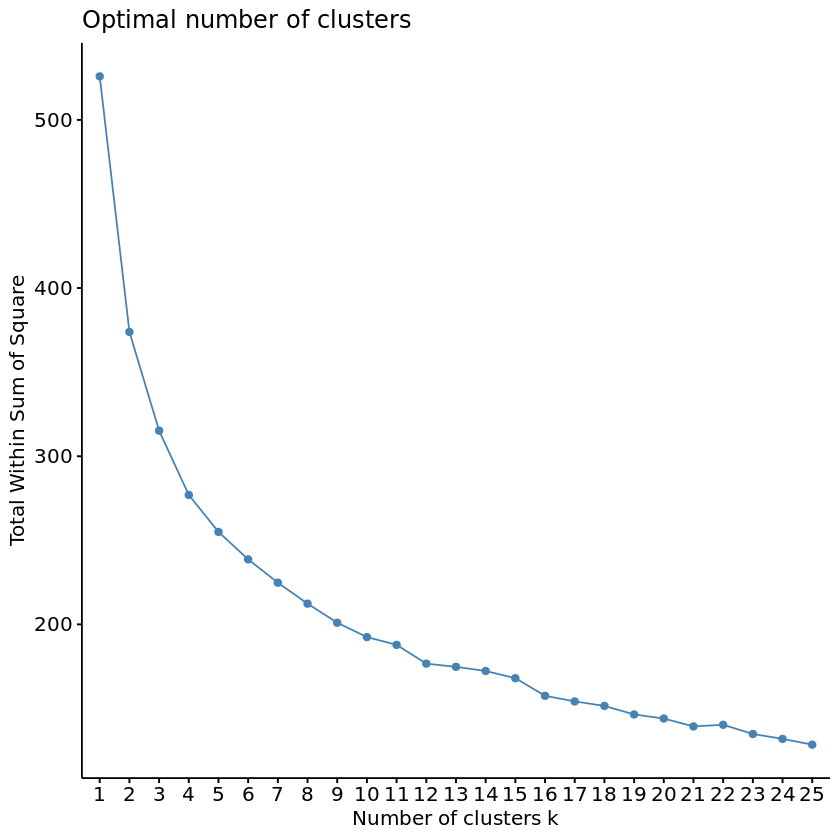

In [113]:
factoextra::fviz_nbclust(gsva_reactome, kmeans, method = "wss", k.max = 25)

In [42]:
gsva_reactome_clust_hmp <- pheatmap::pheatmap(
    gsva_reactome, 
    cutree_rows = 5,
    annotation_col = anno_col, 
    annotation_row = anno_row,
    annotation_colors = anno_colors,
    clustering_method = 'ward.D2',
    clustering_distance_rows = 'euclidean',
    show_rownames=FALSE,
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200),
    filename = file.path(projdir, 'analyses', 'Plots', 'gsva_k5clust_hmp.png'))

ERROR: Error in is.na2(annotation_row): object 'anno_row' not found


In [650]:
gsva_reactome_clust <- cutree(gsva_reactome_clust_hmp$tree_row, k=5)

In [654]:
gsva_reactome_clust_df <- as.data.frame(gsva_reactome_clust)
gsva_reactome_clust_df$Name <- gsub('Homo sapiens: ', '', reactome_ID2name[rownames(gsva_reactome_clust_df)])
head(gsva_reactome_clust_df)

gsva_reactome_clust
R-HSA-109582  1                  
R-HSA-114608  1                  
R-HSA-6798695 2                  
R-HSA-76002   1                  
R-HSA-76005   1                  
R-HSA-156580  3                  
              Name                                          
R-HSA-109582  Hemostasis                                    
R-HSA-114608  Platelet degranulation                        
R-HSA-6798695 Neutrophil degranulation                      
R-HSA-76002   Platelet activation, signaling and aggregation
R-HSA-76005   Response to elevated platelet cytosolic Ca2+  
R-HSA-156580  Phase II - Conjugation of compounds

In [673]:
gsva_reactome_clust_df %>% 
    arrange(gsva_reactome_clust) %>% 
    rownames_to_column('Reactome ID') %>%
    write_tsv(file.path(projdir, 'analyses', 'gsva_reactome_k10.tsv'))

Saving 6.67 x 10 in image


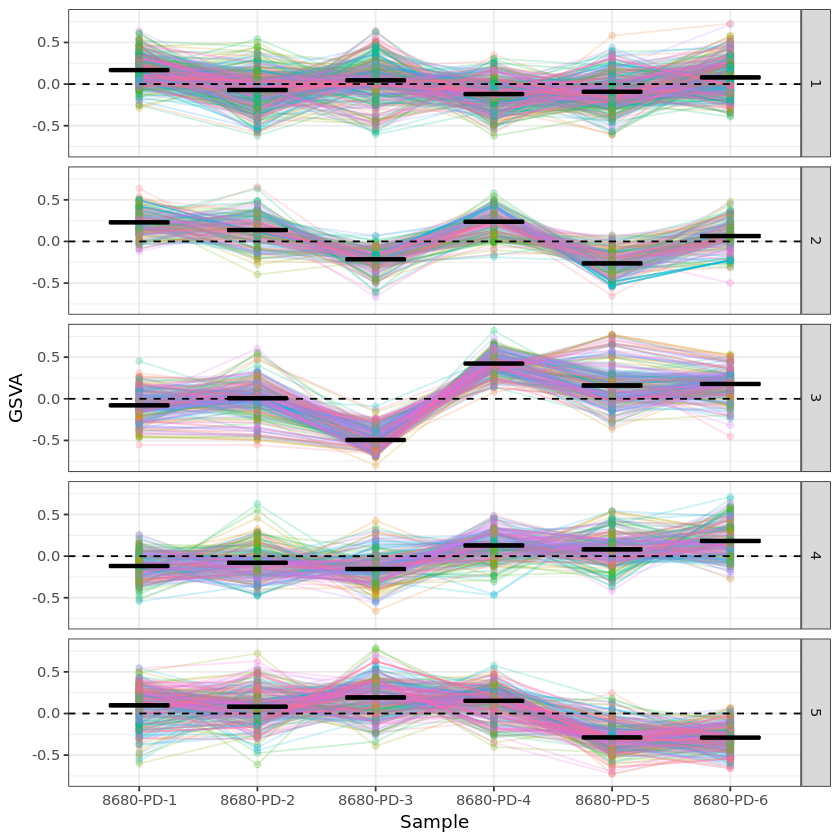

In [659]:
gsva_k5_reactome_line <- as.data.frame(gsva_reactome)
gsva_k5_reactome_line$cluster <- gsva_reactome_clust_df[rownames(gsva_reactome), 'gsva_reactome_clust']

gsva_k5_reactome_line %>%
    rownames_to_column('Reactome') %>%
    pivot_longer(cols = !c(Reactome, cluster), names_to='Sample', values_to='GSVA') %>%
    ggplot(aes(Sample, GSVA)) +
        facet_grid(rows=vars(cluster)) +
        geom_line(aes(group=Reactome, color=Reactome), alpha=0.2) +
        geom_point(aes(color=Reactome), alpha=0.2) +
        stat_summary(fun.data='mean_se', geom='crossbar', width=0.5) +
        geom_hline(yintercept=0, lty=2) +
        theme_bw() +
        theme(legend.position='none')
ggsave(file.path(projdir, 'analyses', 'Plots', 'gsva_k5clust_trends.png'), height=10)

## DEGreport

In [44]:
library(DEGreport)

In [353]:
head(y$samples)

group     lib.size norm.factors Project Sample_ID                  
8680-PD-1 psi.0.off 14642979 1.0064562    8680-PD 8680-PD-1_TTCCAAGC-TCAACGGT
8680-PD-2 psi.0.on  18714012 1.0211331    8680-PD 8680-PD-2_CTATTCAT-GACTAGTT
8680-PD-3 psi.2.off 16507264 0.9862419    8680-PD 8680-PD-3_AAGCAATA-CGTTACTC
8680-PD-4 psi.2.on  18609034 0.9801119    8680-PD 8680-PD-4_GTTCTACG-GCAACTAG
8680-PD-5 psi.4.off 16602615 1.0266844    8680-PD 8680-PD-5_AGAATCTC-ATCTGACC
8680-PD-6 psi.4.on  21454887 0.9804527    8680-PD 8680-PD-6_CGGTCCGT-CGTCTATT
          Description Barcode           X..Reads X..Reads.1
8680-PD-1 0 psi-      TTCCAAGC-TCAACGGT 28884512 0.225     
8680-PD-2 0 psi+      CTATTCAT-GACTAGTT 37384606 0.292     
8680-PD-3 2 psi-      AAGCAATA-CGTTACTC 32594369 0.255     
8680-PD-4 2 psi+      GTTCTACG-GCAACTAG 33851556 0.262     
8680-PD-5 4 psi-      AGAATCTC-ATCTGACC 34730815 0.272     
8680-PD-6 4 psi+      CGGTCCGT-CGTCTATT 41371896 0.322     
          X..Perfect.Index.Reads X..One.Mismatch.Index.Reads psi   treatment
8680-PD-1 100                    0                           psi.0 off      
8680-PD-2 100                    0                           psi.0 on       
8680-PD-3 100                    0                           psi.2 off      
8680-PD-4 100                    0                           psi.2 on       
8680-PD-5 100                    0                           psi.4 off      
8680-PD-6 100                    0                           psi.4 on

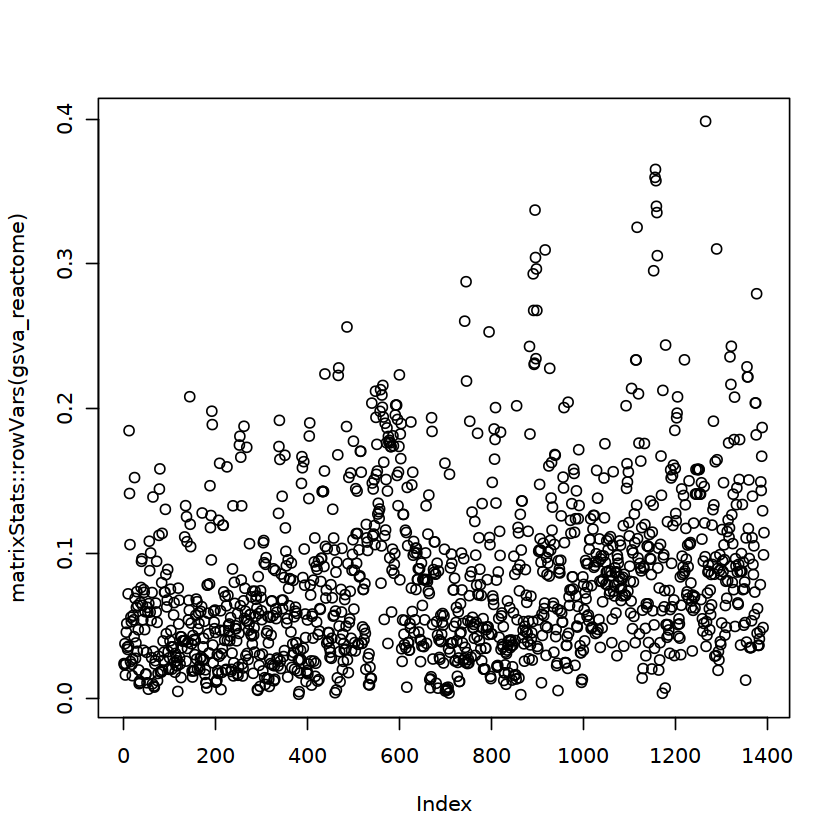

In [50]:
plot(matrixStats::rowVars(gsva_reactome))

In [99]:
gsva_reactome_rv <- matrixStats::rowVars(gsva_reactome)
keep <- order(gsva_reactome_rv, decreasing=TRUE)[1:200]
topVar_gsva_reactome <- gsva_reactome[keep,]

In [112]:
reactome_ID2name[rownames(gsva_reactome)[keep[1:20]]]

$`R-HSA-9735869`
[1] "Homo sapiens: SARS-CoV-1 modulates host translation machinery"

$`R-HSA-156902`
[1] "Homo sapiens: Peptide chain elongation"

$`R-HSA-156842`
[1] "Homo sapiens: Eukaryotic Translation Elongation"

$`R-HSA-192823`
[1] "Homo sapiens: Viral mRNA Translation"

$`R-HSA-2408557`
[1] "Homo sapiens: Selenocysteine synthesis"

$`R-HSA-72689`
[1] "Homo sapiens: Formation of a pool of free 40S subunits"

$`R-HSA-72764`
[1] "Homo sapiens: Eukaryotic Translation Termination"

$`R-HSA-1799339`
[1] "Homo sapiens: SRP-dependent cotranslational protein targeting to membrane"

$`R-HSA-1236977`
[1] "Homo sapiens: Endosomal/Vacuolar pathway"

$`R-HSA-9633012`
[1] "Homo sapiens: Response of EIF2AK4 (GCN2) to amino acid deficiency"

$`R-HSA-975956`
[1] "Homo sapiens: Nonsense Mediated Decay (NMD) independent of the Exon Junction Complex (EJC)"

$`R-HSA-72695`
[1] "Homo sapiens: Formation of the ternary complex, and subsequently, the 43S complex"

$`R-HSA-72706`
[1] "Homo sapiens: GTP hydrolysis and joining of the 60S ribosomal subunit"

$`R-HSA-9754678`
[1] "Homo sapiens: SARS-CoV-2 modulates host translation machinery"

$`R-HSA-156827`
[1] "Homo sapiens: L13a-mediated translational silencing of Ceruloplasmin expression"

$`R-HSA-2468052`
[1] "Homo sapiens: Establishment of Sister Chromatid Cohesion"

$`R-HSA-196780`
[1] "Homo sapiens: Biotin transport and metabolism"

$`R-HSA-72613`
[1] "Homo sapiens: Eukaryotic Translation Initiation"

$`R-HSA-72737`
[1] "Homo sapiens: Cap-dependent Translation Initiation"

$`R-HSA-2408522`
[1] "Homo sapiens: Selenoamino acid metabolism"

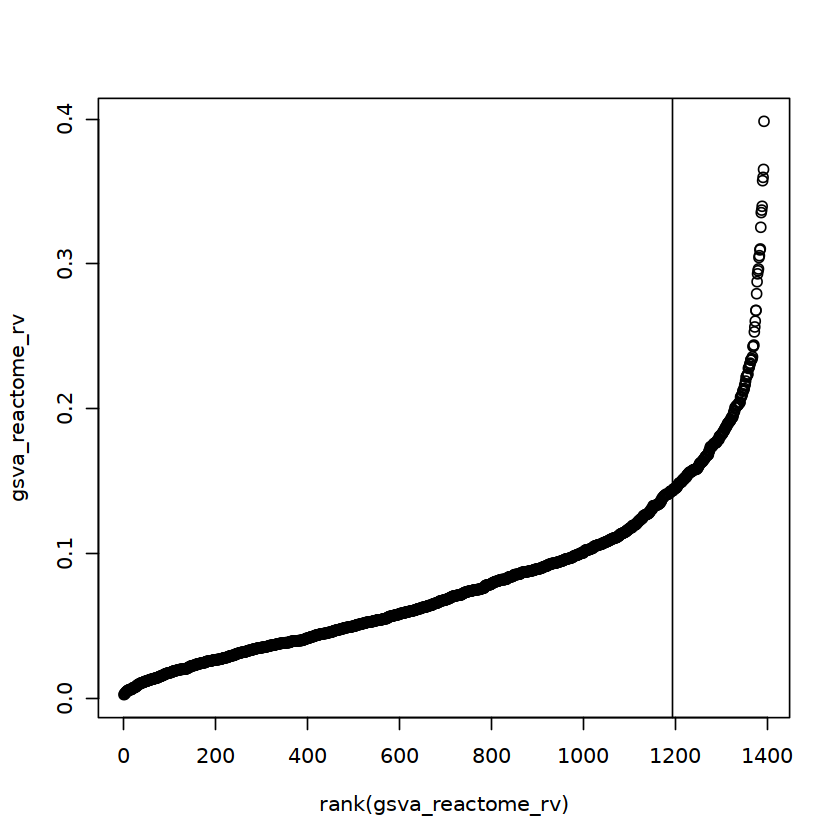

In [101]:
plot(rank(gsva_reactome_rv), gsva_reactome_rv)
abline(v=length(gsva_reactome_rv) - 200)

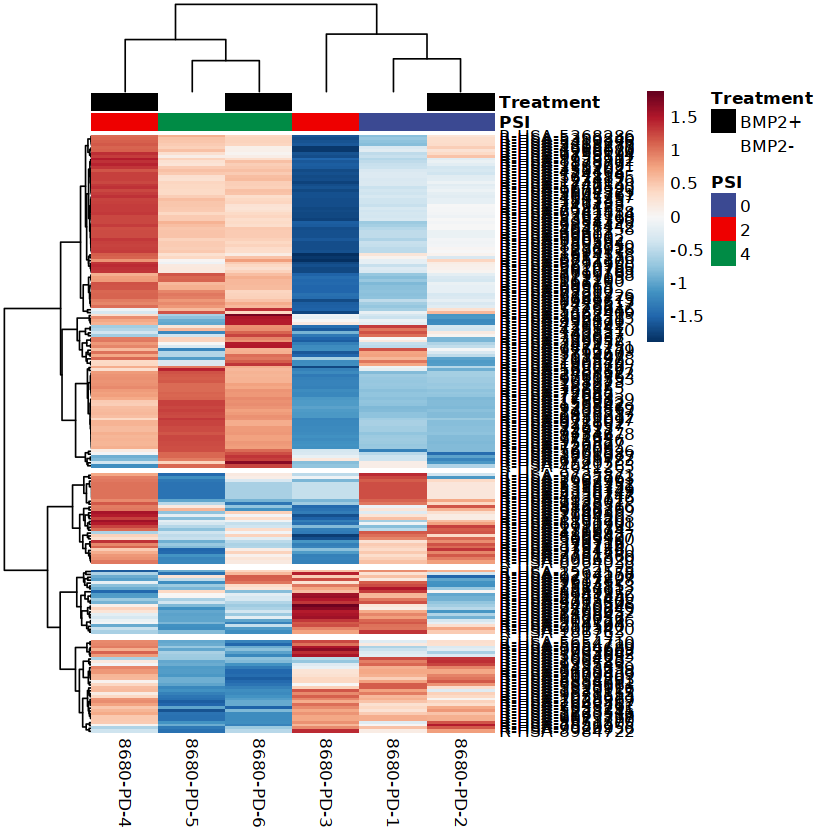

In [118]:
topVar_gsva_reactome_clust <- pheatmap::pheatmap(
    topVar_gsva_reactome,
    scale = 'row',
    clustering_method = 'ward.D2',
    cutree_rows = 4,
    annotation_col = anno_col,
    annotation_colors = anno_colors,
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200)
)

In [123]:
topVar_gsva_reactome_clust_k <- cutree(topVar_gsva_reactome_clust$tree_row, k=4)
topVar_gsva_reactome_clust_k_names <- split(names(topVar_gsva_reactome_clust_k), topVar_gsva_reactome_clust_k)
topVar_gsva_reactome_clust_k_names <- sapply(topVar_gsva_reactome_clust_k_names, function(i) reactome_ID2name[i])
topVar_gsva_reactome_clust_k_names                                             

$`1`
$`1`$`R-HSA-9735869`
[1] "Homo sapiens: SARS-CoV-1 modulates host translation machinery"

$`1`$`R-HSA-156902`
[1] "Homo sapiens: Peptide chain elongation"

$`1`$`R-HSA-156842`
[1] "Homo sapiens: Eukaryotic Translation Elongation"

$`1`$`R-HSA-192823`
[1] "Homo sapiens: Viral mRNA Translation"

$`1`$`R-HSA-2408557`
[1] "Homo sapiens: Selenocysteine synthesis"

$`1`$`R-HSA-72689`
[1] "Homo sapiens: Formation of a pool of free 40S subunits"

$`1`$`R-HSA-72764`
[1] "Homo sapiens: Eukaryotic Translation Termination"

$`1`$`R-HSA-1799339`
[1] "Homo sapiens: SRP-dependent cotranslational protein targeting to membrane"

$`1`$`R-HSA-1236977`
[1] "Homo sapiens: Endosomal/Vacuolar pathway"

$`1`$`R-HSA-9633012`
[1] "Homo sapiens: Response of EIF2AK4 (GCN2) to amino acid deficiency"

$`1`$`R-HSA-975956`
[1] "Homo sapiens: Nonsense Mediated Decay (NMD) independent of the Exon Junction Complex (EJC)"

$`1`$`R-HSA-72695`
[1] "Homo sapiens: Formation of the ternary complex, and subsequently, the 43S complex"

$`1`$`R-HSA-72706`
[1] "Homo sapiens: GTP hydrolysis and joining of the 60S ribosomal subunit"

$`1`$`R-HSA-9754678`
[1] "Homo sapiens: SARS-CoV-2 modulates host translation machinery"

$`1`$`R-HSA-156827`
[1] "Homo sapiens: L13a-mediated translational silencing of Ceruloplasmin expression"

$`1`$`R-HSA-72613`
[1] "Homo sapiens: Eukaryotic Translation Initiation"

$`1`$`R-HSA-72737`
[1] "Homo sapiens: Cap-dependent Translation Initiation"

$`1`$`R-HSA-2408522`
[1] "Homo sapiens: Selenoamino acid metabolism"

$`1`$`R-HSA-163210`
[1] "Homo sapiens: Formation of ATP by chemiosmotic coupling"

$`1`$`R-HSA-140837`
[1] "Homo sapiens: Intrinsic Pathway of Fibrin Clot Formation"

$`1`$`R-HSA-72702`
[1] "Homo sapiens: Ribosomal scanning and start codon recognition"

$`1`$`R-HSA-927802`
[1] "Homo sapiens: Nonsense-Mediated Decay (NMD)"

$`1`$`R-HSA-975957`
[1] "Homo sapiens: Nonsense Mediated Decay (NMD) enhanced by the Exon Junction Complex (EJC)"

$`1`$`R-HSA-72662`
[1] "Homo sapiens: Activation of the mRNA upon binding of the cap-binding complex and eIFs, and subsequent binding to 43S"

$`1`$`R-HSA-72649`
[1] "Homo sapiens: Translation initiation complex formation"

$`1`$`R-HSA-611105`
[1] "Homo sapiens: Respiratory electron transport"

$`1`$`R-HSA-9010553`
[1] "Homo sapiens: Regulation of expression of SLITs and ROBOs"

$`1`$`R-HSA-163200`
[1] "Homo sapiens: Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins."

$`1`$`R-HSA-350562`
[1] "Homo sapiens: Regulation of ornithine decarboxylase (ODC)"

$`1`$`R-HSA-180585`
[1] "Homo sapiens: Vif-mediated degradation of APOBEC3G"

$`1`$`R-HSA-1236978`
[1] "Homo sapiens: Cross-presentation of soluble exogenous antigens (endosomes)"

$`1`$`R-HSA-211733`
[1] "Homo sapiens: Regulation of activated PAK-2p34 by proteasome mediated degradation"

$`1`$`R-HSA-1614558`
[1] "Homo sapiens: Degradation of cysteine and homocysteine"

$`1`$`R-HSA-6799198`
[1] "Homo sapiens: Complex I biogenesis"

$`1`$`R-HSA-75815`
[1] "Homo sapiens: Ubiquitin-dependent degradation of Cyclin D"

$`1`$`R-HSA-69601`
[1] "Homo sapiens: Ubiquitin Mediated Degradation of Phosphorylated Cdc25A"

$`1`$`R-HSA-69610`
[1] "Homo sapiens: p53-Independent DNA Damage Response"

$`1`$`R-HSA-69613`
[1] "Homo sapiens: p53-Independent G1/S DNA damage checkpoint"

$`1`$`R-HSA-349425`
[1] "Homo sapiens: Autodegradation of the E3 ubiquitin ligase COP1"

$`1`$`R-HSA-389960`
[1] "Homo sapiens: Formation of tubulin folding intermediates by CCT/TriC"

$`1`$`R-HSA-180534`
[1] "Homo sapiens: Vpu mediated degradation of CD4"

$`1`$`R-HSA-5689877`
[1] "Homo sapiens: Josephin domain DUBs"

$`1`$`R-HSA-69541`
[1] "Homo sapiens: Stabilization of p53"

$`1`$`R-HSA-351202`
[1] "Homo sapiens: Metabolism of polyamines"

$`1`$`R-HSA-169911`
[1] "Homo sapiens: Regulation of Apoptosis"

$`1`$`R-HSA-5368286`
[1] "Homo sapiens: Mitochondrial translation initiation"

$`1`$`R-HSA-5423646`
[1] "Homo sapiens: A

Working with 200 genes.

Working with 145 genes after filtering: minc > 10

Joining with `by = join_by(merge)`
Joining with `by = join_by(merge)`
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”


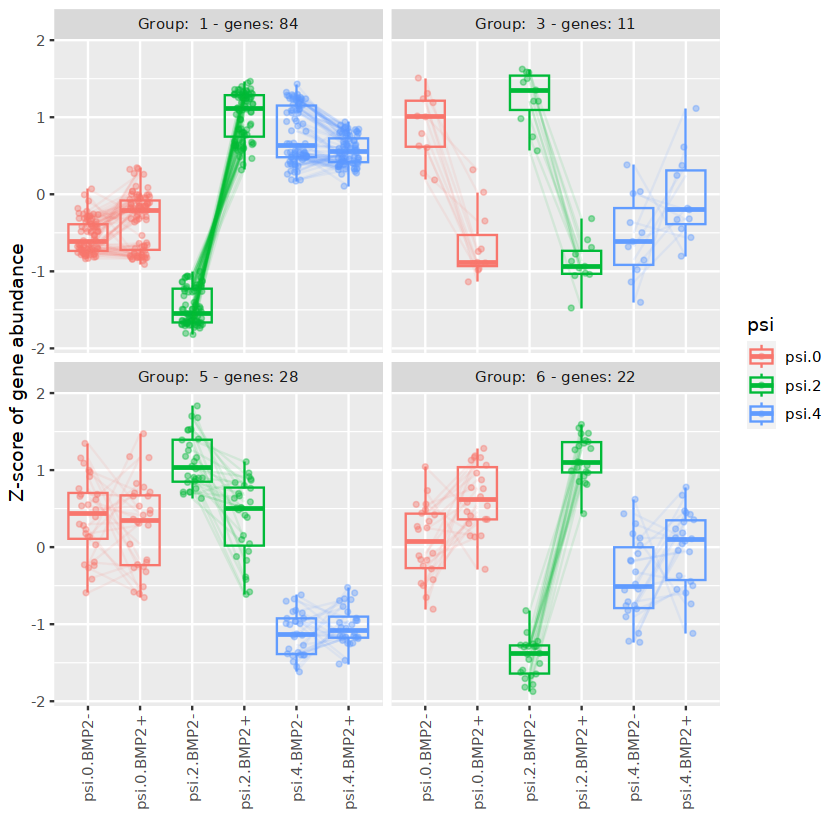

In [81]:
gsva_reactome_clusters <- degPatterns(topVar_gsva_reactome, y$samples, minc = 10, time = 'group', col = 'psi', reduce = TRUE)

Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `poly()`:
! 'degree' must be less than number of unique points”
Warning message:
“Computati

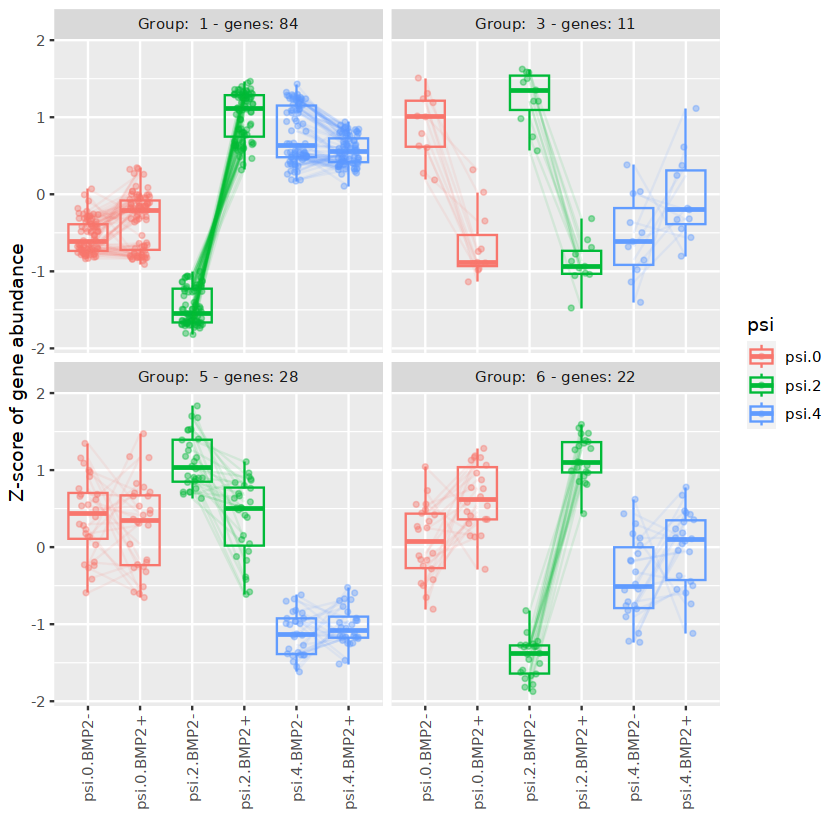

In [82]:
gsva_reactome_clusters$plot
ggsave(file.path(projdir, 'analyses', 'Plots', 'gsva_degPattern.png'), width=10, height=10)

In [131]:
gsva_reactome_clusters_df <- gsva_reactome_clusters$df
gsva_reactome_clusters_df$name <- reactome_ID2name[gsub('.','-',gsva_reactome_clusters_df$genes,fixed=TRUE)]
gsva_reactome_clusters_df$name <- gsub('Homo sapiens: ', '', gsva_reactome_clusters_df$name, fixed=TRUE)
colnames(gsva_reactome_clusters_df)[1] <- 'Reactome'
head(gsva_reactome_clusters_df)

Reactome      cluster
R.HSA.9735869 R.HSA.9735869 1      
R.HSA.156902  R.HSA.156902  1      
R.HSA.156842  R.HSA.156842  1      
R.HSA.192823  R.HSA.192823  1      
R.HSA.2408557 R.HSA.2408557 1      
R.HSA.72689   R.HSA.72689   1      
              name                                           
R.HSA.9735869 SARS-CoV-1 modulates host translation machinery
R.HSA.156902  Peptide chain elongation                       
R.HSA.156842  Eukaryotic Translation Elongation              
R.HSA.192823  Viral mRNA Translation                         
R.HSA.2408557 Selenocysteine synthesis                       
R.HSA.72689   Formation of a pool of free 40S subunits

In [132]:
table(gsva_reactome_clusters_df$cluster)


 1  3  5  6 
84 11 28 22 

In [133]:
gsva_reactome_clusters_df %>% dplyr::filter(cluster==3)

Reactome      cluster
R.HSA.428540  R.HSA.428540  3      
R.HSA.8941856 R.HSA.8941856 3      
R.HSA.210744  R.HSA.210744  3      
R.HSA.2514853 R.HSA.2514853 3      
R.HSA.9013508 R.HSA.9013508 3      
R.HSA.8849932 R.HSA.8849932 3      
R.HSA.9617828 R.HSA.9617828 3      
R.HSA.156711  R.HSA.156711  3      
R.HSA.1234158 R.HSA.1234158 3      
R.HSA.210500  R.HSA.210500  3      
R.HSA.110056  R.HSA.110056  3      
              name                                                                                                
R.HSA.428540  Activation of RAC1                                                                                  
R.HSA.8941856 RUNX3 regulates NOTCH signaling                                                                     
R.HSA.210744  Regulation of gene expression in late stage (branching morphogenesis) pancreatic bud precursor cells
R.HSA.2514853 Condensation of Prometaphase Chromosomes                                                            
R.HSA.9013508 NOTCH3 Intracellular Domain Regulates Transcription                                                 
R.HSA.8849932 Synaptic adhesion-like molecules                                                                    
R.HSA.9617828 FOXO-mediated transcription of cell cycle genes                                                     
R.HSA.156711  Polo-like kinase mediated events                                                                    
R.HSA.1234158 Regulation of gene expression by Hypoxia-inducible Factor                                           
R.HSA.210500  Glutamate Neurotransmitter Release Cycle                                                            
R.HSA.110056  MAPK3 (ERK1) activation

In [70]:
dim(gsva_reactome_clusters_df)

[1] 134   3

In [571]:
write_tsv(gsva_reactome_clusters_df, file.path(projdir, 'analyses', 'gsva_reactome_clusters_df.tsv'))

### DEGreport clustering

In [85]:
anno_row <- data.frame(Reactome = gsub('-','.',rownames(gsva_reactome),fixed=TRUE))
anno_row <- left_join(anno_row, gsva_reactome_clusters_df, by='Reactome')
anno_row <- anno_row[gsva_reactome_hmp$tree_row$order,,drop=FALSE]
rownames(anno_row) <- gsub('.','-',anno_row$Reactome,fixed=TRUE)
anno_row$name <- NULL
anno_row$Reactome <- NULL
anno_row$cluster[which(is.na(anno_row$cluster))] <- 0
anno_row$cluster <- as.factor(anno_row$cluster)
head(anno_row)

cluster
R-HSA-4641265 0      
R-HSA-390522  0      
R-HSA-1236977 0      
R-HSA-380108  0      
R-HSA-6783783 0      
R-HSA-75205   0

In [86]:
anno_colors$cluster <- sample(rainbow(n=nlevels(anno_row$cluster)))
names(anno_colors$cluster) <- as.character(unique(levels(anno_row$cluster)))

In [88]:
pheatmap::pheatmap(
    gsva_reactome, 
    #cutree_rows = 10,
    annotation_col = anno_col, 
    annotation_row = anno_row,
    annotation_colors=anno_colors,
    show_rownames=FALSE,
    color = colorRampPalette(rev(brewer.pal(11,'RdBu')))(200),
    filename = file.path(projdir, 'analyses', 'Plots', 'gsva_degPattern_hmp.png'))

In [598]:
head(gsva_reactome)
head(anno_row)

8680-PD-1   8680-PD-2     8680-PD-3   8680-PD-4   8680-PD-5  
R-HSA-109582   0.20109512 -0.0653585178  0.04636672 -0.08606490 -0.21038182
R-HSA-114608   0.08474328 -0.0682899305 -0.13008533 -0.12625188  0.02177881
R-HSA-6798695  0.17914760 -0.0205343202 -0.23805167  0.07352834 -0.12915668
R-HSA-76002    0.20005977  0.0008162642 -0.11631876 -0.08910727 -0.10551749
R-HSA-76005    0.10229191 -0.0798971279 -0.12150877 -0.13969466  0.03795515
R-HSA-156580  -0.06367859  0.0687887925 -0.35893564  0.24059738  0.01272670
              8680-PD-6 
R-HSA-109582  0.14803213
R-HSA-114608  0.26636895
R-HSA-6798695 0.28517408
R-HSA-76002   0.09015491
R-HSA-76005   0.25992931
R-HSA-156580  0.18421042

cluster
R-HSA-4641265 2      
R-HSA-390522  2      
R-HSA-1236977 30     
R-HSA-380108  30     
R-HSA-6783783 30     
R-HSA-75205   0

In [605]:
anno_row[rownames(gsva_reactome),,drop=FALSE]

cluster
R-HSA-109582  1      
R-HSA-114608  2      
R-HSA-6798695 3      
R-HSA-76002   4      
R-HSA-76005   2      
R-HSA-156580  5      
R-HSA-211859  6      
R-HSA-9748784 5      
R-HSA-9753281 0      
R-HSA-15869   5      
R-HSA-5668914 6      
R-HSA-74217   8      
R-HSA-8956321 2      
R-HSA-9755088 3      
R-HSA-1500931 0      
R-HSA-381426  10     
R-HSA-418990  1      
R-HSA-421270  11     
R-HSA-446728  11     
R-HSA-525793  0      
R-HSA-8957275 0      
R-HSA-109581  5      
R-HSA-109606  3      
R-HSA-111447  3      
R-HSA-114452  3      
R-HSA-1227986 0      
R-HSA-1257604 14     
R-HSA-1358803 14     
R-HSA-186712  10     
R-HSA-194138  11     
⋮             ⋮      
R-HSA-9675151 0      
R-HSA-9697154 0      
R-HSA-2586552 20     
R-HSA-162658  1      
R-HSA-3322077 18     
R-HSA-1855183 19     
R-HSA-8964539 15     
R-HSA-210993  16     
R-HSA-4641263 14     
R-HSA-8983432 0      
R-HSA-9673767 17     
R-HSA-9673770 17     
R-HSA-75205   0      
R-HSA-196780  19     
R-HSA-6803207 17     
R-HSA-877312  0      
R-HSA-3371378 10     
R-HSA-5218900 10     
R-HSA-69416   10     
R-HSA-193639  2      
R-HSA-209543  0      
R-HSA-209560  28     
R-HSA-1059683 17     
R-HSA-110056  0      
R-HSA-975110  5      
R-HSA-176974  6      
R-HSA-418359  0      
R-HSA-3238698 1      
R-HSA-9634600 18     
R-HSA-9708530 0

In [607]:
dim(gsva_reactome)

[1] 1393    6

Saving 6.67 x 20 in image


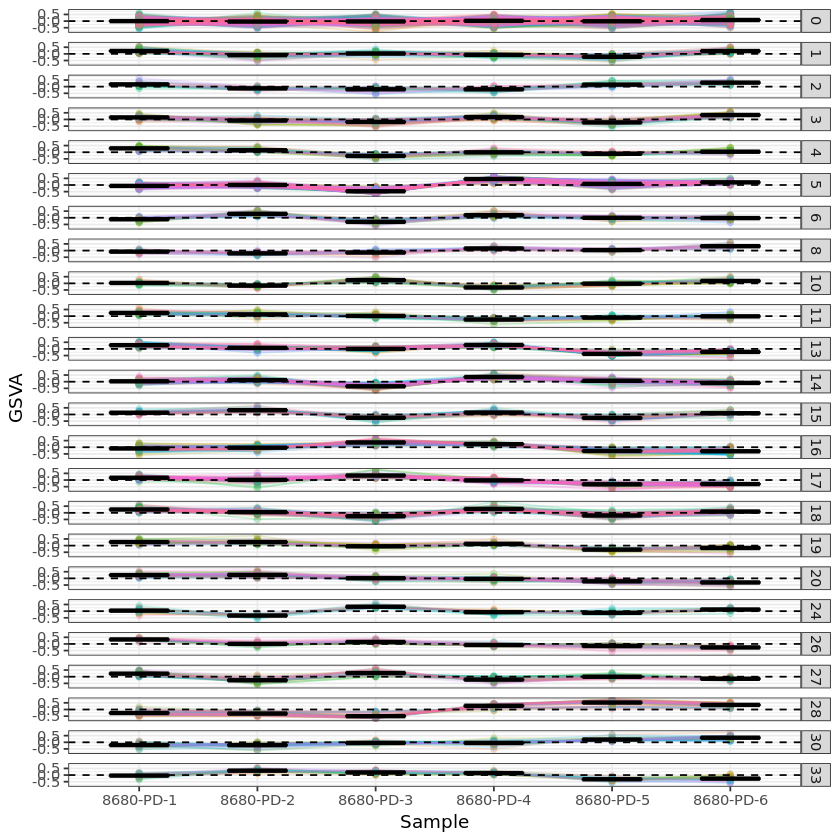

In [614]:
gsva_reactome_line <- as.data.frame(gsva_reactome)
gsva_reactome_line$cluster <- anno_row[rownames(gsva_reactome),]

gsva_reactome_line %>%
    rownames_to_column('Reactome') %>%
    pivot_longer(cols = !c(Reactome, cluster), names_to='Sample', values_to='GSVA') %>%
    ggplot(aes(Sample, GSVA)) +
        facet_grid(rows=vars(cluster)) +
        geom_line(aes(group=Reactome, color=Reactome), alpha=0.2) +
        geom_point(aes(color=Reactome), alpha=0.2) +
        stat_summary(fun.data='mean_se', geom='crossbar', width=0.5) +
        geom_hline(yintercept=0, lty=2) +
        theme_bw() +
        theme(legend.position='none')
ggsave(file.path(projdir, 'analyses', 'Plots', 'gsva_DEGReport_trends.png'), height=20)

In [181]:
reactome_ID2name[names(k10_clust==1)]

$`R-HSA-109582`
[1] "Homo sapiens: Hemostasis"

$`R-HSA-114608`
[1] "Homo sapiens: Platelet degranulation "

$`R-HSA-6798695`
[1] "Homo sapiens: Neutrophil degranulation"

$`R-HSA-76002`
[1] "Homo sapiens: Platelet activation, signaling and aggregation"

$`R-HSA-76005`
[1] "Homo sapiens: Response to elevated platelet cytosolic Ca2+"

$`R-HSA-156580`
[1] "Homo sapiens: Phase II - Conjugation of compounds"

$`R-HSA-211859`
[1] "Homo sapiens: Biological oxidations"

$`R-HSA-9748784`
[1] "Homo sapiens: Drug ADME"

$`R-HSA-9753281`
[1] "Homo sapiens: Paracetamol ADME"

$`R-HSA-15869`
[1] "Homo sapiens: Metabolism of nucleotides"

$`R-HSA-5668914`
[1] "Homo sapiens: Diseases of metabolism"

$`R-HSA-74217`
[1] "Homo sapiens: Purine salvage"

$`R-HSA-8956321`
[1] "Homo sapiens: Nucleotide salvage"

$`R-HSA-9755088`
[1] "Homo sapiens: Ribavirin ADME"

$`R-HSA-1500931`
[1] "Homo sapiens: Cell-Cell communication"

$`R-HSA-381426`
[1] "Homo sapiens: Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)"

$`R-HSA-418990`
[1] "Homo sapiens: Adherens junctions interactions"

$`R-HSA-421270`
[1] "Homo sapiens: Cell-cell junction organization"

$`R-HSA-446728`
[1] "Homo sapiens: Cell junction organization"

$`R-HSA-525793`
[1] "Homo sapiens: Myogenesis"

$`R-HSA-8957275`
[1] "Homo sapiens: Post-translational protein phosphorylation"

$`R-HSA-109581`
[1] "Homo sapiens: Apoptosis"

$`R-HSA-109606`
[1] "Homo sapiens: Intrinsic Pathway for Apoptosis"

$`R-HSA-111447`
[1] "Homo sapiens: Activation of BAD and translocation to mitochondria "

$`R-HSA-114452`
[1] "Homo sapiens: Activation of BH3-only proteins"

$`R-HSA-1227986`
[1] "Homo sapiens: Signaling by ERBB2"

$`R-HSA-1257604`
[1] "Homo sapiens: PIP3 activates AKT signaling"

$`R-HSA-1358803`
[1] "Homo sapiens: Downregulation of ERBB2:ERBB3 signaling"

$`R-HSA-186712`
[1] "Homo sapiens: Regulation of beta-cell development"

$`R-HSA-194138`
[1] "Homo sapiens: Signaling by VEGF"

$`R-HSA-198323`
[1] "Homo sapiens: AKT phosphorylates targets in the cytosol"

$`R-HSA-199418`
[1] "Homo sapiens: Negative regulation of the PI3K/AKT network"

$`R-HSA-2219528`
[1] "Homo sapiens: PI3K/AKT Signaling in Cancer"

$`R-HSA-3700989`
[1] "Homo sapiens: Transcriptional Regulation by TP53"

$`R-HSA-372790`
[1] "Homo sapiens: Signaling by GPCR"

$`R-HSA-388396`
[1] "Homo sapiens: GPCR downstream signalling"

$`R-HSA-388841`
[1] "Homo sapiens: Costimulation by the CD28 family"

$`R-HSA-389356`
[1] "Homo sapiens: CD28 co-stimulation"

$`R-HSA-389357`
[1] "Homo sapiens: CD28 dependent PI3K/Akt signaling"

$`R-HSA-389513`
[1] "Homo sapiens: CTLA4 inhibitory signaling"

$`R-HSA-392451`
[1] "Homo sapiens: G beta:gamma signalling through PI3Kgamma"

$`R-HSA-397795`
[1] "Homo sapiens: G-protein beta:gamma signalling"

$`R-HSA-4420097`
[1] "Homo sapiens: VEGFA-VEGFR2 Pathway"

$`R-HSA-453279`
[1] "Homo sapiens: Mitotic G1 phase and G1/S transition"

$`R-HSA-5218920`
[1] "Homo sapiens: VEGFR2 mediated vascular permeability"

$`R-HSA-5357801`
[1] "Homo sapiens: Programmed Cell Death"

$`R-HSA-5628897`
[1] "Homo sapiens: TP53 Regulates Metabolic Genes"

$`R-HSA-5633007`
[1] "Homo sapiens: Regulation of TP53 Activity"

$`R-HSA-5663202`
[1] "Homo sapiens: Diseases of signal transduction by growth factor receptors and second messengers"

$`R-HSA-5674400`
[1] "Homo sapiens: Constitutive Signaling by AKT1 E17K in Cancer"

$`R-HSA-6804757`
[1] "Homo sapiens: Regulation of TP53 Degradation"

$`R-HSA-6804758`
[1] "Homo sapiens: Regulation of TP53 Activity through Acetylation"

$`R-HSA-6804759`
[1] "Homo sapiens: Regulation of TP53 Activity through Association with Co-factors"

$`R-HSA-6806003`
[1] "Homo sapiens: Regulation of TP53 Expression and Degradation"

$`R-HSA-6807070`
[1] "Homo sapiens: PTEN Regulation"

$`R-HSA-69202`
[1] "Homo sapiens: Cyclin E associated events during G1/S transition "

$`R-HSA-69206`
[1] "Homo sapiens: G1/S Transition"

$`R-HSA-69242`
[

## Correlation heatmap

In [504]:
gsva_reactome_cor <- cor(gsva_reactome)

In [74]:
pal_len <- 200
my_pal <- colorRampPalette(rev(brewer.pal(11,'RdBu')))(pal_len)

In [521]:
myBreaks <- c(seq(min(gsva_reactome_cor), 0, length.out=ceiling(pal_len/2) + 1), 
              seq(max(gsva_reactome_cor)/pal_len, max(gsva_reactome_cor), length.out=floor(pal_len/2)))

In [524]:
pheatmap::pheatmap(
    gsva_reactome_cor,
    annotation_col = anno_col, annotation_colors = anno_colors,
    breaks = myBreaks,
    color = my_pal,
    filename = file.path(projdir, 'analyses', 'Plots', 'gsva_cor_hmp.png')
)

## GSVA correlation heatmap

In [72]:
gsva_cor <- cor(t(gsva_reactome))

In [74]:
pal_len <- 200
my_pal <- colorRampPalette(rev(brewer.pal(11,'RdBu')))(pal_len)

In [75]:
myBreaks <- c(seq(min(gsva_cor), 0, length.out=ceiling(pal_len/2) + 1), 
              seq(max(gsva_cor)/pal_len, max(gsva_cor), length.out=floor(pal_len/2)))

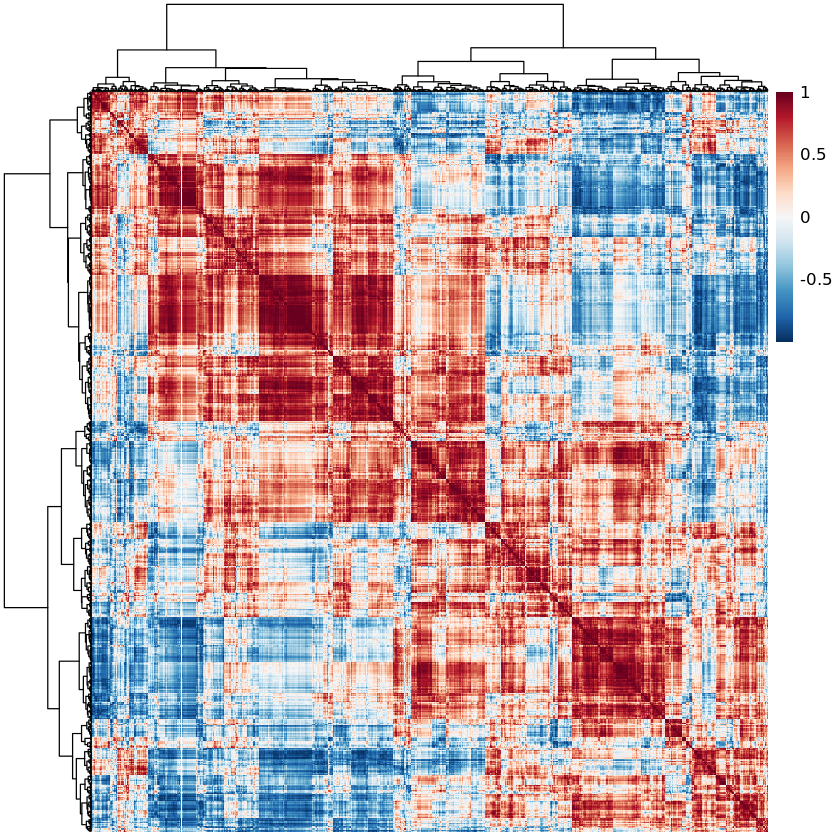

In [76]:
gsva_cor_hmp <- pheatmap::pheatmap(
    gsva_cor,
    scale = 'none', 
    clustering_method = 'ward.D2',
    show_rownames = FALSE, show_colnames = FALSE,
    color = my_pal, breaks = myBreaks
)

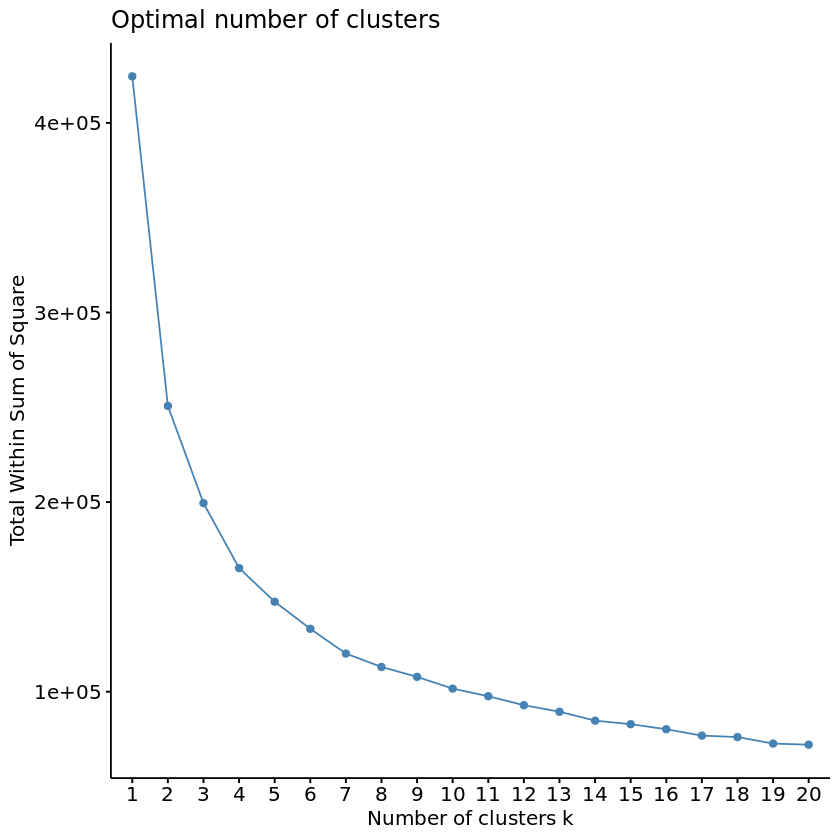

In [79]:
factoextra::fviz_nbclust(gsva_cor, kmeans, method = "wss", k.max = 20)

In [93]:
gsva_cor_hmp_kmeans <- kmeans(gsva_cor_hmp$tree_row, 6)

In [106]:
gsva_cor_hmp_kmeans_clust <- enframe(gsva_cor_hmp_kmeans$cluster) %>% 
    setNames(c('reactome_id', 'cluster')) %>%
    arrange(cluster)
gsva_cor_hmp_kmeans_clust$reactome_name <- reactome_ID2name[gsva_cor_hmp_kmeans_clust$reactome_id]
gsva_cor_hmp_kmeans_clust$reactome_name <- gsub('Homo sapiens: ', '', gsva_cor_hmp_kmeans_clust$reactome_name)

In [112]:
head(gsva_cor_hmp_kmeans_clust)

reactome_id   cluster reactome_name                              
1 R-HSA-199418  1       Negative regulation of the PI3K/AKT network
2 R-HSA-2219528 1       PI3K/AKT Signaling in Cancer               
3 R-HSA-388841  1       Costimulation by the CD28 family           
4 R-HSA-389356  1       CD28 co-stimulation                        
5 R-HSA-389357  1       CD28 dependent PI3K/Akt signaling          
6 R-HSA-5633007 1       Regulation of TP53 Activity

In [116]:
projdir

[1] "/mnt/c/Users/benjy/Dropbox (University of Michigan)/ENGIN-Lab Notes/Lab Notes/Lab Notes Benjamin/GraceCaiSamples/8680-PD"

In [118]:
anno_colors <- RColorBrewer::brewer.pal(6, 'Paired')
names(anno_colors) <- 1:6
anno_colors <- list(cluster = anno_colors)

pheatmap::pheatmap(
    gsva_cor,
    scale = 'none', 
    clustering_method = 'ward.D2',
    annotation_row = gsva_cor_hmp_kmeans_clust[,1:2] %>% column_to_rownames('reactome_id') %>% mutate(cluster = as.factor(cluster)),
    annotation_colors = anno_colors,
    show_rownames = FALSE, show_colnames = FALSE,
    color = my_pal, breaks = myBreaks,
    filename = file.path(projdir, 'analyses', 'Plots', 'reactome_cor_hmp.svg')
)

ERROR: Error in heatmap_motor(mat, border_color = border_color, cellwidth = cellwidth, : File type should be: pdf, png, bmp, jpg, tiff


### Jaccard

In [119]:
jaccard <- function(a, b) {
    intersection = length(intersect(a, b))
    union = length(a) + length(b) - intersection
    return (intersection/union)
}

In [120]:
entrez_genes <- rownames(lcpm_filt_entrez)
genes_in_reactome <- sapply(reactome_path2ID, function(i) intersect(i, entrez_genes))

In [126]:
reactome_clust_combo <- list()
reactome_clust_jaccard <- list()
for(i in unique(gsva_cor_hmp_kmeans_clust$cluster)) {
    reactome_clust_combo[[i]] <- t(combn(gsva_cor_hmp_kmeans_clust$reactome_id[gsva_cor_hmp_kmeans_clust$cluster==i], 2))
    reactome_clust_jaccard[[i]] <- apply(reactome_clust_combo[[i]], 1, function(x) jaccard(genes_in_reactome[[x[1]]], genes_in_reactome[[x[2]]]))
}

In [134]:
unique(reactome_ID2name[reactome_clust_combo[[2]][which(reactome_clust_jaccard[[2]] > 0.9),1]])

[[1]]
[1] "Homo sapiens: alpha-linolenic (omega3) and linoleic (omega6) acid metabolism"

[[2]]
[1] "Homo sapiens: XBP1(S) activates chaperone genes"

[[3]]
[1] "Homo sapiens: snRNP Assembly"

[[4]]
[1] "Homo sapiens: Cyclin D associated events in G1"

[[5]]
[1] "Homo sapiens: Signaling by PTK6"

[[6]]
[1] "Homo sapiens: Aberrant regulation of mitotic G1/S transition in cancer due to RB1 defects"

[[7]]
[1] "Homo sapiens: Diseases of mitotic cell cycle"

[[8]]
[1] "Homo sapiens: Negative regulation of FGFR2 signaling"

[[9]]
[1] "Homo sapiens: Signaling by moderate kinase activity BRAF mutants"

[[10]]
[1] "Homo sapiens: Signaling by RAS mutants"

[[11]]
[1] "Homo sapiens: Paradoxical activation of RAF signaling by kinase inactive BRAF"

[[12]]
[1] "Homo sapiens: Mismatch Repair"

[[13]]
[1] "Homo sapiens: Polymerase switching"

[[14]]
[1] "Homo sapiens: Removal of the Flap Intermediate"

[[15]]
[1] "Homo sapiens: Constitutive Signaling by Ligand-Responsive EGFR Cancer Variants"

[[16]]
[1] "Homo sapiens: Signaling by AXIN mutants"

[[17]]
[1] "Homo sapiens: Signaling by CTNNB1 phospho-site mutants"

[[18]]
[1] "Homo sapiens: Signaling by APC mutants"

[[19]]
[1] "Homo sapiens: Signaling by AMER1 mutants"

[[20]]
[1] "Homo sapiens: Signaling by GSK3beta mutants"

[[21]]
[1] "Homo sapiens: CTNNB1 S33 mutants aren't phosphorylated"

[[22]]
[1] "Homo sapiens: CTNNB1 S37 mutants aren't phosphorylated"

[[23]]
[1] "Homo sapiens: CTNNB1 S45 mutants aren't phosphorylated"

[[24]]
[1] "Homo sapiens: CTNNB1 T41 mutants aren't phosphorylated"

[[25]]
[1] "Homo sapiens: APC truncation mutants have impaired AXIN binding"

[[26]]
[1] "Homo sapiens: AXIN missense mutants destabilize the destruction complex"

[[27]]
[1] "Homo sapiens: Formation of apoptosome"

In [107]:
gsva_cor_hmp_kmeans_clust

reactome_id   cluster
1    R-HSA-199418  1      
2    R-HSA-2219528 1      
3    R-HSA-388841  1      
4    R-HSA-389356  1      
5    R-HSA-389357  1      
6    R-HSA-5633007 1      
7    R-HSA-9006934 1      
8    R-HSA-1989781 1      
9    R-HSA-400206  1      
10   R-HSA-192105  1      
11   R-HSA-194068  1      
12   R-HSA-9012999 1      
13   R-HSA-9013404 1      
14   R-HSA-9013423 1      
15   R-HSA-933541  1      
16   R-HSA-8940973 1      
17   R-HSA-8941326 1      
18   R-HSA-1483166 1      
19   R-HSA-1483257 1      
20   R-HSA-193704  1      
21   R-HSA-204998  1      
22   R-HSA-1433557 1      
23   R-HSA-1433559 1      
24   R-HSA-6811442 1      
25   R-HSA-6806834 1      
26   R-HSA-8851805 1      
27   R-HSA-3371453 1      
28   R-HSA-2424491 1      
29   R-HSA-2990846 1      
30   R-HSA-3108214 1      
⋮    ⋮             ⋮      
1364 R-HSA-975144  6      
1365 R-HSA-190873  6      
1366 R-HSA-196025  6      
1367 R-HSA-5140745 6      
1368 R-HSA-8868766 6      
1369 R-HSA-156581  6      
1370 R-HSA-111367  6      
1371 R-HSA-77588   6      
1372 R-HSA-189451  6      
1373 R-HSA-5663084 6      
1374 R-HSA-9705462 6      
1375 R-HSA-936440  6      
1376 R-HSA-70221   6      
1377 R-HSA-8982491 6      
1378 R-HSA-83936   6      
1379 R-HSA-199220  6      
1380 R-HSA-71336   6      
1381 R-HSA-1839126 6      
1382 R-HSA-8851708 6      
1383 R-HSA-167242  6      
1384 R-HSA-6803529 6      
1385 R-HSA-205043  6      
1386 R-HSA-162710  6      
1387 R-HSA-3229121 6      
1388 R-HSA-110320  6      
1389 R-HSA-3322077 6      
1390 R-HSA-4641263 6      
1391 R-HSA-975110  6      
1392 R-HSA-176974  6      
1393 R-HSA-9708530 6      
     reactome_name                                                                           
1    Negative regulation of the PI3K/AKT network                                             
2    PI3K/AKT Signaling in Cancer                                                            
3    Costimulation by the CD28 family                                                        
4    CD28 co-stimulation                                                                     
5    CD28 dependent PI3K/Akt signaling                                                       
6    Regulation of TP53 Activity                                                             
7    Signaling by Receptor Tyrosine Kinases                                                  
8    PPARA activates gene expression                                                         
9    Regulation of lipid metabolism by PPARalpha                                             
10   Synthesis of bile acids and bile salts                                                  
11   Bile acid and bile salt metabolism                                                      
12   RHO GTPase cycle                                                                        
13   RAC2 GTPase cycle                                                                       
14   RAC3 GTPase cycle                                                                       
15   TRAF6 mediated IRF7 activation                                                          
16   RUNX2 regulates osteoblast differentiation                                              
17   RUNX2 regulates bone development                                                        
18   Synthesis of PA                                                                         
19   Phospholipid metabolism                                                                 
20   p75 NTR receptor-mediated signalling                                                    
21   Cell death signalling via NRAGE, NRIF and NADE                                          
22   Signaling by SCF-KIT                                                                    
23   Regulation of KIT signaling                                                             
24   Intra-Golgi and retrograde Golgi-to-ER traffic                        